##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple RNN. You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate a longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libdouble-conversion3 libfluidsynth2 libinstpatch-1.0-2
  libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5
  libqt5widgets5 libsdl2-2.0-0 libxcb-xinerama0 libxcb-xinput0 qsynth
  qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity qt5-image-formats-plugins qtwayland5 jackd
  musescore


The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libdouble-conversion3 libfluidsynth2
  libinstpatch-1.0-2 libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5svg5 libqt5widgets5 libsdl2-2.0-0 libxcb-xinerama0
  libxcb-xinput0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont


0 upgraded, 19 newly installed, 0 to remove and 139 not upgraded.
Need to get 136 MB of archives.
After this operation, 203 MB of additional disk space will be used.


Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libdouble-conversion3 amd64 3.1.5-4ubuntu1 [37.9 kB]
Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcre2-16-0 amd64 10.34-7 [181 kB]
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5core5a amd64 5.12.8+dfsg-0ubuntu2.1 [2006 kB]
Get:4 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5dbus5 amd64 5.12.8+dfsg-0ubuntu2.1 [208 kB]
Get:5 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5network5 amd64 5.12.8+dfsg-0ubuntu2.1 [673 kB]
6% [5 libqt5network5 55.4 kB/673 kB 8%]

Get:6 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libxcb-xinerama0 amd64 1.14-2 [5260 B]
Get:7 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libxcb-xinput0 amd64 1.14-2 [29.3 kB]
Get:8 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5gui5 amd64 5.12.8+dfsg-0ubuntu2.1 [2971 kB]
Get:9 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5widgets5 amd64 5.12.8+dfsg-0ubuntu2.1 [2295 kB]
12% [9 libqt5widgets5 44.6 kB/2295 kB 2%]

Get:10 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]
16% [Waiting for headers]

Get:11 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
16% [11 fluid-soundfont-gm 12.3 kB/119 MB 0%]

26% [11 fluid-soundfont-gm 17.5 MB/119 MB 15%]

30% [11 fluid-soundfont-gm 24.3 MB/119 MB 20%]

33% [11 fluid-soundfont-gm 29.0 MB/119 MB 24%]

38% [11 fluid-soundfont-gm 37.5 MB/119 MB 31%]

41% [11 fluid-soundfont-gm 43.4 MB/119 MB 36%]

46% [11 fluid-soundfont-gm 51.1 MB/119 MB 43%]

49% [11 fluid-soundfont-gm 56.3 MB/119 MB 47%]

51% [11 fluid-soundfont-gm 60.4 MB/119 MB 51%]

55% [11 fluid-soundfont-gm 67.9 MB/119 MB 57%]

60% [11 fluid-soundfont-gm 74.9 MB/119 MB 63%]

64% [11 fluid-soundfont-gm 82.3 MB/119 MB 69%]

67% [11 fluid-soundfont-gm 87.1 MB/119 MB 73%]                     15.4 MB/s 2s

69% [11 fluid-soundfont-gm 90.9 MB/119 MB 76%]                     15.4 MB/s 2s

71% [11 fluid-soundfont-gm 94.0 MB/119 MB 79%]                     15.4 MB/s 2s

76% [11 fluid-soundfont-gm 103 MB/119 MB 86%]                      15.4 MB/s 1s

80% [11 fluid-soundfont-gm 109 MB/119 MB 91%]                      15.4 MB/s 1s

83% [11 fluid-soundfont-gm 115 MB/119 MB 96%]                      15.4 MB/s 0s

86% [11 fluid-soundfont-gm 119 MB/119 MB 100%]                     15.4 MB/s 0s

Get:12 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:13 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libsdl2-2.0-0 amd64 2.0.10+dfsg1-3 [407 kB]
Get:14 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5420 kB]
89% [14 timgm6mb-soundfont 62.1 kB/5420 kB 1%]                     15.4 MB/s 0s

Get:15 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [198 kB]
95% [Waiting for headers]                                          15.4 MB/s 0s

Get:16 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluidsynth amd64 2.1.1-2 [25.6 kB]
96% [Waiting for headers]                                          15.4 MB/s 0s

Get:17 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qsynth amd64 0.6.1-1build1 [245 kB]
Get:18 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 qt5-gtk-platformtheme amd64 5.12.8+dfsg-0ubuntu2.1 [124 kB]
Get:19 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qttranslations5-l10n all 5.12.8-0ubuntu1 [1486 kB]
98% [19 qttranslations5-l10n 8040 B/1486 kB 1%]                    15.4 MB/s 0s

Fetched 136 MB in 10s (13.8 MB/s)



78

Selecting previously unselected package libdouble-conversion3:amd64.


(Reading database ... 139818 files and directories currently installed.)
Preparing to unpack .../00-libdouble-conversion3_3.1.5-4ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  1%] [..........................................................] 8Unpacking libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...


7Progress: [  3%] [#.........................................................] 8Selecting previously unselected package libpcre2-16-0:amd64.
Preparing to unpack .../01-libpcre2-16-0_10.34-7_amd64.deb ...
7Progress: [  4%] [##........................................................] 8Unpacking libpcre2-16-0:amd64 (10.34-7) ...


7Progress: [  5%] [###.......................................................] 8

Selecting previously unselected package libqt5core5a:amd64.
Preparing to unpack .../02-libqt5core5a_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  6%] [###.......................................................] 8Unpacking libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [  8%] [####......................................................] 8Selecting previously unselected package libqt5dbus5:amd64.


Preparing to unpack .../03-libqt5dbus5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  9%] [#####.....................................................] 8Unpacking libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 10%] [######....................................................] 8

Selecting previously unselected package libqt5network5:amd64.
Preparing to unpack .../04-libqt5network5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 12%] [######....................................................] 8Unpacking libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 13%] [#######...................................................] 8Selecting previously unselected package libxcb-xinerama0:amd64.
Preparing to unpack .../05-libxcb-xinerama0_1.14-2_amd64.deb ...
7Progress: [ 14%] [########..................................................] 8Unpacking libxcb-xinerama0:amd64 (1.14-2) ...


7Progress: [ 16%] [#########.................................................] 8Selecting previously unselected package libxcb-xinput0:amd64.
Preparing to unpack .../06-libxcb-xinput0_1.14-2_amd64.deb ...
7Progress: [ 17%] [#########.................................................] 8Unpacking libxcb-xinput0:amd64 (1.14-2) ...


7Progress: [ 18%] [##########................................................] 8

Selecting previously unselected package libqt5gui5:amd64.
Preparing to unpack .../07-libqt5gui5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 19%] [###########...............................................] 8Unpacking libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 21%] [############..............................................] 8Selecting previously unselected package libqt5widgets5:amd64.


Preparing to unpack .../08-libqt5widgets5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 22%] [############..............................................] 8Unpacking libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 23%] [#############.............................................] 8

Selecting previously unselected package libqt5svg5:amd64.
Preparing to unpack .../09-libqt5svg5_5.12.8-0ubuntu1_amd64.deb ...
7Progress: [ 25%] [##############............................................] 8Unpacking libqt5svg5:amd64 (5.12.8-0ubuntu1) ...


7Progress: [ 26%] [###############...........................................] 8Selecting previously unselected package fluid-soundfont-gm.
Preparing to unpack .../10-fluid-soundfont-gm_3.1-5.1_all.deb ...
7Progress: [ 27%] [###############...........................................] 8Unpacking fluid-soundfont-gm (3.1-5.1) ...


7Progress: [ 29%] [################..........................................] 8

Selecting previously unselected package libinstpatch-1.0-2:amd64.
Preparing to unpack .../11-libinstpatch-1.0-2_1.1.2-2build1_amd64.deb ...
7Progress: [ 30%] [#################.........................................] 8Unpacking libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...


7Progress: [ 31%] [##################........................................] 8Selecting previously unselected package libsdl2-2.0-0:amd64.


Preparing to unpack .../12-libsdl2-2.0-0_2.0.10+dfsg1-3_amd64.deb ...
7Progress: [ 32%] [##################........................................] 8Unpacking libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...


7Progress: [ 34%] [###################.......................................] 8Selecting previously unselected package timgm6mb-soundfont.


Preparing to unpack .../13-timgm6mb-soundfont_1.3-3_all.deb ...
7Progress: [ 35%] [####################......................................] 8Unpacking timgm6mb-soundfont (1.3-3) ...


7Progress: [ 36%] [#####################.....................................] 8Selecting previously unselected package libfluidsynth2:amd64.
Preparing to unpack .../14-libfluidsynth2_2.1.1-2_amd64.deb ...
7Progress: [ 38%] [#####################.....................................] 8

Unpacking libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 39%] [######################....................................] 8

Selecting previously unselected package fluidsynth.
Preparing to unpack .../15-fluidsynth_2.1.1-2_amd64.deb ...
7Progress: [ 40%] [#######################...................................] 8Unpacking fluidsynth (2.1.1-2) ...
7Progress: [ 42%] [########################..................................] 8

Selecting previously unselected package qsynth.
Preparing to unpack .../16-qsynth_0.6.1-1build1_amd64.deb ...
7Progress: [ 43%] [########################..................................] 8Unpacking qsynth (0.6.1-1build1) ...


7Progress: [ 44%] [#########################.................................] 8Selecting previously unselected package qt5-gtk-platformtheme:amd64.


Preparing to unpack .../17-qt5-gtk-platformtheme_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 45%] [##########################................................] 8Unpacking qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 47%] [###########################...............................] 8

Selecting previously unselected package qttranslations5-l10n.
Preparing to unpack .../18-qttranslations5-l10n_5.12.8-0ubuntu1_all.deb ...
7Progress: [ 48%] [###########################...............................] 8Unpacking qttranslations5-l10n (5.12.8-0ubuntu1) ...


7Progress: [ 49%] [############################..............................] 8

Setting up libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...


7Progress: [ 51%] [#############################.............................] 87Progress: [ 52%] [##############################............................] 8Setting up libxcb-xinput0:amd64 (1.14-2) ...
7Progress: [ 53%] [##############################............................] 87Progress: [ 55%] [###############################...........................] 8Setting up libpcre2-16-0:amd64 (10.34-7) ...
7Progress: [ 56%] [################################..........................] 87Progress: [ 57%] [#################################.........................] 8Setting up libxcb-xinerama0:amd64 (1.14-2) ...
7Progress: [ 58%] [#################################.........................] 87Progress: [ 60%] [##################################........................] 8Setting up qttranslations5-l10n (5.12.8-0ubuntu1) ...
7Progress: [ 61%] [###################################.......................] 87Progress: [ 62%] [####################################...............

7Progress: [ 65%] [#####################################.....................] 8Setting up libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 66%] [######################################....................] 87Progress: [ 68%] [#######################################...................] 8Setting up fluid-soundfont-gm (3.1-5.1) ...
7Progress: [ 69%] [#######################################...................] 87Progress: [ 70%] [########################################..................] 8Setting up libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...
7Progress: [ 71%] [#########################################.................] 87Progress: [ 73%] [##########################################................] 8Setting up timgm6mb-soundfont (1.3-3) ...
7Progress: [ 74%] [##########################################................] 8

update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode


update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
7Progress: [ 75%] [###########################################...............] 8Setting up libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...
7Progress: [ 77%] [############################################..............] 87Progress: [ 78%] [#############################################.............] 8Setting up libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 79%] [#############################################.............] 87Progress: [ 81%] [##############################################............] 8Setting up libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 82%] [###############################################...........] 87Progress: [ 83%] [################################################..........] 8Setting up libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 84%] [##############################################

7Progress: [ 88%] [###################################################.......] 8Setting up qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 90%] [###################################################.......] 87Progress: [ 91%] [####################################################......] 8Setting up fluidsynth (2.1.1-2) ...
7Progress: [ 92%] [#####################################################.....] 8

Created symlink /etc/systemd/user/multi-user.target.wants/fluidsynth.service → /usr/lib/systemd/user/fluidsynth.service.
7Progress: [ 94%] [######################################################....] 8Setting up libqt5svg5:amd64 (5.12.8-0ubuntu1) ...
7Progress: [ 95%] [######################################################....] 87Progress: [ 96%] [#######################################################...] 8Setting up qsynth (0.6.1-1build1) ...
7Progress: [ 97%] [########################################################..] 87Progress: [ 99%] [#########################################################.] 8Processing triggers for desktop-file-utils (0.24-1ubuntu3) ...
Processing triggers for mime-support (3.64ubuntu1) ...


Processing triggers for hicolor-icon-theme (0.17-2) ...


Processing triggers for gnome-menus (3.36.0-1ubuntu1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.7) ...


Processing triggers for man-db (2.9.1-1) ...



78

In [3]:
!pip install --upgrade pyfluidsynth

In [4]:
!pip install pretty_midi

  Preparing metadata (setup.py) ... -

 \

 |

 /

 done


 \

 |

 /

 -

 \

 |

 done


  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591938 sha256=52f290d46c8de2e261802e05f3e3566cf6e76bb0859db899c5879e179a90838c
  Stored in directory: /home/kbuilder/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

    8192/59243107 [..............................] - ETA: 0s

 4530176/59243107 [=>............................] - ETA: 0s

 8396800/59243107 [===>..........................] - ETA: 0s

18677760/59243107 [========>.....................] - ETA: 0s

29753344/59243107 [==============>...............] - ETA: 0s

41000960/59243107 [===================>..........] - ETA: 0s

46530560/59243107 [======================>.......] - ETA: 0s

50339840/59243107 [========================>.....] - ETA: 0s

59243107/59243107 [==============================] - 1s 0us/step


The dataset contains about 1,200 MIDI files.

In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_14_R2_2013_wav--1.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


Do some inspection on the MIDI file. What kinds of instruments are used?

In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=46, note_name=A#2, duration=0.0651
1: pitch=74, note_name=D5, duration=0.1237
2: pitch=62, note_name=D4, duration=0.3216
3: pitch=74, note_name=D5, duration=0.1133
4: pitch=53, note_name=F3, duration=0.2956
5: pitch=58, note_name=A#3, duration=0.3333
6: pitch=62, note_name=D4, duration=0.3346
7: pitch=74, note_name=D5, duration=0.4727
8: pitch=50, note_name=D3, duration=0.2552
9: pitch=70, note_name=A#4, duration=0.3021


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,74,1.049479,1.173177,0.000000,0.123698
1,46,1.082031,1.147135,0.032552,0.065104
2,62,1.501302,1.822917,0.419271,0.321615
3,74,1.781250,1.894531,0.279948,0.113281
4,58,1.803385,2.136719,0.022135,0.333333


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D5', 'A#2', 'D4', 'D5', 'A#3', 'F3', 'D5', 'D4', 'A#4', 'D3'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

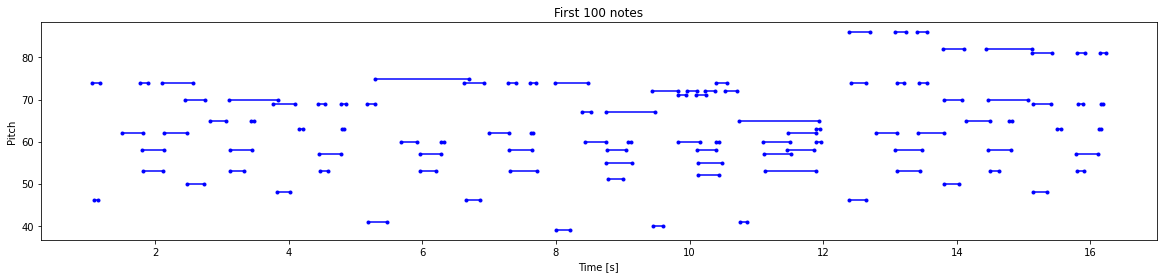

In [19]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

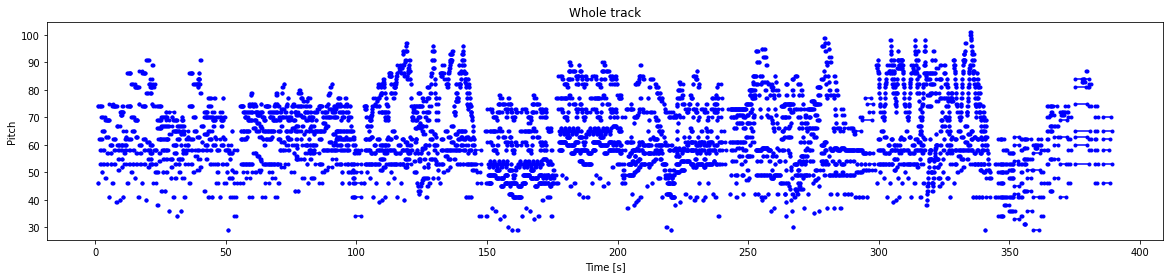

In [20]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

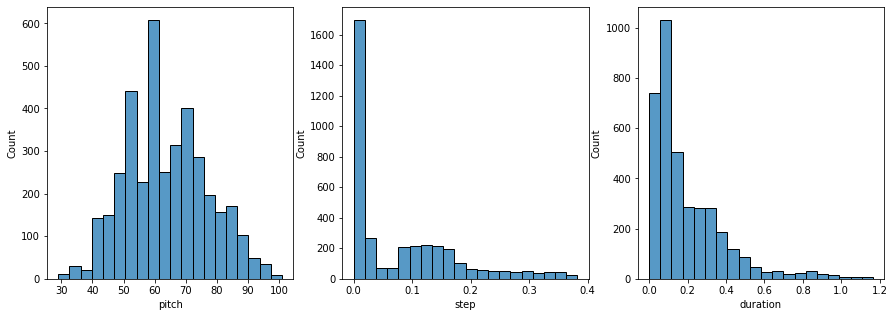

In [22]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [25]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 28365


Next, create a [tf.data.Dataset](https://www.tensorflow.org/datasets) from the parsed notes.

In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram explaining this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.359375   0.         0.30989583]
 [0.578125   0.0546875  0.49088542]
 [0.484375   0.48567708 0.2890625 ]
 [0.453125   0.29296875 0.4765625 ]
 [0.578125   0.00130208 0.13802083]
 [0.4140625  0.00911458 0.26953125]
 [0.578125   0.296875   0.45052083]
 [0.484375   0.01953125 0.09505208]
 [0.390625   0.3046875  0.20572917]
 [0.546875   0.04296875 0.41666667]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.44661458333333304>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.26953125>}


Batch the examples, and configure the dataset for performance.

In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               


 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                


 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   


 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   


 step (Dense)                   (None, 1)            129         ['lstm[0][0]']                   


Total params: 84,354


Trainable params: 84,354


Non-trainable params: 0


__________________________________________________________________________________________________


Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

      1/Unknown - 6s 6s/step - loss: 5.4609 - duration_loss: 0.5871 - pitch_loss: 4.8605 - step_loss: 0.0134

     16/Unknown - 6s 3ms/step - loss: 5.0940 - duration_loss: 0.2038 - pitch_loss: 4.8477 - step_loss: 0.0425

     32/Unknown - 6s 3ms/step - loss: 5.0721 - duration_loss: 0.1835 - pitch_loss: 4.8491 - step_loss: 0.0396

     47/Unknown - 6s 3ms/step - loss: 5.0761 - duration_loss: 0.1902 - pitch_loss: 4.8493 - step_loss: 0.0367

     62/Unknown - 7s 3ms/step - loss: 5.0565 - duration_loss: 0.1754 - pitch_loss: 4.8487 - step_loss: 0.0324

     77/Unknown - 7s 3ms/step - loss: 5.0553 - duration_loss: 0.1727 - pitch_loss: 4.8488 - step_loss: 0.0338

     93/Unknown - 7s 3ms/step - loss: 5.0492 - duration_loss: 0.1642 - pitch_loss: 4.8489 - step_loss: 0.0360

    108/Unknown - 7s 3ms/step - loss: 5.0860 - duration_loss: 0.1981 - pitch_loss: 4.8491 - step_loss: 0.0388

    124/Unknown - 7s 3ms/step - loss: 5.0742 - duration_loss: 0.1875 - pitch_loss: 4.8490 - step_loss: 0.0377

    140/Unknown - 7s 3ms/step - loss: 5.0764 - duration_loss: 0.1903 - pitch_loss: 4.8490 - step_loss: 0.0371

    156/Unknown - 7s 3ms/step - loss: 5.0707 - duration_loss: 0.1858 - pitch_loss: 4.8490 - step_loss: 0.0359

    171/Unknown - 7s 3ms/step - loss: 5.0688 - duration_loss: 0.1838 - pitch_loss: 4.8489 - step_loss: 0.0361

    186/Unknown - 7s 3ms/step - loss: 5.0658 - duration_loss: 0.1807 - pitch_loss: 4.8490 - step_loss: 0.0360

    201/Unknown - 7s 3ms/step - loss: 5.0668 - duration_loss: 0.1823 - pitch_loss: 4.8489 - step_loss: 0.0357

    216/Unknown - 7s 3ms/step - loss: 5.0714 - duration_loss: 0.1867 - pitch_loss: 4.8488 - step_loss: 0.0358

    232/Unknown - 7s 3ms/step - loss: 5.0671 - duration_loss: 0.1827 - pitch_loss: 4.8487 - step_loss: 0.0357

    247/Unknown - 7s 3ms/step - loss: 5.0644 - duration_loss: 0.1796 - pitch_loss: 4.8488 - step_loss: 0.0360

    263/Unknown - 7s 3ms/step - loss: 5.0671 - duration_loss: 0.1825 - pitch_loss: 4.8488 - step_loss: 0.0358

    278/Unknown - 7s 3ms/step - loss: 5.0647 - duration_loss: 0.1797 - pitch_loss: 4.8488 - step_loss: 0.0361

    293/Unknown - 7s 3ms/step - loss: 5.0615 - duration_loss: 0.1771 - pitch_loss: 4.8488 - step_loss: 0.0355

    309/Unknown - 7s 3ms/step - loss: 5.0629 - duration_loss: 0.1788 - pitch_loss: 4.8488 - step_loss: 0.0354

    325/Unknown - 7s 3ms/step - loss: 5.0599 - duration_loss: 0.1754 - pitch_loss: 4.8488 - step_loss: 0.0358

    340/Unknown - 7s 3ms/step - loss: 5.0565 - duration_loss: 0.1718 - pitch_loss: 4.8488 - step_loss: 0.0358

    356/Unknown - 8s 3ms/step - loss: 5.0557 - duration_loss: 0.1713 - pitch_loss: 4.8490 - step_loss: 0.0353

    371/Unknown - 8s 3ms/step - loss: 5.0530 - duration_loss: 0.1687 - pitch_loss: 4.8490 - step_loss: 0.0353

    386/Unknown - 8s 3ms/step - loss: 5.0532 - duration_loss: 0.1694 - pitch_loss: 4.8490 - step_loss: 0.0348

    401/Unknown - 8s 3ms/step - loss: 5.0550 - duration_loss: 0.1710 - pitch_loss: 4.8490 - step_loss: 0.0350

    417/Unknown - 8s 3ms/step - loss: 5.0575 - duration_loss: 0.1730 - pitch_loss: 4.8490 - step_loss: 0.0356

    432/Unknown - 8s 3ms/step - loss: 5.0541 - duration_loss: 0.1702 - pitch_loss: 4.8489 - step_loss: 0.0350

442/442 [==============================] - 8s 4ms/step - loss: 5.0546 - duration_loss: 0.1709 - pitch_loss: 4.8489 - step_loss: 0.0348


{'loss': 5.054589748382568,
 'duration_loss': 0.17090104520320892,
 'pitch_loss': 4.848920822143555,
 'step_loss': 0.03476677089929581}

One way balance this is to use the `loss_weights` argument to compile:

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [39]:
model.evaluate(train_ds, return_dict=True)

      1/Unknown - 1s 978ms/step - loss: 0.8435 - duration_loss: 0.5871 - pitch_loss: 4.8605 - step_loss: 0.0134

     16/Unknown - 1s 3ms/step - loss: 0.4886 - duration_loss: 0.2038 - pitch_loss: 4.8477 - step_loss: 0.0425  

     31/Unknown - 1s 3ms/step - loss: 0.4700 - duration_loss: 0.1872 - pitch_loss: 4.8489 - step_loss: 0.0404

     46/Unknown - 1s 3ms/step - loss: 0.4725 - duration_loss: 0.1931 - pitch_loss: 4.8494 - step_loss: 0.0369

     61/Unknown - 1s 3ms/step - loss: 0.4502 - duration_loss: 0.1757 - pitch_loss: 4.8487 - step_loss: 0.0321

     76/Unknown - 1s 3ms/step - loss: 0.4484 - duration_loss: 0.1721 - pitch_loss: 4.8490 - step_loss: 0.0339

     91/Unknown - 1s 3ms/step - loss: 0.4436 - duration_loss: 0.1668 - pitch_loss: 4.8489 - step_loss: 0.0343

    106/Unknown - 1s 3ms/step - loss: 0.4794 - duration_loss: 0.1976 - pitch_loss: 4.8491 - step_loss: 0.0393

    121/Unknown - 1s 3ms/step - loss: 0.4707 - duration_loss: 0.1898 - pitch_loss: 4.8489 - step_loss: 0.0384

    135/Unknown - 1s 3ms/step - loss: 0.4749 - duration_loss: 0.1946 - pitch_loss: 4.8489 - step_loss: 0.0379

    149/Unknown - 1s 4ms/step - loss: 0.4632 - duration_loss: 0.1842 - pitch_loss: 4.8490 - step_loss: 0.0365

    163/Unknown - 2s 4ms/step - loss: 0.4617 - duration_loss: 0.1839 - pitch_loss: 4.8489 - step_loss: 0.0354

    177/Unknown - 2s 4ms/step - loss: 0.4608 - duration_loss: 0.1827 - pitch_loss: 4.8488 - step_loss: 0.0356

    192/Unknown - 2s 4ms/step - loss: 0.4576 - duration_loss: 0.1793 - pitch_loss: 4.8490 - step_loss: 0.0359

    207/Unknown - 2s 4ms/step - loss: 0.4616 - duration_loss: 0.1832 - pitch_loss: 4.8489 - step_loss: 0.0360

    222/Unknown - 2s 4ms/step - loss: 0.4628 - duration_loss: 0.1849 - pitch_loss: 4.8488 - step_loss: 0.0355

    237/Unknown - 2s 4ms/step - loss: 0.4604 - duration_loss: 0.1827 - pitch_loss: 4.8487 - step_loss: 0.0352

    253/Unknown - 2s 3ms/step - loss: 0.4627 - duration_loss: 0.1845 - pitch_loss: 4.8488 - step_loss: 0.0358

    267/Unknown - 2s 3ms/step - loss: 0.4597 - duration_loss: 0.1815 - pitch_loss: 4.8488 - step_loss: 0.0357

    282/Unknown - 2s 3ms/step - loss: 0.4564 - duration_loss: 0.1782 - pitch_loss: 4.8489 - step_loss: 0.0358

    297/Unknown - 2s 3ms/step - loss: 0.4557 - duration_loss: 0.1773 - pitch_loss: 4.8488 - step_loss: 0.0360

    312/Unknown - 2s 3ms/step - loss: 0.4563 - duration_loss: 0.1787 - pitch_loss: 4.8488 - step_loss: 0.0352

    327/Unknown - 2s 3ms/step - loss: 0.4535 - duration_loss: 0.1749 - pitch_loss: 4.8488 - step_loss: 0.0361

    342/Unknown - 2s 3ms/step - loss: 0.4493 - duration_loss: 0.1711 - pitch_loss: 4.8489 - step_loss: 0.0357

    357/Unknown - 2s 3ms/step - loss: 0.4488 - duration_loss: 0.1710 - pitch_loss: 4.8490 - step_loss: 0.0353

    372/Unknown - 2s 3ms/step - loss: 0.4461 - duration_loss: 0.1684 - pitch_loss: 4.8490 - step_loss: 0.0353

    387/Unknown - 2s 3ms/step - loss: 0.4462 - duration_loss: 0.1690 - pitch_loss: 4.8490 - step_loss: 0.0348

    402/Unknown - 2s 3ms/step - loss: 0.4496 - duration_loss: 0.1718 - pitch_loss: 4.8490 - step_loss: 0.0354

    417/Unknown - 2s 3ms/step - loss: 0.4510 - duration_loss: 0.1730 - pitch_loss: 4.8490 - step_loss: 0.0356

    432/Unknown - 2s 3ms/step - loss: 0.4476 - duration_loss: 0.1702 - pitch_loss: 4.8489 - step_loss: 0.0350

442/442 [==============================] - 3s 4ms/step - loss: 0.4481 - duration_loss: 0.1709 - pitch_loss: 4.8489 - step_loss: 0.0348


{'loss': 0.4481140077114105,
 'duration_loss': 0.17090104520320892,
 'pitch_loss': 4.848920822143555,
 'step_loss': 0.03476677089929581}

Train the model.

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


      1/Unknown - 2s 2s/step - loss: 0.8435 - duration_loss: 0.5871 - pitch_loss: 4.8605 - step_loss: 0.0134

     11/Unknown - 2s 5ms/step - loss: 0.4718 - duration_loss: 0.2011 - pitch_loss: 4.7975 - step_loss: 0.0308

     22/Unknown - 2s 5ms/step - loss: 0.4226 - duration_loss: 0.1424 - pitch_loss: 4.7495 - step_loss: 0.0428

     33/Unknown - 2s 5ms/step - loss: 0.4266 - duration_loss: 0.1525 - pitch_loss: 4.7062 - step_loss: 0.0388

     44/Unknown - 2s 5ms/step - loss: 0.4092 - duration_loss: 0.1398 - pitch_loss: 4.6630 - step_loss: 0.0363

     55/Unknown - 2s 5ms/step - loss: 0.3885 - duration_loss: 0.1261 - pitch_loss: 4.6055 - step_loss: 0.0321

     66/Unknown - 2s 5ms/step - loss: 0.3750 - duration_loss: 0.1178 - pitch_loss: 4.5434 - step_loss: 0.0300

     77/Unknown - 3s 5ms/step - loss: 0.3714 - duration_loss: 0.1118 - pitch_loss: 4.5066 - step_loss: 0.0343

     88/Unknown - 3s 5ms/step - loss: 0.3666 - duration_loss: 0.1080 - pitch_loss: 4.4930 - step_loss: 0.0340

     99/Unknown - 3s 5ms/step - loss: 0.3661 - duration_loss: 0.1075 - pitch_loss: 4.4730 - step_loss: 0.0349

    110/Unknown - 3s 5ms/step - loss: 0.3786 - duration_loss: 0.1186 - pitch_loss: 4.4455 - step_loss: 0.0377

    121/Unknown - 3s 5ms/step - loss: 0.3724 - duration_loss: 0.1132 - pitch_loss: 4.4325 - step_loss: 0.0375

    132/Unknown - 3s 5ms/step - loss: 0.3770 - duration_loss: 0.1184 - pitch_loss: 4.4257 - step_loss: 0.0373

    143/Unknown - 3s 5ms/step - loss: 0.3693 - duration_loss: 0.1126 - pitch_loss: 4.4119 - step_loss: 0.0360

    154/Unknown - 3s 5ms/step - loss: 0.3643 - duration_loss: 0.1096 - pitch_loss: 4.3997 - step_loss: 0.0347

    165/Unknown - 3s 5ms/step - loss: 0.3646 - duration_loss: 0.1112 - pitch_loss: 4.3865 - step_loss: 0.0340

    176/Unknown - 3s 5ms/step - loss: 0.3635 - duration_loss: 0.1107 - pitch_loss: 4.3731 - step_loss: 0.0341

    187/Unknown - 3s 5ms/step - loss: 0.3607 - duration_loss: 0.1086 - pitch_loss: 4.3589 - step_loss: 0.0342

    198/Unknown - 3s 5ms/step - loss: 0.3605 - duration_loss: 0.1094 - pitch_loss: 4.3445 - step_loss: 0.0338

    209/Unknown - 3s 5ms/step - loss: 0.3589 - duration_loss: 0.1084 - pitch_loss: 4.3319 - step_loss: 0.0339

    220/Unknown - 3s 5ms/step - loss: 0.3559 - duration_loss: 0.1064 - pitch_loss: 4.3198 - step_loss: 0.0336

    231/Unknown - 3s 5ms/step - loss: 0.3545 - duration_loss: 0.1053 - pitch_loss: 4.3117 - step_loss: 0.0336

    242/Unknown - 3s 5ms/step - loss: 0.3517 - duration_loss: 0.1039 - pitch_loss: 4.3026 - step_loss: 0.0327

    253/Unknown - 3s 5ms/step - loss: 0.3513 - duration_loss: 0.1031 - pitch_loss: 4.2955 - step_loss: 0.0335

    264/Unknown - 3s 5ms/step - loss: 0.3500 - duration_loss: 0.1024 - pitch_loss: 4.2888 - step_loss: 0.0332

    275/Unknown - 3s 5ms/step - loss: 0.3473 - duration_loss: 0.0999 - pitch_loss: 4.2799 - step_loss: 0.0334

    286/Unknown - 4s 5ms/step - loss: 0.3461 - duration_loss: 0.0996 - pitch_loss: 4.2719 - step_loss: 0.0329

    297/Unknown - 4s 5ms/step - loss: 0.3455 - duration_loss: 0.0990 - pitch_loss: 4.2649 - step_loss: 0.0333

    308/Unknown - 4s 5ms/step - loss: 0.3449 - duration_loss: 0.0992 - pitch_loss: 4.2587 - step_loss: 0.0327

    319/Unknown - 4s 5ms/step - loss: 0.3442 - duration_loss: 0.0989 - pitch_loss: 4.2538 - step_loss: 0.0326

    330/Unknown - 4s 5ms/step - loss: 0.3441 - duration_loss: 0.0984 - pitch_loss: 4.2497 - step_loss: 0.0332

    341/Unknown - 4s 5ms/step - loss: 0.3425 - duration_loss: 0.0973 - pitch_loss: 4.2444 - step_loss: 0.0329

    352/Unknown - 4s 5ms/step - loss: 0.3417 - duration_loss: 0.0971 - pitch_loss: 4.2406 - step_loss: 0.0325

    363/Unknown - 4s 5ms/step - loss: 0.3404 - duration_loss: 0.0964 - pitch_loss: 4.2364 - step_loss: 0.0321

    374/Unknown - 4s 5ms/step - loss: 0.3397 - duration_loss: 0.0959 - pitch_loss: 4.2328 - step_loss: 0.0322

    385/Unknown - 4s 5ms/step - loss: 0.3384 - duration_loss: 0.0951 - pitch_loss: 4.2284 - step_loss: 0.0319

    396/Unknown - 4s 5ms/step - loss: 0.3380 - duration_loss: 0.0947 - pitch_loss: 4.2245 - step_loss: 0.0321

    407/Unknown - 4s 5ms/step - loss: 0.3420 - duration_loss: 0.0981 - pitch_loss: 4.2211 - step_loss: 0.0328

    418/Unknown - 4s 5ms/step - loss: 0.3418 - duration_loss: 0.0984 - pitch_loss: 4.2181 - step_loss: 0.0325

    429/Unknown - 4s 5ms/step - loss: 0.3399 - duration_loss: 0.0971 - pitch_loss: 4.2152 - step_loss: 0.0321

    440/Unknown - 4s 5ms/step - loss: 0.3395 - duration_loss: 0.0972 - pitch_loss: 4.2122 - step_loss: 0.0317

442/442 [==============================] - 4s 5ms/step - loss: 0.3407 - duration_loss: 0.0984 - pitch_loss: 4.2120 - step_loss: 0.0317


Epoch 2/50


  1/442 [..............................] - ETA: 2s - loss: 0.4872 - duration_loss: 0.2733 - pitch_loss: 4.0833 - step_loss: 0.0097

 12/442 [..............................] - ETA: 2s - loss: 0.3656 - duration_loss: 0.1241 - pitch_loss: 4.1166 - step_loss: 0.0357

 23/442 [>.............................] - ETA: 1s - loss: 0.3452 - duration_loss: 0.1000 - pitch_loss: 4.1048 - step_loss: 0.0400

 34/442 [=>............................] - ETA: 1s - loss: 0.3432 - duration_loss: 0.1039 - pitch_loss: 4.1150 - step_loss: 0.0335

 45/442 [==>...........................] - ETA: 1s - loss: 0.3388 - duration_loss: 0.1007 - pitch_loss: 4.1136 - step_loss: 0.0323

 56/442 [==>...........................] - ETA: 1s - loss: 0.3338 - duration_loss: 0.0994 - pitch_loss: 4.1011 - step_loss: 0.0294

 67/442 [===>..........................] - ETA: 1s - loss: 0.3280 - duration_loss: 0.0950 - pitch_loss: 4.1033 - step_loss: 0.0279

 78/442 [====>.........................] - ETA: 1s - loss: 0.3270 - duration_loss: 0.0930 - pitch_loss: 4.0934 - step_loss: 0.0293

 89/442 [=====>........................] - ETA: 1s - loss: 0.3264 - duration_loss: 0.0919 - pitch_loss: 4.0931 - step_loss: 0.0299

100/442 [=====>........................] - ETA: 1s - loss: 0.3293 - duration_loss: 0.0936 - pitch_loss: 4.0956 - step_loss: 0.0309

111/442 [======>.......................] - ETA: 1s - loss: 0.3444 - duration_loss: 0.1054 - pitch_loss: 4.0961 - step_loss: 0.0342

122/442 [=======>......................] - ETA: 1s - loss: 0.3384 - duration_loss: 0.0995 - pitch_loss: 4.0925 - step_loss: 0.0343

133/442 [========>.....................] - ETA: 1s - loss: 0.3449 - duration_loss: 0.1060 - pitch_loss: 4.0915 - step_loss: 0.0342

144/442 [========>.....................] - ETA: 1s - loss: 0.3387 - duration_loss: 0.1009 - pitch_loss: 4.0874 - step_loss: 0.0334

155/442 [=========>....................] - ETA: 1s - loss: 0.3353 - duration_loss: 0.0987 - pitch_loss: 4.0900 - step_loss: 0.0321

166/442 [==========>...................] - ETA: 1s - loss: 0.3358 - duration_loss: 0.0997 - pitch_loss: 4.0915 - step_loss: 0.0315

177/442 [===========>..................] - ETA: 1s - loss: 0.3363 - duration_loss: 0.0999 - pitch_loss: 4.0920 - step_loss: 0.0317

187/442 [===========>..................] - ETA: 1s - loss: 0.3353 - duration_loss: 0.0987 - pitch_loss: 4.0921 - step_loss: 0.0320

198/442 [============>.................] - ETA: 1s - loss: 0.3362 - duration_loss: 0.1000 - pitch_loss: 4.0907 - step_loss: 0.0317

209/442 [=============>................] - ETA: 1s - loss: 0.3356 - duration_loss: 0.0993 - pitch_loss: 4.0895 - step_loss: 0.0318

220/442 [=============>................] - ETA: 1s - loss: 0.3335 - duration_loss: 0.0976 - pitch_loss: 4.0876 - step_loss: 0.0315

231/442 [==============>...............] - ETA: 1s - loss: 0.3329 - duration_loss: 0.0968 - pitch_loss: 4.0887 - step_loss: 0.0317

241/442 [===============>..............] - ETA: 0s - loss: 0.3308 - duration_loss: 0.0955 - pitch_loss: 4.0884 - step_loss: 0.0310

252/442 [================>.............] - ETA: 0s - loss: 0.3302 - duration_loss: 0.0940 - pitch_loss: 4.0892 - step_loss: 0.0317

263/442 [================>.............] - ETA: 0s - loss: 0.3298 - duration_loss: 0.0938 - pitch_loss: 4.0898 - step_loss: 0.0315

274/442 [=================>............] - ETA: 0s - loss: 0.3278 - duration_loss: 0.0917 - pitch_loss: 4.0875 - step_loss: 0.0317

285/442 [==================>...........] - ETA: 0s - loss: 0.3273 - duration_loss: 0.0916 - pitch_loss: 4.0866 - step_loss: 0.0313

296/442 [===================>..........] - ETA: 0s - loss: 0.3268 - duration_loss: 0.0911 - pitch_loss: 4.0853 - step_loss: 0.0314

307/442 [===================>..........] - ETA: 0s - loss: 0.3267 - duration_loss: 0.0912 - pitch_loss: 4.0842 - step_loss: 0.0313

318/442 [====================>.........] - ETA: 0s - loss: 0.3272 - duration_loss: 0.0919 - pitch_loss: 4.0839 - step_loss: 0.0311

329/442 [=====================>........] - ETA: 0s - loss: 0.3276 - duration_loss: 0.0916 - pitch_loss: 4.0838 - step_loss: 0.0318

340/442 [======================>.......] - ETA: 0s - loss: 0.3263 - duration_loss: 0.0907 - pitch_loss: 4.0827 - step_loss: 0.0315

350/442 [======================>.......] - ETA: 0s - loss: 0.3250 - duration_loss: 0.0897 - pitch_loss: 4.0831 - step_loss: 0.0311

361/442 [=======================>......] - ETA: 0s - loss: 0.3250 - duration_loss: 0.0901 - pitch_loss: 4.0821 - step_loss: 0.0308

371/442 [========================>.....] - ETA: 0s - loss: 0.3238 - duration_loss: 0.0887 - pitch_loss: 4.0826 - step_loss: 0.0310

381/442 [========================>.....] - ETA: 0s - loss: 0.3236 - duration_loss: 0.0889 - pitch_loss: 4.0816 - step_loss: 0.0306

392/442 [=========================>....] - ETA: 0s - loss: 0.3230 - duration_loss: 0.0882 - pitch_loss: 4.0811 - step_loss: 0.0308

403/442 [==========================>...] - ETA: 0s - loss: 0.3261 - duration_loss: 0.0911 - pitch_loss: 4.0802 - step_loss: 0.0311

414/442 [===========================>..] - ETA: 0s - loss: 0.3272 - duration_loss: 0.0920 - pitch_loss: 4.0791 - step_loss: 0.0313

425/442 [===========================>..] - ETA: 0s - loss: 0.3256 - duration_loss: 0.0906 - pitch_loss: 4.0792 - step_loss: 0.0311

436/442 [============================>.] - ETA: 0s - loss: 0.3251 - duration_loss: 0.0906 - pitch_loss: 4.0781 - step_loss: 0.0306

442/442 [==============================] - 2s 5ms/step - loss: 0.3261 - duration_loss: 0.0917 - pitch_loss: 4.0778 - step_loss: 0.0305


Epoch 3/50


  1/442 [..............................] - ETA: 2s - loss: 0.4967 - duration_loss: 0.2878 - pitch_loss: 3.9883 - step_loss: 0.0095

 12/442 [..............................] - ETA: 2s - loss: 0.3530 - duration_loss: 0.1137 - pitch_loss: 4.0594 - step_loss: 0.0362

 23/442 [>.............................] - ETA: 2s - loss: 0.3362 - duration_loss: 0.0938 - pitch_loss: 4.0507 - step_loss: 0.0399

 34/442 [=>............................] - ETA: 1s - loss: 0.3349 - duration_loss: 0.0990 - pitch_loss: 4.0600 - step_loss: 0.0329

 45/442 [==>...........................] - ETA: 1s - loss: 0.3296 - duration_loss: 0.0948 - pitch_loss: 4.0586 - step_loss: 0.0319

 56/442 [==>...........................] - ETA: 1s - loss: 0.3268 - duration_loss: 0.0952 - pitch_loss: 4.0460 - step_loss: 0.0293

 67/442 [===>..........................] - ETA: 1s - loss: 0.3206 - duration_loss: 0.0906 - pitch_loss: 4.0436 - step_loss: 0.0279

 78/442 [====>.........................] - ETA: 1s - loss: 0.3203 - duration_loss: 0.0893 - pitch_loss: 4.0340 - step_loss: 0.0293

 89/442 [=====>........................] - ETA: 1s - loss: 0.3198 - duration_loss: 0.0884 - pitch_loss: 4.0338 - step_loss: 0.0297

100/442 [=====>........................] - ETA: 1s - loss: 0.3216 - duration_loss: 0.0893 - pitch_loss: 4.0346 - step_loss: 0.0306

111/442 [======>.......................] - ETA: 1s - loss: 0.3367 - duration_loss: 0.1011 - pitch_loss: 4.0381 - step_loss: 0.0337

122/442 [=======>......................] - ETA: 1s - loss: 0.3311 - duration_loss: 0.0955 - pitch_loss: 4.0392 - step_loss: 0.0336

133/442 [========>.....................] - ETA: 1s - loss: 0.3373 - duration_loss: 0.1018 - pitch_loss: 4.0402 - step_loss: 0.0335

144/442 [========>.....................] - ETA: 1s - loss: 0.3317 - duration_loss: 0.0971 - pitch_loss: 4.0387 - step_loss: 0.0327

155/442 [=========>....................] - ETA: 1s - loss: 0.3289 - duration_loss: 0.0953 - pitch_loss: 4.0431 - step_loss: 0.0314

166/442 [==========>...................] - ETA: 1s - loss: 0.3302 - duration_loss: 0.0969 - pitch_loss: 4.0459 - step_loss: 0.0310

176/442 [==========>...................] - ETA: 1s - loss: 0.3311 - duration_loss: 0.0975 - pitch_loss: 4.0469 - step_loss: 0.0313

187/442 [===========>..................] - ETA: 1s - loss: 0.3302 - duration_loss: 0.0964 - pitch_loss: 4.0474 - step_loss: 0.0314

198/442 [============>.................] - ETA: 1s - loss: 0.3312 - duration_loss: 0.0977 - pitch_loss: 4.0465 - step_loss: 0.0311

209/442 [=============>................] - ETA: 1s - loss: 0.3305 - duration_loss: 0.0971 - pitch_loss: 4.0450 - step_loss: 0.0312

220/442 [=============>................] - ETA: 1s - loss: 0.3286 - duration_loss: 0.0954 - pitch_loss: 4.0428 - step_loss: 0.0310

231/442 [==============>...............] - ETA: 1s - loss: 0.3279 - duration_loss: 0.0945 - pitch_loss: 4.0426 - step_loss: 0.0313

242/442 [===============>..............] - ETA: 0s - loss: 0.3256 - duration_loss: 0.0931 - pitch_loss: 4.0405 - step_loss: 0.0305

253/442 [================>.............] - ETA: 0s - loss: 0.3254 - duration_loss: 0.0922 - pitch_loss: 4.0391 - step_loss: 0.0313

264/442 [================>.............] - ETA: 0s - loss: 0.3247 - duration_loss: 0.0918 - pitch_loss: 4.0378 - step_loss: 0.0310

275/442 [=================>............] - ETA: 0s - loss: 0.3227 - duration_loss: 0.0897 - pitch_loss: 4.0339 - step_loss: 0.0313

286/442 [==================>...........] - ETA: 0s - loss: 0.3222 - duration_loss: 0.0899 - pitch_loss: 4.0300 - step_loss: 0.0309

297/442 [===================>..........] - ETA: 0s - loss: 0.3225 - duration_loss: 0.0895 - pitch_loss: 4.0314 - step_loss: 0.0314

308/442 [===================>..........] - ETA: 0s - loss: 0.3223 - duration_loss: 0.0899 - pitch_loss: 4.0316 - step_loss: 0.0308

319/442 [====================>.........] - ETA: 0s - loss: 0.3223 - duration_loss: 0.0900 - pitch_loss: 4.0321 - step_loss: 0.0307

330/442 [=====================>........] - ETA: 0s - loss: 0.3227 - duration_loss: 0.0897 - pitch_loss: 4.0332 - step_loss: 0.0313

341/442 [======================>.......] - ETA: 0s - loss: 0.3216 - duration_loss: 0.0889 - pitch_loss: 4.0326 - step_loss: 0.0310

352/442 [======================>.......] - ETA: 0s - loss: 0.3211 - duration_loss: 0.0888 - pitch_loss: 4.0331 - step_loss: 0.0307

363/442 [=======================>......] - ETA: 0s - loss: 0.3202 - duration_loss: 0.0882 - pitch_loss: 4.0326 - step_loss: 0.0303

374/442 [========================>.....] - ETA: 0s - loss: 0.3195 - duration_loss: 0.0874 - pitch_loss: 4.0327 - step_loss: 0.0304

385/442 [=========================>....] - ETA: 0s - loss: 0.3184 - duration_loss: 0.0867 - pitch_loss: 4.0314 - step_loss: 0.0302

396/442 [=========================>....] - ETA: 0s - loss: 0.3179 - duration_loss: 0.0861 - pitch_loss: 4.0297 - step_loss: 0.0304

407/442 [==========================>...] - ETA: 0s - loss: 0.3212 - duration_loss: 0.0888 - pitch_loss: 4.0275 - step_loss: 0.0311

418/442 [===========================>..] - ETA: 0s - loss: 0.3215 - duration_loss: 0.0892 - pitch_loss: 4.0279 - step_loss: 0.0309

429/442 [============================>.] - ETA: 0s - loss: 0.3200 - duration_loss: 0.0880 - pitch_loss: 4.0287 - step_loss: 0.0305

440/442 [============================>.] - ETA: 0s - loss: 0.3199 - duration_loss: 0.0882 - pitch_loss: 4.0287 - step_loss: 0.0303

442/442 [==============================] - 2s 5ms/step - loss: 0.3211 - duration_loss: 0.0894 - pitch_loss: 4.0290 - step_loss: 0.0302


Epoch 4/50


  1/442 [..............................] - ETA: 2s - loss: 0.4950 - duration_loss: 0.2795 - pitch_loss: 3.9841 - step_loss: 0.0163

 12/442 [..............................] - ETA: 2s - loss: 0.3409 - duration_loss: 0.1036 - pitch_loss: 4.0506 - step_loss: 0.0348

 23/442 [>.............................] - ETA: 2s - loss: 0.3481 - duration_loss: 0.1066 - pitch_loss: 4.0409 - step_loss: 0.0395

 34/442 [=>............................] - ETA: 1s - loss: 0.3508 - duration_loss: 0.1160 - pitch_loss: 4.0483 - step_loss: 0.0324

 45/442 [==>...........................] - ETA: 1s - loss: 0.3400 - duration_loss: 0.1059 - pitch_loss: 4.0452 - step_loss: 0.0319

 56/442 [==>...........................] - ETA: 1s - loss: 0.3325 - duration_loss: 0.1023 - pitch_loss: 4.0323 - step_loss: 0.0285

 67/442 [===>..........................] - ETA: 1s - loss: 0.3243 - duration_loss: 0.0956 - pitch_loss: 4.0340 - step_loss: 0.0270

 78/442 [====>.........................] - ETA: 1s - loss: 0.3233 - duration_loss: 0.0933 - pitch_loss: 4.0241 - step_loss: 0.0288

 89/442 [=====>........................] - ETA: 1s - loss: 0.3223 - duration_loss: 0.0917 - pitch_loss: 4.0247 - step_loss: 0.0293

100/442 [=====>........................] - ETA: 1s - loss: 0.3219 - duration_loss: 0.0905 - pitch_loss: 4.0251 - step_loss: 0.0301

111/442 [======>.......................] - ETA: 1s - loss: 0.3352 - duration_loss: 0.1008 - pitch_loss: 4.0230 - step_loss: 0.0332

122/442 [=======>......................] - ETA: 1s - loss: 0.3292 - duration_loss: 0.0953 - pitch_loss: 4.0161 - step_loss: 0.0331

133/442 [========>.....................] - ETA: 1s - loss: 0.3351 - duration_loss: 0.1016 - pitch_loss: 4.0108 - step_loss: 0.0330

144/442 [========>.....................] - ETA: 1s - loss: 0.3294 - duration_loss: 0.0969 - pitch_loss: 4.0061 - step_loss: 0.0322

155/442 [=========>....................] - ETA: 1s - loss: 0.3261 - duration_loss: 0.0948 - pitch_loss: 4.0085 - step_loss: 0.0309

166/442 [==========>...................] - ETA: 1s - loss: 0.3267 - duration_loss: 0.0959 - pitch_loss: 4.0085 - step_loss: 0.0304

177/442 [===========>..................] - ETA: 1s - loss: 0.3271 - duration_loss: 0.0961 - pitch_loss: 4.0058 - step_loss: 0.0307

188/442 [===========>..................] - ETA: 1s - loss: 0.3271 - duration_loss: 0.0959 - pitch_loss: 4.0049 - step_loss: 0.0309

199/442 [============>.................] - ETA: 1s - loss: 0.3271 - duration_loss: 0.0965 - pitch_loss: 4.0018 - step_loss: 0.0305

210/442 [=============>................] - ETA: 1s - loss: 0.3267 - duration_loss: 0.0961 - pitch_loss: 3.9976 - step_loss: 0.0307

221/442 [==============>...............] - ETA: 1s - loss: 0.3248 - duration_loss: 0.0944 - pitch_loss: 3.9951 - step_loss: 0.0306

232/442 [==============>...............] - ETA: 1s - loss: 0.3246 - duration_loss: 0.0941 - pitch_loss: 3.9955 - step_loss: 0.0307

243/442 [===============>..............] - ETA: 0s - loss: 0.3227 - duration_loss: 0.0930 - pitch_loss: 3.9946 - step_loss: 0.0300

254/442 [================>.............] - ETA: 0s - loss: 0.3232 - duration_loss: 0.0927 - pitch_loss: 3.9948 - step_loss: 0.0308

265/442 [================>.............] - ETA: 0s - loss: 0.3227 - duration_loss: 0.0924 - pitch_loss: 3.9948 - step_loss: 0.0306

276/442 [=================>............] - ETA: 0s - loss: 0.3209 - duration_loss: 0.0904 - pitch_loss: 3.9921 - step_loss: 0.0309

287/442 [==================>...........] - ETA: 0s - loss: 0.3203 - duration_loss: 0.0905 - pitch_loss: 3.9896 - step_loss: 0.0304

298/442 [===================>..........] - ETA: 0s - loss: 0.3206 - duration_loss: 0.0902 - pitch_loss: 3.9880 - step_loss: 0.0310

309/442 [===================>..........] - ETA: 0s - loss: 0.3202 - duration_loss: 0.0903 - pitch_loss: 3.9886 - step_loss: 0.0304

320/442 [====================>.........] - ETA: 0s - loss: 0.3210 - duration_loss: 0.0913 - pitch_loss: 3.9891 - step_loss: 0.0303

331/442 [=====================>........] - ETA: 0s - loss: 0.3205 - duration_loss: 0.0899 - pitch_loss: 3.9909 - step_loss: 0.0310

342/442 [======================>.......] - ETA: 0s - loss: 0.3189 - duration_loss: 0.0888 - pitch_loss: 3.9897 - step_loss: 0.0306

353/442 [======================>.......] - ETA: 0s - loss: 0.3182 - duration_loss: 0.0884 - pitch_loss: 3.9909 - step_loss: 0.0303

364/442 [=======================>......] - ETA: 0s - loss: 0.3173 - duration_loss: 0.0877 - pitch_loss: 3.9902 - step_loss: 0.0300

375/442 [========================>.....] - ETA: 0s - loss: 0.3162 - duration_loss: 0.0867 - pitch_loss: 3.9902 - step_loss: 0.0300

386/442 [=========================>....] - ETA: 0s - loss: 0.3155 - duration_loss: 0.0862 - pitch_loss: 3.9888 - step_loss: 0.0299

397/442 [=========================>....] - ETA: 0s - loss: 0.3148 - duration_loss: 0.0853 - pitch_loss: 3.9875 - step_loss: 0.0301

408/442 [==========================>...] - ETA: 0s - loss: 0.3182 - duration_loss: 0.0883 - pitch_loss: 3.9855 - step_loss: 0.0307

419/442 [===========================>..] - ETA: 0s - loss: 0.3183 - duration_loss: 0.0886 - pitch_loss: 3.9851 - step_loss: 0.0305

430/442 [============================>.] - ETA: 0s - loss: 0.3172 - duration_loss: 0.0879 - pitch_loss: 3.9847 - step_loss: 0.0300

441/442 [============================>.] - ETA: 0s - loss: 0.3179 - duration_loss: 0.0889 - pitch_loss: 3.9847 - step_loss: 0.0298

442/442 [==============================] - 2s 5ms/step - loss: 0.3177 - duration_loss: 0.0887 - pitch_loss: 3.9848 - step_loss: 0.0298


Epoch 5/50


  1/442 [..............................] - ETA: 2s - loss: 0.5151 - duration_loss: 0.3042 - pitch_loss: 3.9107 - step_loss: 0.0154

 12/442 [..............................] - ETA: 2s - loss: 0.3421 - duration_loss: 0.1065 - pitch_loss: 3.9849 - step_loss: 0.0365

 23/442 [>.............................] - ETA: 2s - loss: 0.3271 - duration_loss: 0.0888 - pitch_loss: 3.9783 - step_loss: 0.0394

 34/442 [=>............................] - ETA: 1s - loss: 0.3254 - duration_loss: 0.0940 - pitch_loss: 3.9856 - step_loss: 0.0321

 45/442 [==>...........................] - ETA: 1s - loss: 0.3199 - duration_loss: 0.0901 - pitch_loss: 3.9803 - step_loss: 0.0308

 56/442 [==>...........................] - ETA: 1s - loss: 0.3174 - duration_loss: 0.0901 - pitch_loss: 3.9679 - step_loss: 0.0289

 67/442 [===>..........................] - ETA: 1s - loss: 0.3111 - duration_loss: 0.0853 - pitch_loss: 3.9675 - step_loss: 0.0274

 78/442 [====>.........................] - ETA: 1s - loss: 0.3116 - duration_loss: 0.0852 - pitch_loss: 3.9557 - step_loss: 0.0287

 89/442 [=====>........................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.0847 - pitch_loss: 3.9572 - step_loss: 0.0292

100/442 [=====>........................] - ETA: 1s - loss: 0.3129 - duration_loss: 0.0848 - pitch_loss: 3.9633 - step_loss: 0.0299

111/442 [======>.......................] - ETA: 1s - loss: 0.3268 - duration_loss: 0.0954 - pitch_loss: 3.9664 - step_loss: 0.0331

122/442 [=======>......................] - ETA: 1s - loss: 0.3216 - duration_loss: 0.0904 - pitch_loss: 3.9641 - step_loss: 0.0330

133/442 [========>.....................] - ETA: 1s - loss: 0.3292 - duration_loss: 0.0982 - pitch_loss: 3.9646 - step_loss: 0.0328

144/442 [========>.....................] - ETA: 1s - loss: 0.3238 - duration_loss: 0.0936 - pitch_loss: 3.9634 - step_loss: 0.0320

155/442 [=========>....................] - ETA: 1s - loss: 0.3209 - duration_loss: 0.0919 - pitch_loss: 3.9660 - step_loss: 0.0307

165/442 [==========>...................] - ETA: 1s - loss: 0.3216 - duration_loss: 0.0927 - pitch_loss: 3.9667 - step_loss: 0.0305

176/442 [==========>...................] - ETA: 1s - loss: 0.3217 - duration_loss: 0.0928 - pitch_loss: 3.9658 - step_loss: 0.0307

187/442 [===========>..................] - ETA: 1s - loss: 0.3213 - duration_loss: 0.0924 - pitch_loss: 3.9657 - step_loss: 0.0306

198/442 [============>.................] - ETA: 1s - loss: 0.3224 - duration_loss: 0.0937 - pitch_loss: 3.9649 - step_loss: 0.0304

209/442 [=============>................] - ETA: 1s - loss: 0.3217 - duration_loss: 0.0931 - pitch_loss: 3.9613 - step_loss: 0.0305

220/442 [=============>................] - ETA: 1s - loss: 0.3198 - duration_loss: 0.0915 - pitch_loss: 3.9590 - step_loss: 0.0304

231/442 [==============>...............] - ETA: 1s - loss: 0.3195 - duration_loss: 0.0909 - pitch_loss: 3.9595 - step_loss: 0.0306

242/442 [===============>..............] - ETA: 0s - loss: 0.3176 - duration_loss: 0.0898 - pitch_loss: 3.9593 - step_loss: 0.0298

253/442 [================>.............] - ETA: 0s - loss: 0.3178 - duration_loss: 0.0892 - pitch_loss: 3.9600 - step_loss: 0.0306

264/442 [================>.............] - ETA: 0s - loss: 0.3172 - duration_loss: 0.0888 - pitch_loss: 3.9602 - step_loss: 0.0304

275/442 [=================>............] - ETA: 0s - loss: 0.3155 - duration_loss: 0.0869 - pitch_loss: 3.9585 - step_loss: 0.0307

286/442 [==================>...........] - ETA: 0s - loss: 0.3152 - duration_loss: 0.0872 - pitch_loss: 3.9562 - step_loss: 0.0302

297/442 [===================>..........] - ETA: 0s - loss: 0.3152 - duration_loss: 0.0868 - pitch_loss: 3.9552 - step_loss: 0.0307

308/442 [===================>..........] - ETA: 0s - loss: 0.3149 - duration_loss: 0.0869 - pitch_loss: 3.9550 - step_loss: 0.0302

318/442 [====================>.........] - ETA: 0s - loss: 0.3145 - duration_loss: 0.0867 - pitch_loss: 3.9547 - step_loss: 0.0301

329/442 [=====================>........] - ETA: 0s - loss: 0.3155 - duration_loss: 0.0870 - pitch_loss: 3.9555 - step_loss: 0.0307

340/442 [======================>.......] - ETA: 0s - loss: 0.3141 - duration_loss: 0.0860 - pitch_loss: 3.9550 - step_loss: 0.0304

351/442 [======================>.......] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0856 - pitch_loss: 3.9550 - step_loss: 0.0300

362/442 [=======================>......] - ETA: 0s - loss: 0.3124 - duration_loss: 0.0850 - pitch_loss: 3.9549 - step_loss: 0.0297

373/442 [========================>.....] - ETA: 0s - loss: 0.3114 - duration_loss: 0.0838 - pitch_loss: 3.9553 - step_loss: 0.0298

384/442 [=========================>....] - ETA: 0s - loss: 0.3103 - duration_loss: 0.0830 - pitch_loss: 3.9545 - step_loss: 0.0295

395/442 [=========================>....] - ETA: 0s - loss: 0.3101 - duration_loss: 0.0828 - pitch_loss: 3.9532 - step_loss: 0.0296

406/442 [==========================>...] - ETA: 0s - loss: 0.3126 - duration_loss: 0.0852 - pitch_loss: 3.9515 - step_loss: 0.0298

417/442 [===========================>..] - ETA: 0s - loss: 0.3130 - duration_loss: 0.0854 - pitch_loss: 3.9510 - step_loss: 0.0300

428/442 [============================>.] - ETA: 0s - loss: 0.3116 - duration_loss: 0.0843 - pitch_loss: 3.9510 - step_loss: 0.0297

439/442 [============================>.] - ETA: 0s - loss: 0.3114 - duration_loss: 0.0844 - pitch_loss: 3.9503 - step_loss: 0.0295

442/442 [==============================] - 2s 5ms/step - loss: 0.3124 - duration_loss: 0.0855 - pitch_loss: 3.9504 - step_loss: 0.0294


Epoch 6/50


  1/442 [..............................] - ETA: 2s - loss: 0.5226 - duration_loss: 0.3159 - pitch_loss: 3.8712 - step_loss: 0.0131

 12/442 [..............................] - ETA: 2s - loss: 0.3373 - duration_loss: 0.1044 - pitch_loss: 3.9444 - step_loss: 0.0356

 23/442 [>.............................] - ETA: 1s - loss: 0.3228 - duration_loss: 0.0868 - pitch_loss: 3.9430 - step_loss: 0.0389

 34/442 [=>............................] - ETA: 1s - loss: 0.3175 - duration_loss: 0.0886 - pitch_loss: 3.9487 - step_loss: 0.0316

 45/442 [==>...........................] - ETA: 1s - loss: 0.3126 - duration_loss: 0.0852 - pitch_loss: 3.9414 - step_loss: 0.0303

 56/442 [==>...........................] - ETA: 1s - loss: 0.3074 - duration_loss: 0.0832 - pitch_loss: 3.9329 - step_loss: 0.0275

 67/442 [===>..........................] - ETA: 1s - loss: 0.3018 - duration_loss: 0.0790 - pitch_loss: 3.9354 - step_loss: 0.0261

 78/442 [====>.........................] - ETA: 1s - loss: 0.3042 - duration_loss: 0.0798 - pitch_loss: 3.9275 - step_loss: 0.0280

 88/442 [====>.........................] - ETA: 1s - loss: 0.3049 - duration_loss: 0.0801 - pitch_loss: 3.9287 - step_loss: 0.0284

 99/442 [=====>........................] - ETA: 1s - loss: 0.3060 - duration_loss: 0.0800 - pitch_loss: 3.9364 - step_loss: 0.0292

110/442 [======>.......................] - ETA: 1s - loss: 0.3188 - duration_loss: 0.0897 - pitch_loss: 3.9373 - step_loss: 0.0323

121/442 [=======>......................] - ETA: 1s - loss: 0.3140 - duration_loss: 0.0850 - pitch_loss: 3.9336 - step_loss: 0.0323

132/442 [=======>......................] - ETA: 1s - loss: 0.3213 - duration_loss: 0.0926 - pitch_loss: 3.9308 - step_loss: 0.0322

143/442 [========>.....................] - ETA: 1s - loss: 0.3156 - duration_loss: 0.0880 - pitch_loss: 3.9286 - step_loss: 0.0312

154/442 [=========>....................] - ETA: 1s - loss: 0.3131 - duration_loss: 0.0865 - pitch_loss: 3.9314 - step_loss: 0.0300

165/442 [==========>...................] - ETA: 1s - loss: 0.3169 - duration_loss: 0.0904 - pitch_loss: 3.9334 - step_loss: 0.0299

176/442 [==========>...................] - ETA: 1s - loss: 0.3171 - duration_loss: 0.0905 - pitch_loss: 3.9329 - step_loss: 0.0300

187/442 [===========>..................] - ETA: 1s - loss: 0.3170 - duration_loss: 0.0903 - pitch_loss: 3.9342 - step_loss: 0.0299

198/442 [============>.................] - ETA: 1s - loss: 0.3183 - duration_loss: 0.0917 - pitch_loss: 3.9346 - step_loss: 0.0299

209/442 [=============>................] - ETA: 1s - loss: 0.3179 - duration_loss: 0.0912 - pitch_loss: 3.9322 - step_loss: 0.0301

220/442 [=============>................] - ETA: 1s - loss: 0.3163 - duration_loss: 0.0898 - pitch_loss: 3.9306 - step_loss: 0.0299

231/442 [==============>...............] - ETA: 1s - loss: 0.3158 - duration_loss: 0.0890 - pitch_loss: 3.9314 - step_loss: 0.0302

242/442 [===============>..............] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0874 - pitch_loss: 3.9311 - step_loss: 0.0294

253/442 [================>.............] - ETA: 0s - loss: 0.3137 - duration_loss: 0.0869 - pitch_loss: 3.9325 - step_loss: 0.0302

264/442 [================>.............] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0866 - pitch_loss: 3.9337 - step_loss: 0.0300

275/442 [=================>............] - ETA: 0s - loss: 0.3117 - duration_loss: 0.0848 - pitch_loss: 3.9327 - step_loss: 0.0303

286/442 [==================>...........] - ETA: 0s - loss: 0.3116 - duration_loss: 0.0852 - pitch_loss: 3.9312 - step_loss: 0.0298

297/442 [===================>..........] - ETA: 0s - loss: 0.3117 - duration_loss: 0.0848 - pitch_loss: 3.9308 - step_loss: 0.0303

308/442 [===================>..........] - ETA: 0s - loss: 0.3115 - duration_loss: 0.0852 - pitch_loss: 3.9309 - step_loss: 0.0298

319/442 [====================>.........] - ETA: 0s - loss: 0.3111 - duration_loss: 0.0849 - pitch_loss: 3.9308 - step_loss: 0.0297

330/442 [=====================>........] - ETA: 0s - loss: 0.3118 - duration_loss: 0.0850 - pitch_loss: 3.9319 - step_loss: 0.0302

341/442 [======================>.......] - ETA: 0s - loss: 0.3106 - duration_loss: 0.0840 - pitch_loss: 3.9315 - step_loss: 0.0300

352/442 [======================>.......] - ETA: 0s - loss: 0.3098 - duration_loss: 0.0836 - pitch_loss: 3.9323 - step_loss: 0.0296

363/442 [=======================>......] - ETA: 0s - loss: 0.3090 - duration_loss: 0.0831 - pitch_loss: 3.9322 - step_loss: 0.0293

374/442 [========================>.....] - ETA: 0s - loss: 0.3080 - duration_loss: 0.0820 - pitch_loss: 3.9327 - step_loss: 0.0293

385/442 [=========================>....] - ETA: 0s - loss: 0.3072 - duration_loss: 0.0814 - pitch_loss: 3.9323 - step_loss: 0.0291

396/442 [=========================>....] - ETA: 0s - loss: 0.3067 - duration_loss: 0.0809 - pitch_loss: 3.9314 - step_loss: 0.0292

407/442 [==========================>...] - ETA: 0s - loss: 0.3099 - duration_loss: 0.0835 - pitch_loss: 3.9304 - step_loss: 0.0299

418/442 [===========================>..] - ETA: 0s - loss: 0.3097 - duration_loss: 0.0835 - pitch_loss: 3.9300 - step_loss: 0.0296

429/442 [============================>.] - ETA: 0s - loss: 0.3082 - duration_loss: 0.0824 - pitch_loss: 3.9299 - step_loss: 0.0293

440/442 [============================>.] - ETA: 0s - loss: 0.3080 - duration_loss: 0.0825 - pitch_loss: 3.9294 - step_loss: 0.0291

442/442 [==============================] - 2s 5ms/step - loss: 0.3092 - duration_loss: 0.0837 - pitch_loss: 3.9296 - step_loss: 0.0290


Epoch 7/50


  1/442 [..............................] - ETA: 2s - loss: 0.4580 - duration_loss: 0.2545 - pitch_loss: 3.8542 - step_loss: 0.0108

 12/442 [..............................] - ETA: 2s - loss: 0.3270 - duration_loss: 0.0949 - pitch_loss: 3.9258 - step_loss: 0.0358

 23/442 [>.............................] - ETA: 1s - loss: 0.3163 - duration_loss: 0.0813 - pitch_loss: 3.9289 - step_loss: 0.0385

 34/442 [=>............................] - ETA: 1s - loss: 0.3108 - duration_loss: 0.0828 - pitch_loss: 3.9354 - step_loss: 0.0312

 45/442 [==>...........................] - ETA: 1s - loss: 0.3070 - duration_loss: 0.0809 - pitch_loss: 3.9263 - step_loss: 0.0297

 56/442 [==>...........................] - ETA: 1s - loss: 0.3020 - duration_loss: 0.0791 - pitch_loss: 3.9174 - step_loss: 0.0270

 67/442 [===>..........................] - ETA: 1s - loss: 0.2970 - duration_loss: 0.0753 - pitch_loss: 3.9207 - step_loss: 0.0257

 78/442 [====>.........................] - ETA: 1s - loss: 0.2991 - duration_loss: 0.0765 - pitch_loss: 3.9128 - step_loss: 0.0269

 89/442 [=====>........................] - ETA: 1s - loss: 0.3002 - duration_loss: 0.0769 - pitch_loss: 3.9159 - step_loss: 0.0275

100/442 [=====>........................] - ETA: 1s - loss: 0.3009 - duration_loss: 0.0765 - pitch_loss: 3.9207 - step_loss: 0.0284

111/442 [======>.......................] - ETA: 1s - loss: 0.3137 - duration_loss: 0.0858 - pitch_loss: 3.9234 - step_loss: 0.0316

122/442 [=======>......................] - ETA: 1s - loss: 0.3093 - duration_loss: 0.0817 - pitch_loss: 3.9187 - step_loss: 0.0317

133/442 [========>.....................] - ETA: 1s - loss: 0.3167 - duration_loss: 0.0893 - pitch_loss: 3.9158 - step_loss: 0.0316

144/442 [========>.....................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.0852 - pitch_loss: 3.9140 - step_loss: 0.0308

155/442 [=========>....................] - ETA: 1s - loss: 0.3094 - duration_loss: 0.0838 - pitch_loss: 3.9177 - step_loss: 0.0296

166/442 [==========>...................] - ETA: 1s - loss: 0.3104 - duration_loss: 0.0851 - pitch_loss: 3.9205 - step_loss: 0.0293

177/442 [===========>..................] - ETA: 1s - loss: 0.3108 - duration_loss: 0.0856 - pitch_loss: 3.9201 - step_loss: 0.0292

188/442 [===========>..................] - ETA: 1s - loss: 0.3115 - duration_loss: 0.0861 - pitch_loss: 3.9214 - step_loss: 0.0294

199/442 [============>.................] - ETA: 1s - loss: 0.3118 - duration_loss: 0.0867 - pitch_loss: 3.9210 - step_loss: 0.0290

210/442 [=============>................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.0866 - pitch_loss: 3.9181 - step_loss: 0.0292

221/442 [==============>...............] - ETA: 1s - loss: 0.3103 - duration_loss: 0.0853 - pitch_loss: 3.9179 - step_loss: 0.0291

232/442 [==============>...............] - ETA: 0s - loss: 0.3102 - duration_loss: 0.0848 - pitch_loss: 3.9184 - step_loss: 0.0295

243/442 [===============>..............] - ETA: 0s - loss: 0.3083 - duration_loss: 0.0836 - pitch_loss: 3.9181 - step_loss: 0.0288

254/442 [================>.............] - ETA: 0s - loss: 0.3085 - duration_loss: 0.0830 - pitch_loss: 3.9190 - step_loss: 0.0295

265/442 [================>.............] - ETA: 0s - loss: 0.3084 - duration_loss: 0.0830 - pitch_loss: 3.9205 - step_loss: 0.0293

276/442 [=================>............] - ETA: 0s - loss: 0.3073 - duration_loss: 0.0816 - pitch_loss: 3.9199 - step_loss: 0.0297

287/442 [==================>...........] - ETA: 0s - loss: 0.3070 - duration_loss: 0.0818 - pitch_loss: 3.9190 - step_loss: 0.0292

298/442 [===================>..........] - ETA: 0s - loss: 0.3074 - duration_loss: 0.0816 - pitch_loss: 3.9181 - step_loss: 0.0299

309/442 [===================>..........] - ETA: 0s - loss: 0.3069 - duration_loss: 0.0816 - pitch_loss: 3.9186 - step_loss: 0.0293

320/442 [====================>.........] - ETA: 0s - loss: 0.3083 - duration_loss: 0.0832 - pitch_loss: 3.9186 - step_loss: 0.0292

331/442 [=====================>........] - ETA: 0s - loss: 0.3080 - duration_loss: 0.0821 - pitch_loss: 3.9205 - step_loss: 0.0298

342/442 [======================>.......] - ETA: 0s - loss: 0.3066 - duration_loss: 0.0811 - pitch_loss: 3.9195 - step_loss: 0.0295

353/442 [======================>.......] - ETA: 0s - loss: 0.3060 - duration_loss: 0.0808 - pitch_loss: 3.9210 - step_loss: 0.0291

364/442 [=======================>......] - ETA: 0s - loss: 0.3052 - duration_loss: 0.0803 - pitch_loss: 3.9210 - step_loss: 0.0289

375/442 [========================>.....] - ETA: 0s - loss: 0.3044 - duration_loss: 0.0794 - pitch_loss: 3.9217 - step_loss: 0.0289

386/442 [=========================>....] - ETA: 0s - loss: 0.3038 - duration_loss: 0.0791 - pitch_loss: 3.9212 - step_loss: 0.0287

397/442 [=========================>....] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0784 - pitch_loss: 3.9206 - step_loss: 0.0289

408/442 [==========================>...] - ETA: 0s - loss: 0.3064 - duration_loss: 0.0810 - pitch_loss: 3.9196 - step_loss: 0.0295

419/442 [===========================>..] - ETA: 0s - loss: 0.3060 - duration_loss: 0.0808 - pitch_loss: 3.9191 - step_loss: 0.0293

430/442 [============================>.] - ETA: 0s - loss: 0.3051 - duration_loss: 0.0803 - pitch_loss: 3.9191 - step_loss: 0.0288

441/442 [============================>.] - ETA: 0s - loss: 0.3059 - duration_loss: 0.0813 - pitch_loss: 3.9187 - step_loss: 0.0286

442/442 [==============================] - 2s 5ms/step - loss: 0.3057 - duration_loss: 0.0812 - pitch_loss: 3.9189 - step_loss: 0.0286


Epoch 8/50


  1/442 [..............................] - ETA: 2s - loss: 0.4635 - duration_loss: 0.2607 - pitch_loss: 3.8673 - step_loss: 0.0095

 12/442 [..............................] - ETA: 2s - loss: 0.3227 - duration_loss: 0.0896 - pitch_loss: 3.9278 - step_loss: 0.0367

 23/442 [>.............................] - ETA: 2s - loss: 0.3152 - duration_loss: 0.0789 - pitch_loss: 3.9376 - step_loss: 0.0394

 34/442 [=>............................] - ETA: 2s - loss: 0.3107 - duration_loss: 0.0809 - pitch_loss: 3.9473 - step_loss: 0.0325

 45/442 [==>...........................] - ETA: 1s - loss: 0.3067 - duration_loss: 0.0789 - pitch_loss: 3.9373 - step_loss: 0.0309

 56/442 [==>...........................] - ETA: 1s - loss: 0.3020 - duration_loss: 0.0778 - pitch_loss: 3.9261 - step_loss: 0.0278

 67/442 [===>..........................] - ETA: 1s - loss: 0.2972 - duration_loss: 0.0745 - pitch_loss: 3.9269 - step_loss: 0.0264

 78/442 [====>.........................] - ETA: 1s - loss: 0.2999 - duration_loss: 0.0764 - pitch_loss: 3.9183 - step_loss: 0.0276

 89/442 [=====>........................] - ETA: 1s - loss: 0.3009 - duration_loss: 0.0768 - pitch_loss: 3.9199 - step_loss: 0.0281

100/442 [=====>........................] - ETA: 1s - loss: 0.3019 - duration_loss: 0.0769 - pitch_loss: 3.9232 - step_loss: 0.0288

111/442 [======>.......................] - ETA: 1s - loss: 0.3142 - duration_loss: 0.0860 - pitch_loss: 3.9248 - step_loss: 0.0319

122/442 [=======>......................] - ETA: 1s - loss: 0.3099 - duration_loss: 0.0819 - pitch_loss: 3.9197 - step_loss: 0.0320

133/442 [========>.....................] - ETA: 1s - loss: 0.3173 - duration_loss: 0.0897 - pitch_loss: 3.9164 - step_loss: 0.0318

144/442 [========>.....................] - ETA: 1s - loss: 0.3123 - duration_loss: 0.0856 - pitch_loss: 3.9135 - step_loss: 0.0310

155/442 [=========>....................] - ETA: 1s - loss: 0.3099 - duration_loss: 0.0842 - pitch_loss: 3.9168 - step_loss: 0.0298

166/442 [==========>...................] - ETA: 1s - loss: 0.3110 - duration_loss: 0.0856 - pitch_loss: 3.9196 - step_loss: 0.0294

177/442 [===========>..................] - ETA: 1s - loss: 0.3112 - duration_loss: 0.0860 - pitch_loss: 3.9184 - step_loss: 0.0293

188/442 [===========>..................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.0864 - pitch_loss: 3.9189 - step_loss: 0.0294

199/442 [============>.................] - ETA: 1s - loss: 0.3120 - duration_loss: 0.0870 - pitch_loss: 3.9187 - step_loss: 0.0291

210/442 [=============>................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.0867 - pitch_loss: 3.9157 - step_loss: 0.0293

221/442 [==============>...............] - ETA: 1s - loss: 0.3102 - duration_loss: 0.0853 - pitch_loss: 3.9156 - step_loss: 0.0292

232/442 [==============>...............] - ETA: 1s - loss: 0.3101 - duration_loss: 0.0848 - pitch_loss: 3.9160 - step_loss: 0.0295

243/442 [===============>..............] - ETA: 0s - loss: 0.3082 - duration_loss: 0.0836 - pitch_loss: 3.9153 - step_loss: 0.0288

254/442 [================>.............] - ETA: 0s - loss: 0.3087 - duration_loss: 0.0834 - pitch_loss: 3.9163 - step_loss: 0.0295

265/442 [================>.............] - ETA: 0s - loss: 0.3084 - duration_loss: 0.0833 - pitch_loss: 3.9173 - step_loss: 0.0293

276/442 [=================>............] - ETA: 0s - loss: 0.3073 - duration_loss: 0.0819 - pitch_loss: 3.9166 - step_loss: 0.0296

287/442 [==================>...........] - ETA: 0s - loss: 0.3070 - duration_loss: 0.0821 - pitch_loss: 3.9156 - step_loss: 0.0291

298/442 [===================>..........] - ETA: 0s - loss: 0.3072 - duration_loss: 0.0818 - pitch_loss: 3.9145 - step_loss: 0.0297

309/442 [===================>..........] - ETA: 0s - loss: 0.3069 - duration_loss: 0.0820 - pitch_loss: 3.9150 - step_loss: 0.0291

320/442 [====================>.........] - ETA: 0s - loss: 0.3081 - duration_loss: 0.0833 - pitch_loss: 3.9150 - step_loss: 0.0291

331/442 [=====================>........] - ETA: 0s - loss: 0.3075 - duration_loss: 0.0820 - pitch_loss: 3.9173 - step_loss: 0.0296

342/442 [======================>.......] - ETA: 0s - loss: 0.3061 - duration_loss: 0.0810 - pitch_loss: 3.9162 - step_loss: 0.0293

353/442 [======================>.......] - ETA: 0s - loss: 0.3054 - duration_loss: 0.0806 - pitch_loss: 3.9178 - step_loss: 0.0289

364/442 [=======================>......] - ETA: 0s - loss: 0.3047 - duration_loss: 0.0802 - pitch_loss: 3.9177 - step_loss: 0.0287

375/442 [========================>.....] - ETA: 0s - loss: 0.3039 - duration_loss: 0.0793 - pitch_loss: 3.9185 - step_loss: 0.0286

386/442 [=========================>....] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0789 - pitch_loss: 3.9181 - step_loss: 0.0285

397/442 [=========================>....] - ETA: 0s - loss: 0.3028 - duration_loss: 0.0783 - pitch_loss: 3.9174 - step_loss: 0.0287

408/442 [==========================>...] - ETA: 0s - loss: 0.3059 - duration_loss: 0.0809 - pitch_loss: 3.9166 - step_loss: 0.0292

419/442 [===========================>..] - ETA: 0s - loss: 0.3055 - duration_loss: 0.0806 - pitch_loss: 3.9161 - step_loss: 0.0291

430/442 [============================>.] - ETA: 0s - loss: 0.3045 - duration_loss: 0.0800 - pitch_loss: 3.9159 - step_loss: 0.0287

441/442 [============================>.] - ETA: 0s - loss: 0.3053 - duration_loss: 0.0810 - pitch_loss: 3.9154 - step_loss: 0.0285

442/442 [==============================] - 2s 5ms/step - loss: 0.3051 - duration_loss: 0.0809 - pitch_loss: 3.9156 - step_loss: 0.0284


Epoch 9/50


  1/442 [..............................] - ETA: 2s - loss: 0.3999 - duration_loss: 0.1976 - pitch_loss: 3.8440 - step_loss: 0.0101

 12/442 [..............................] - ETA: 2s - loss: 0.3151 - duration_loss: 0.0818 - pitch_loss: 3.9158 - step_loss: 0.0375

 22/442 [>.............................] - ETA: 2s - loss: 0.3037 - duration_loss: 0.0716 - pitch_loss: 3.9254 - step_loss: 0.0358

 33/442 [=>............................] - ETA: 2s - loss: 0.3045 - duration_loss: 0.0753 - pitch_loss: 3.9336 - step_loss: 0.0325

 44/442 [=>............................] - ETA: 1s - loss: 0.3015 - duration_loss: 0.0744 - pitch_loss: 3.9285 - step_loss: 0.0307

 55/442 [==>...........................] - ETA: 1s - loss: 0.2975 - duration_loss: 0.0743 - pitch_loss: 3.9165 - step_loss: 0.0274

 66/442 [===>..........................] - ETA: 1s - loss: 0.2930 - duration_loss: 0.0714 - pitch_loss: 3.9174 - step_loss: 0.0257

 77/442 [====>.........................] - ETA: 1s - loss: 0.2967 - duration_loss: 0.0738 - pitch_loss: 3.9110 - step_loss: 0.0273

 88/442 [====>.........................] - ETA: 1s - loss: 0.2975 - duration_loss: 0.0744 - pitch_loss: 3.9103 - step_loss: 0.0276

 99/442 [=====>........................] - ETA: 1s - loss: 0.2987 - duration_loss: 0.0745 - pitch_loss: 3.9176 - step_loss: 0.0283

110/442 [======>.......................] - ETA: 1s - loss: 0.3107 - duration_loss: 0.0834 - pitch_loss: 3.9175 - step_loss: 0.0315

121/442 [=======>......................] - ETA: 1s - loss: 0.3067 - duration_loss: 0.0794 - pitch_loss: 3.9139 - step_loss: 0.0316

132/442 [=======>......................] - ETA: 1s - loss: 0.3135 - duration_loss: 0.0866 - pitch_loss: 3.9107 - step_loss: 0.0314

143/442 [========>.....................] - ETA: 1s - loss: 0.3084 - duration_loss: 0.0825 - pitch_loss: 3.9090 - step_loss: 0.0304

154/442 [=========>....................] - ETA: 1s - loss: 0.3063 - duration_loss: 0.0812 - pitch_loss: 3.9121 - step_loss: 0.0295

165/442 [==========>...................] - ETA: 1s - loss: 0.3074 - duration_loss: 0.0825 - pitch_loss: 3.9147 - step_loss: 0.0291

176/442 [==========>...................] - ETA: 1s - loss: 0.3071 - duration_loss: 0.0824 - pitch_loss: 3.9139 - step_loss: 0.0290

187/442 [===========>..................] - ETA: 1s - loss: 0.3073 - duration_loss: 0.0825 - pitch_loss: 3.9146 - step_loss: 0.0290

198/442 [============>.................] - ETA: 1s - loss: 0.3084 - duration_loss: 0.0839 - pitch_loss: 3.9155 - step_loss: 0.0288

209/442 [=============>................] - ETA: 1s - loss: 0.3082 - duration_loss: 0.0835 - pitch_loss: 3.9135 - step_loss: 0.0290

220/442 [=============>................] - ETA: 1s - loss: 0.3067 - duration_loss: 0.0823 - pitch_loss: 3.9132 - step_loss: 0.0288

231/442 [==============>...............] - ETA: 1s - loss: 0.3073 - duration_loss: 0.0824 - pitch_loss: 3.9137 - step_loss: 0.0293

242/442 [===============>..............] - ETA: 0s - loss: 0.3050 - duration_loss: 0.0808 - pitch_loss: 3.9138 - step_loss: 0.0286

253/442 [================>.............] - ETA: 0s - loss: 0.3055 - duration_loss: 0.0803 - pitch_loss: 3.9151 - step_loss: 0.0294

264/442 [================>.............] - ETA: 0s - loss: 0.3053 - duration_loss: 0.0804 - pitch_loss: 3.9161 - step_loss: 0.0291

275/442 [=================>............] - ETA: 0s - loss: 0.3040 - duration_loss: 0.0788 - pitch_loss: 3.9156 - step_loss: 0.0294

286/442 [==================>...........] - ETA: 0s - loss: 0.3041 - duration_loss: 0.0793 - pitch_loss: 3.9148 - step_loss: 0.0291

297/442 [===================>..........] - ETA: 0s - loss: 0.3042 - duration_loss: 0.0790 - pitch_loss: 3.9144 - step_loss: 0.0295

308/442 [===================>..........] - ETA: 0s - loss: 0.3037 - duration_loss: 0.0791 - pitch_loss: 3.9145 - step_loss: 0.0289

319/442 [====================>.........] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0787 - pitch_loss: 3.9147 - step_loss: 0.0289

330/442 [=====================>........] - ETA: 0s - loss: 0.3032 - duration_loss: 0.0781 - pitch_loss: 3.9160 - step_loss: 0.0293

341/442 [======================>.......] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0772 - pitch_loss: 3.9156 - step_loss: 0.0291

352/442 [======================>.......] - ETA: 0s - loss: 0.3016 - duration_loss: 0.0771 - pitch_loss: 3.9167 - step_loss: 0.0287

363/442 [=======================>......] - ETA: 0s - loss: 0.3010 - duration_loss: 0.0767 - pitch_loss: 3.9164 - step_loss: 0.0285

374/442 [========================>.....] - ETA: 0s - loss: 0.3000 - duration_loss: 0.0757 - pitch_loss: 3.9167 - step_loss: 0.0284

385/442 [=========================>....] - ETA: 0s - loss: 0.2992 - duration_loss: 0.0752 - pitch_loss: 3.9164 - step_loss: 0.0282

396/442 [=========================>....] - ETA: 0s - loss: 0.2991 - duration_loss: 0.0750 - pitch_loss: 3.9156 - step_loss: 0.0283

407/442 [==========================>...] - ETA: 0s - loss: 0.3024 - duration_loss: 0.0777 - pitch_loss: 3.9149 - step_loss: 0.0289

418/442 [===========================>..] - ETA: 0s - loss: 0.3017 - duration_loss: 0.0774 - pitch_loss: 3.9144 - step_loss: 0.0286

429/442 [============================>.] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0763 - pitch_loss: 3.9141 - step_loss: 0.0283

440/442 [============================>.] - ETA: 0s - loss: 0.3002 - duration_loss: 0.0765 - pitch_loss: 3.9133 - step_loss: 0.0281

442/442 [==============================] - 2s 5ms/step - loss: 0.3014 - duration_loss: 0.0777 - pitch_loss: 3.9135 - step_loss: 0.0280


Epoch 10/50


  1/442 [..............................] - ETA: 2s - loss: 0.3463 - duration_loss: 0.1420 - pitch_loss: 3.8294 - step_loss: 0.0128

 12/442 [..............................] - ETA: 2s - loss: 0.3038 - duration_loss: 0.0716 - pitch_loss: 3.9063 - step_loss: 0.0368

 23/442 [>.............................] - ETA: 2s - loss: 0.3028 - duration_loss: 0.0690 - pitch_loss: 3.9155 - step_loss: 0.0380

 34/442 [=>............................] - ETA: 2s - loss: 0.3004 - duration_loss: 0.0734 - pitch_loss: 3.9219 - step_loss: 0.0309

 45/442 [==>...........................] - ETA: 1s - loss: 0.2983 - duration_loss: 0.0735 - pitch_loss: 3.9124 - step_loss: 0.0291

 56/442 [==>...........................] - ETA: 1s - loss: 0.2931 - duration_loss: 0.0718 - pitch_loss: 3.9014 - step_loss: 0.0262

 67/442 [===>..........................] - ETA: 1s - loss: 0.2894 - duration_loss: 0.0694 - pitch_loss: 3.9036 - step_loss: 0.0249

 78/442 [====>.........................] - ETA: 1s - loss: 0.2931 - duration_loss: 0.0719 - pitch_loss: 3.8988 - step_loss: 0.0262

 89/442 [=====>........................] - ETA: 1s - loss: 0.2948 - duration_loss: 0.0729 - pitch_loss: 3.9029 - step_loss: 0.0268

100/442 [=====>........................] - ETA: 1s - loss: 0.2951 - duration_loss: 0.0722 - pitch_loss: 3.9073 - step_loss: 0.0275

111/442 [======>.......................] - ETA: 1s - loss: 0.3064 - duration_loss: 0.0805 - pitch_loss: 3.9105 - step_loss: 0.0304

122/442 [=======>......................] - ETA: 1s - loss: 0.3026 - duration_loss: 0.0768 - pitch_loss: 3.9060 - step_loss: 0.0305

133/442 [========>.....................] - ETA: 1s - loss: 0.3100 - duration_loss: 0.0845 - pitch_loss: 3.9035 - step_loss: 0.0303

144/442 [========>.....................] - ETA: 1s - loss: 0.3054 - duration_loss: 0.0809 - pitch_loss: 3.9015 - step_loss: 0.0294

155/442 [=========>....................] - ETA: 1s - loss: 0.3034 - duration_loss: 0.0795 - pitch_loss: 3.9049 - step_loss: 0.0286

166/442 [==========>...................] - ETA: 1s - loss: 0.3039 - duration_loss: 0.0803 - pitch_loss: 3.9085 - step_loss: 0.0282

177/442 [===========>..................] - ETA: 1s - loss: 0.3036 - duration_loss: 0.0803 - pitch_loss: 3.9073 - step_loss: 0.0279

188/442 [===========>..................] - ETA: 1s - loss: 0.3042 - duration_loss: 0.0808 - pitch_loss: 3.9084 - step_loss: 0.0280

199/442 [============>.................] - ETA: 1s - loss: 0.3043 - duration_loss: 0.0812 - pitch_loss: 3.9083 - step_loss: 0.0277

210/442 [=============>................] - ETA: 1s - loss: 0.3044 - duration_loss: 0.0812 - pitch_loss: 3.9055 - step_loss: 0.0279

221/442 [==============>...............] - ETA: 1s - loss: 0.3032 - duration_loss: 0.0801 - pitch_loss: 3.9059 - step_loss: 0.0278

231/442 [==============>...............] - ETA: 1s - loss: 0.3036 - duration_loss: 0.0799 - pitch_loss: 3.9062 - step_loss: 0.0284

242/442 [===============>..............] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0781 - pitch_loss: 3.9056 - step_loss: 0.0277

253/442 [================>.............] - ETA: 0s - loss: 0.3014 - duration_loss: 0.0775 - pitch_loss: 3.9069 - step_loss: 0.0286

264/442 [================>.............] - ETA: 0s - loss: 0.3013 - duration_loss: 0.0775 - pitch_loss: 3.9075 - step_loss: 0.0284

275/442 [=================>............] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0763 - pitch_loss: 3.9068 - step_loss: 0.0287

286/442 [==================>...........] - ETA: 0s - loss: 0.3008 - duration_loss: 0.0771 - pitch_loss: 3.9053 - step_loss: 0.0284

297/442 [===================>..........] - ETA: 0s - loss: 0.3009 - duration_loss: 0.0768 - pitch_loss: 3.9051 - step_loss: 0.0289

308/442 [===================>..........] - ETA: 0s - loss: 0.3012 - duration_loss: 0.0776 - pitch_loss: 3.9049 - step_loss: 0.0284

319/442 [====================>.........] - ETA: 0s - loss: 0.3018 - duration_loss: 0.0780 - pitch_loss: 3.9059 - step_loss: 0.0285

330/442 [=====================>........] - ETA: 0s - loss: 0.3020 - duration_loss: 0.0774 - pitch_loss: 3.9088 - step_loss: 0.0291

341/442 [======================>.......] - ETA: 0s - loss: 0.3013 - duration_loss: 0.0769 - pitch_loss: 3.9099 - step_loss: 0.0289

351/442 [======================>.......] - ETA: 0s - loss: 0.3012 - duration_loss: 0.0770 - pitch_loss: 3.9115 - step_loss: 0.0286

362/442 [=======================>......] - ETA: 0s - loss: 0.3008 - duration_loss: 0.0768 - pitch_loss: 3.9125 - step_loss: 0.0283

372/442 [========================>.....] - ETA: 0s - loss: 0.2999 - duration_loss: 0.0758 - pitch_loss: 3.9135 - step_loss: 0.0285

382/442 [========================>.....] - ETA: 0s - loss: 0.3002 - duration_loss: 0.0763 - pitch_loss: 3.9132 - step_loss: 0.0282

392/442 [=========================>....] - ETA: 0s - loss: 0.3002 - duration_loss: 0.0762 - pitch_loss: 3.9125 - step_loss: 0.0284

403/442 [==========================>...] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0791 - pitch_loss: 3.9117 - step_loss: 0.0287

414/442 [===========================>..] - ETA: 0s - loss: 0.3051 - duration_loss: 0.0806 - pitch_loss: 3.9113 - step_loss: 0.0289

424/442 [===========================>..] - ETA: 0s - loss: 0.3039 - duration_loss: 0.0797 - pitch_loss: 3.9118 - step_loss: 0.0286

434/442 [============================>.] - ETA: 0s - loss: 0.3035 - duration_loss: 0.0797 - pitch_loss: 3.9117 - step_loss: 0.0282

442/442 [==============================] - 2s 5ms/step - loss: 0.3044 - duration_loss: 0.0807 - pitch_loss: 3.9119 - step_loss: 0.0281


Epoch 11/50


  1/442 [..............................] - ETA: 2s - loss: 0.4505 - duration_loss: 0.2506 - pitch_loss: 3.8257 - step_loss: 0.0086

 11/442 [..............................] - ETA: 2s - loss: 0.3174 - duration_loss: 0.0981 - pitch_loss: 3.9147 - step_loss: 0.0236

 22/442 [>.............................] - ETA: 2s - loss: 0.3129 - duration_loss: 0.0825 - pitch_loss: 3.9157 - step_loss: 0.0345

 33/442 [=>............................] - ETA: 2s - loss: 0.3259 - duration_loss: 0.0978 - pitch_loss: 3.9271 - step_loss: 0.0318

 44/442 [=>............................] - ETA: 1s - loss: 0.3184 - duration_loss: 0.0914 - pitch_loss: 3.9340 - step_loss: 0.0303

 55/442 [==>...........................] - ETA: 1s - loss: 0.3142 - duration_loss: 0.0894 - pitch_loss: 3.9289 - step_loss: 0.0283

 66/442 [===>..........................] - ETA: 1s - loss: 0.3077 - duration_loss: 0.0846 - pitch_loss: 3.9301 - step_loss: 0.0266

 77/442 [====>.........................] - ETA: 1s - loss: 0.3083 - duration_loss: 0.0840 - pitch_loss: 3.9229 - step_loss: 0.0282

 88/442 [====>.........................] - ETA: 1s - loss: 0.3077 - duration_loss: 0.0833 - pitch_loss: 3.9216 - step_loss: 0.0283

 99/442 [=====>........................] - ETA: 1s - loss: 0.3092 - duration_loss: 0.0837 - pitch_loss: 3.9259 - step_loss: 0.0291

110/442 [======>.......................] - ETA: 1s - loss: 0.3200 - duration_loss: 0.0917 - pitch_loss: 3.9247 - step_loss: 0.0321

121/442 [=======>......................] - ETA: 1s - loss: 0.3150 - duration_loss: 0.0868 - pitch_loss: 3.9207 - step_loss: 0.0322

132/442 [=======>......................] - ETA: 1s - loss: 0.3201 - duration_loss: 0.0924 - pitch_loss: 3.9179 - step_loss: 0.0319

143/442 [========>.....................] - ETA: 1s - loss: 0.3144 - duration_loss: 0.0879 - pitch_loss: 3.9137 - step_loss: 0.0308

154/442 [=========>....................] - ETA: 1s - loss: 0.3120 - duration_loss: 0.0866 - pitch_loss: 3.9145 - step_loss: 0.0297

165/442 [==========>...................] - ETA: 1s - loss: 0.3137 - duration_loss: 0.0887 - pitch_loss: 3.9169 - step_loss: 0.0292

176/442 [==========>...................] - ETA: 1s - loss: 0.3132 - duration_loss: 0.0884 - pitch_loss: 3.9154 - step_loss: 0.0290

187/442 [===========>..................] - ETA: 1s - loss: 0.3122 - duration_loss: 0.0875 - pitch_loss: 3.9160 - step_loss: 0.0289

198/442 [============>.................] - ETA: 1s - loss: 0.3133 - duration_loss: 0.0885 - pitch_loss: 3.9165 - step_loss: 0.0290

209/442 [=============>................] - ETA: 1s - loss: 0.3130 - duration_loss: 0.0881 - pitch_loss: 3.9129 - step_loss: 0.0293

219/442 [=============>................] - ETA: 1s - loss: 0.3116 - duration_loss: 0.0869 - pitch_loss: 3.9112 - step_loss: 0.0292

230/442 [==============>...............] - ETA: 1s - loss: 0.3114 - duration_loss: 0.0864 - pitch_loss: 3.9117 - step_loss: 0.0294

241/442 [===============>..............] - ETA: 0s - loss: 0.3092 - duration_loss: 0.0848 - pitch_loss: 3.9119 - step_loss: 0.0288

252/442 [================>.............] - ETA: 0s - loss: 0.3091 - duration_loss: 0.0839 - pitch_loss: 3.9125 - step_loss: 0.0295

263/442 [================>.............] - ETA: 0s - loss: 0.3087 - duration_loss: 0.0837 - pitch_loss: 3.9124 - step_loss: 0.0293

274/442 [=================>............] - ETA: 0s - loss: 0.3074 - duration_loss: 0.0822 - pitch_loss: 3.9118 - step_loss: 0.0296

285/442 [==================>...........] - ETA: 0s - loss: 0.3071 - duration_loss: 0.0824 - pitch_loss: 3.9112 - step_loss: 0.0292

296/442 [===================>..........] - ETA: 0s - loss: 0.3069 - duration_loss: 0.0819 - pitch_loss: 3.9114 - step_loss: 0.0294

307/442 [===================>..........] - ETA: 0s - loss: 0.3071 - duration_loss: 0.0823 - pitch_loss: 3.9119 - step_loss: 0.0292

318/442 [====================>.........] - ETA: 0s - loss: 0.3069 - duration_loss: 0.0821 - pitch_loss: 3.9125 - step_loss: 0.0292

329/442 [=====================>........] - ETA: 0s - loss: 0.3081 - duration_loss: 0.0826 - pitch_loss: 3.9144 - step_loss: 0.0298

340/442 [======================>.......] - ETA: 0s - loss: 0.3068 - duration_loss: 0.0816 - pitch_loss: 3.9145 - step_loss: 0.0295

351/442 [======================>.......] - ETA: 0s - loss: 0.3061 - duration_loss: 0.0812 - pitch_loss: 3.9153 - step_loss: 0.0291

362/442 [=======================>......] - ETA: 0s - loss: 0.3052 - duration_loss: 0.0807 - pitch_loss: 3.9162 - step_loss: 0.0288

373/442 [========================>.....] - ETA: 0s - loss: 0.3044 - duration_loss: 0.0797 - pitch_loss: 3.9170 - step_loss: 0.0288

384/442 [=========================>....] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0788 - pitch_loss: 3.9168 - step_loss: 0.0286

395/442 [=========================>....] - ETA: 0s - loss: 0.3032 - duration_loss: 0.0788 - pitch_loss: 3.9158 - step_loss: 0.0286

406/442 [==========================>...] - ETA: 0s - loss: 0.3056 - duration_loss: 0.0811 - pitch_loss: 3.9146 - step_loss: 0.0287

417/442 [===========================>..] - ETA: 0s - loss: 0.3059 - duration_loss: 0.0812 - pitch_loss: 3.9142 - step_loss: 0.0290

428/442 [============================>.] - ETA: 0s - loss: 0.3044 - duration_loss: 0.0801 - pitch_loss: 3.9139 - step_loss: 0.0287

439/442 [============================>.] - ETA: 0s - loss: 0.3042 - duration_loss: 0.0802 - pitch_loss: 3.9128 - step_loss: 0.0284

442/442 [==============================] - 2s 5ms/step - loss: 0.3052 - duration_loss: 0.0813 - pitch_loss: 3.9132 - step_loss: 0.0283


Epoch 12/50


  1/442 [..............................] - ETA: 2s - loss: 0.4163 - duration_loss: 0.2156 - pitch_loss: 3.8165 - step_loss: 0.0099

 12/442 [..............................] - ETA: 2s - loss: 0.3073 - duration_loss: 0.0764 - pitch_loss: 3.9009 - step_loss: 0.0358

 23/442 [>.............................] - ETA: 2s - loss: 0.3041 - duration_loss: 0.0707 - pitch_loss: 3.9074 - step_loss: 0.0381

 34/442 [=>............................] - ETA: 1s - loss: 0.3033 - duration_loss: 0.0758 - pitch_loss: 3.9147 - step_loss: 0.0318

 45/442 [==>...........................] - ETA: 1s - loss: 0.3001 - duration_loss: 0.0750 - pitch_loss: 3.9055 - step_loss: 0.0298

 56/442 [==>...........................] - ETA: 1s - loss: 0.2952 - duration_loss: 0.0733 - pitch_loss: 3.8965 - step_loss: 0.0271

 67/442 [===>..........................] - ETA: 1s - loss: 0.2910 - duration_loss: 0.0705 - pitch_loss: 3.9005 - step_loss: 0.0256

 78/442 [====>.........................] - ETA: 1s - loss: 0.2944 - duration_loss: 0.0728 - pitch_loss: 3.8966 - step_loss: 0.0268

 88/442 [====>.........................] - ETA: 1s - loss: 0.2960 - duration_loss: 0.0737 - pitch_loss: 3.9012 - step_loss: 0.0272

 99/442 [=====>........................] - ETA: 1s - loss: 0.3003 - duration_loss: 0.0768 - pitch_loss: 3.9078 - step_loss: 0.0281

110/442 [======>.......................] - ETA: 1s - loss: 0.3108 - duration_loss: 0.0846 - pitch_loss: 3.9086 - step_loss: 0.0308

121/442 [=======>......................] - ETA: 1s - loss: 0.3064 - duration_loss: 0.0803 - pitch_loss: 3.9050 - step_loss: 0.0308

132/442 [=======>......................] - ETA: 1s - loss: 0.3123 - duration_loss: 0.0866 - pitch_loss: 3.9022 - step_loss: 0.0306

143/442 [========>.....................] - ETA: 1s - loss: 0.3073 - duration_loss: 0.0828 - pitch_loss: 3.8992 - step_loss: 0.0296

154/442 [=========>....................] - ETA: 1s - loss: 0.3051 - duration_loss: 0.0814 - pitch_loss: 3.9021 - step_loss: 0.0286

165/442 [==========>...................] - ETA: 1s - loss: 0.3069 - duration_loss: 0.0835 - pitch_loss: 3.9046 - step_loss: 0.0282

176/442 [==========>...................] - ETA: 1s - loss: 0.3062 - duration_loss: 0.0829 - pitch_loss: 3.9038 - step_loss: 0.0281

187/442 [===========>..................] - ETA: 1s - loss: 0.3058 - duration_loss: 0.0825 - pitch_loss: 3.9052 - step_loss: 0.0280

198/442 [============>.................] - ETA: 1s - loss: 0.3071 - duration_loss: 0.0838 - pitch_loss: 3.9066 - step_loss: 0.0280

209/442 [=============>................] - ETA: 1s - loss: 0.3069 - duration_loss: 0.0832 - pitch_loss: 3.9037 - step_loss: 0.0285

220/442 [=============>................] - ETA: 1s - loss: 0.3053 - duration_loss: 0.0819 - pitch_loss: 3.9035 - step_loss: 0.0283

231/442 [==============>...............] - ETA: 1s - loss: 0.3049 - duration_loss: 0.0811 - pitch_loss: 3.9042 - step_loss: 0.0287

242/442 [===============>..............] - ETA: 0s - loss: 0.3026 - duration_loss: 0.0792 - pitch_loss: 3.9065 - step_loss: 0.0280

253/442 [================>.............] - ETA: 0s - loss: 0.3031 - duration_loss: 0.0788 - pitch_loss: 3.9096 - step_loss: 0.0287

264/442 [================>.............] - ETA: 0s - loss: 0.3030 - duration_loss: 0.0790 - pitch_loss: 3.9107 - step_loss: 0.0285

274/442 [=================>............] - ETA: 0s - loss: 0.3020 - duration_loss: 0.0777 - pitch_loss: 3.9107 - step_loss: 0.0288

285/442 [==================>...........] - ETA: 0s - loss: 0.3024 - duration_loss: 0.0785 - pitch_loss: 3.9111 - step_loss: 0.0283

296/442 [===================>..........] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0779 - pitch_loss: 3.9110 - step_loss: 0.0285

307/442 [===================>..........] - ETA: 0s - loss: 0.3020 - duration_loss: 0.0781 - pitch_loss: 3.9124 - step_loss: 0.0283

318/442 [====================>.........] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0783 - pitch_loss: 3.9133 - step_loss: 0.0281

329/442 [=====================>........] - ETA: 0s - loss: 0.3029 - duration_loss: 0.0784 - pitch_loss: 3.9160 - step_loss: 0.0288

340/442 [======================>.......] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0776 - pitch_loss: 3.9169 - step_loss: 0.0285

351/442 [======================>.......] - ETA: 0s - loss: 0.3014 - duration_loss: 0.0772 - pitch_loss: 3.9182 - step_loss: 0.0282

362/442 [=======================>......] - ETA: 0s - loss: 0.3007 - duration_loss: 0.0768 - pitch_loss: 3.9187 - step_loss: 0.0280

373/442 [========================>.....] - ETA: 0s - loss: 0.3001 - duration_loss: 0.0761 - pitch_loss: 3.9202 - step_loss: 0.0280

384/442 [=========================>....] - ETA: 0s - loss: 0.2991 - duration_loss: 0.0754 - pitch_loss: 3.9201 - step_loss: 0.0278

395/442 [=========================>....] - ETA: 0s - loss: 0.2994 - duration_loss: 0.0755 - pitch_loss: 3.9195 - step_loss: 0.0279

406/442 [==========================>...] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0780 - pitch_loss: 3.9185 - step_loss: 0.0280

416/442 [===========================>..] - ETA: 0s - loss: 0.3022 - duration_loss: 0.0780 - pitch_loss: 3.9176 - step_loss: 0.0284

426/442 [===========================>..] - ETA: 0s - loss: 0.3009 - duration_loss: 0.0770 - pitch_loss: 3.9176 - step_loss: 0.0280

436/442 [============================>.] - ETA: 0s - loss: 0.3007 - duration_loss: 0.0772 - pitch_loss: 3.9170 - step_loss: 0.0277

442/442 [==============================] - 2s 5ms/step - loss: 0.3015 - duration_loss: 0.0781 - pitch_loss: 3.9165 - step_loss: 0.0276


Epoch 13/50


  1/442 [..............................] - ETA: 2s - loss: 0.3849 - duration_loss: 0.1819 - pitch_loss: 3.8142 - step_loss: 0.0122

 11/442 [..............................] - ETA: 2s - loss: 0.2887 - duration_loss: 0.0710 - pitch_loss: 3.9065 - step_loss: 0.0224

 22/442 [>.............................] - ETA: 2s - loss: 0.2940 - duration_loss: 0.0649 - pitch_loss: 3.9064 - step_loss: 0.0338

 33/442 [=>............................] - ETA: 2s - loss: 0.2961 - duration_loss: 0.0700 - pitch_loss: 3.9138 - step_loss: 0.0304

 44/442 [=>............................] - ETA: 1s - loss: 0.2943 - duration_loss: 0.0700 - pitch_loss: 3.9131 - step_loss: 0.0286

 55/442 [==>...........................] - ETA: 1s - loss: 0.2897 - duration_loss: 0.0686 - pitch_loss: 3.9052 - step_loss: 0.0258

 66/442 [===>..........................] - ETA: 1s - loss: 0.2862 - duration_loss: 0.0664 - pitch_loss: 3.9087 - step_loss: 0.0243

 77/442 [====>.........................] - ETA: 1s - loss: 0.2904 - duration_loss: 0.0692 - pitch_loss: 3.9027 - step_loss: 0.0261

 88/442 [====>.........................] - ETA: 1s - loss: 0.2914 - duration_loss: 0.0700 - pitch_loss: 3.9013 - step_loss: 0.0264

 99/442 [=====>........................] - ETA: 1s - loss: 0.2933 - duration_loss: 0.0707 - pitch_loss: 3.9070 - step_loss: 0.0272

110/442 [======>.......................] - ETA: 1s - loss: 0.3037 - duration_loss: 0.0784 - pitch_loss: 3.9074 - step_loss: 0.0299

121/442 [=======>......................] - ETA: 1s - loss: 0.2998 - duration_loss: 0.0746 - pitch_loss: 3.9029 - step_loss: 0.0300

132/442 [=======>......................] - ETA: 1s - loss: 0.3063 - duration_loss: 0.0816 - pitch_loss: 3.8992 - step_loss: 0.0298

143/442 [========>.....................] - ETA: 1s - loss: 0.3017 - duration_loss: 0.0779 - pitch_loss: 3.8960 - step_loss: 0.0289

154/442 [=========>....................] - ETA: 1s - loss: 0.2997 - duration_loss: 0.0768 - pitch_loss: 3.8986 - step_loss: 0.0279

165/442 [==========>...................] - ETA: 1s - loss: 0.3004 - duration_loss: 0.0778 - pitch_loss: 3.9018 - step_loss: 0.0275

176/442 [==========>...................] - ETA: 1s - loss: 0.3012 - duration_loss: 0.0785 - pitch_loss: 3.9015 - step_loss: 0.0277

187/442 [===========>..................] - ETA: 1s - loss: 0.3009 - duration_loss: 0.0782 - pitch_loss: 3.9031 - step_loss: 0.0276

198/442 [============>.................] - ETA: 1s - loss: 0.3021 - duration_loss: 0.0794 - pitch_loss: 3.9039 - step_loss: 0.0275

209/442 [=============>................] - ETA: 1s - loss: 0.3019 - duration_loss: 0.0792 - pitch_loss: 3.9008 - step_loss: 0.0276

220/442 [=============>................] - ETA: 1s - loss: 0.3005 - duration_loss: 0.0782 - pitch_loss: 3.8995 - step_loss: 0.0274

231/442 [==============>...............] - ETA: 1s - loss: 0.3003 - duration_loss: 0.0775 - pitch_loss: 3.8996 - step_loss: 0.0279

242/442 [===============>..............] - ETA: 0s - loss: 0.2979 - duration_loss: 0.0758 - pitch_loss: 3.8991 - step_loss: 0.0272

253/442 [================>.............] - ETA: 0s - loss: 0.2984 - duration_loss: 0.0754 - pitch_loss: 3.9000 - step_loss: 0.0280

264/442 [================>.............] - ETA: 0s - loss: 0.2982 - duration_loss: 0.0755 - pitch_loss: 3.9004 - step_loss: 0.0277

275/442 [=================>............] - ETA: 0s - loss: 0.2971 - duration_loss: 0.0741 - pitch_loss: 3.8995 - step_loss: 0.0280

286/442 [==================>...........] - ETA: 0s - loss: 0.2975 - duration_loss: 0.0749 - pitch_loss: 3.8989 - step_loss: 0.0276

297/442 [===================>..........] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0748 - pitch_loss: 3.8987 - step_loss: 0.0279

308/442 [===================>..........] - ETA: 0s - loss: 0.2981 - duration_loss: 0.0757 - pitch_loss: 3.8992 - step_loss: 0.0274

319/442 [====================>.........] - ETA: 0s - loss: 0.2978 - duration_loss: 0.0753 - pitch_loss: 3.9006 - step_loss: 0.0274

330/442 [=====================>........] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0757 - pitch_loss: 3.9032 - step_loss: 0.0278

341/442 [======================>.......] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0749 - pitch_loss: 3.9040 - step_loss: 0.0276

352/442 [======================>.......] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0747 - pitch_loss: 3.9063 - step_loss: 0.0272

363/442 [=======================>......] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0743 - pitch_loss: 3.9069 - step_loss: 0.0271

374/442 [========================>.....] - ETA: 0s - loss: 0.2962 - duration_loss: 0.0739 - pitch_loss: 3.9073 - step_loss: 0.0270

385/442 [=========================>....] - ETA: 0s - loss: 0.2955 - duration_loss: 0.0734 - pitch_loss: 3.9068 - step_loss: 0.0268

396/442 [=========================>....] - ETA: 0s - loss: 0.2954 - duration_loss: 0.0732 - pitch_loss: 3.9059 - step_loss: 0.0269

407/442 [==========================>...] - ETA: 0s - loss: 0.2990 - duration_loss: 0.0762 - pitch_loss: 3.9051 - step_loss: 0.0276

418/442 [===========================>..] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0760 - pitch_loss: 3.9044 - step_loss: 0.0273

429/442 [============================>.] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0750 - pitch_loss: 3.9040 - step_loss: 0.0270

440/442 [============================>.] - ETA: 0s - loss: 0.2971 - duration_loss: 0.0751 - pitch_loss: 3.9031 - step_loss: 0.0268

442/442 [==============================] - 2s 5ms/step - loss: 0.2983 - duration_loss: 0.0763 - pitch_loss: 3.9034 - step_loss: 0.0268


Epoch 14/50


  1/442 [..............................] - ETA: 2s - loss: 0.3609 - duration_loss: 0.1464 - pitch_loss: 3.8196 - step_loss: 0.0235

 12/442 [..............................] - ETA: 2s - loss: 0.2966 - duration_loss: 0.0647 - pitch_loss: 3.8901 - step_loss: 0.0374

 23/442 [>.............................] - ETA: 2s - loss: 0.2962 - duration_loss: 0.0637 - pitch_loss: 3.8983 - step_loss: 0.0375

 34/442 [=>............................] - ETA: 1s - loss: 0.2932 - duration_loss: 0.0669 - pitch_loss: 3.9041 - step_loss: 0.0312

 45/442 [==>...........................] - ETA: 1s - loss: 0.2921 - duration_loss: 0.0681 - pitch_loss: 3.8961 - step_loss: 0.0293

 56/442 [==>...........................] - ETA: 1s - loss: 0.2889 - duration_loss: 0.0682 - pitch_loss: 3.8871 - step_loss: 0.0264

 67/442 [===>..........................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0659 - pitch_loss: 3.8912 - step_loss: 0.0249

 78/442 [====>.........................] - ETA: 1s - loss: 0.2883 - duration_loss: 0.0684 - pitch_loss: 3.8858 - step_loss: 0.0256

 89/442 [=====>........................] - ETA: 1s - loss: 0.2898 - duration_loss: 0.0692 - pitch_loss: 3.8879 - step_loss: 0.0261

100/442 [=====>........................] - ETA: 1s - loss: 0.2895 - duration_loss: 0.0681 - pitch_loss: 3.8915 - step_loss: 0.0268

111/442 [======>.......................] - ETA: 1s - loss: 0.3003 - duration_loss: 0.0761 - pitch_loss: 3.8939 - step_loss: 0.0294

122/442 [=======>......................] - ETA: 1s - loss: 0.2967 - duration_loss: 0.0726 - pitch_loss: 3.8878 - step_loss: 0.0297

133/442 [========>.....................] - ETA: 1s - loss: 0.3033 - duration_loss: 0.0796 - pitch_loss: 3.8850 - step_loss: 0.0295

144/442 [========>.....................] - ETA: 1s - loss: 0.2993 - duration_loss: 0.0763 - pitch_loss: 3.8836 - step_loss: 0.0289

155/442 [=========>....................] - ETA: 1s - loss: 0.2974 - duration_loss: 0.0752 - pitch_loss: 3.8892 - step_loss: 0.0278

166/442 [==========>...................] - ETA: 1s - loss: 0.2977 - duration_loss: 0.0756 - pitch_loss: 3.8943 - step_loss: 0.0274

177/442 [===========>..................] - ETA: 1s - loss: 0.2991 - duration_loss: 0.0767 - pitch_loss: 3.8945 - step_loss: 0.0277

188/442 [===========>..................] - ETA: 1s - loss: 0.2997 - duration_loss: 0.0770 - pitch_loss: 3.8968 - step_loss: 0.0279

199/442 [============>.................] - ETA: 1s - loss: 0.2999 - duration_loss: 0.0775 - pitch_loss: 3.8966 - step_loss: 0.0276

210/442 [=============>................] - ETA: 1s - loss: 0.2997 - duration_loss: 0.0775 - pitch_loss: 3.8934 - step_loss: 0.0276

221/442 [==============>...............] - ETA: 1s - loss: 0.2987 - duration_loss: 0.0765 - pitch_loss: 3.8939 - step_loss: 0.0275

232/442 [==============>...............] - ETA: 1s - loss: 0.2981 - duration_loss: 0.0756 - pitch_loss: 3.8940 - step_loss: 0.0278

243/442 [===============>..............] - ETA: 0s - loss: 0.2958 - duration_loss: 0.0740 - pitch_loss: 3.8939 - step_loss: 0.0271

254/442 [================>.............] - ETA: 0s - loss: 0.2960 - duration_loss: 0.0735 - pitch_loss: 3.8948 - step_loss: 0.0278

265/442 [================>.............] - ETA: 0s - loss: 0.2961 - duration_loss: 0.0737 - pitch_loss: 3.8958 - step_loss: 0.0276

276/442 [=================>............] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0731 - pitch_loss: 3.8951 - step_loss: 0.0279

287/442 [==================>...........] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0735 - pitch_loss: 3.8947 - step_loss: 0.0275

298/442 [===================>..........] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0733 - pitch_loss: 3.8931 - step_loss: 0.0280

309/442 [===================>..........] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0738 - pitch_loss: 3.8930 - step_loss: 0.0274

320/442 [====================>.........] - ETA: 0s - loss: 0.2958 - duration_loss: 0.0738 - pitch_loss: 3.8925 - step_loss: 0.0274

331/442 [=====================>........] - ETA: 0s - loss: 0.2951 - duration_loss: 0.0727 - pitch_loss: 3.8943 - step_loss: 0.0276

342/442 [======================>.......] - ETA: 0s - loss: 0.2941 - duration_loss: 0.0721 - pitch_loss: 3.8934 - step_loss: 0.0273

353/442 [======================>.......] - ETA: 0s - loss: 0.2936 - duration_loss: 0.0718 - pitch_loss: 3.8952 - step_loss: 0.0270

364/442 [=======================>......] - ETA: 0s - loss: 0.2933 - duration_loss: 0.0717 - pitch_loss: 3.8951 - step_loss: 0.0269

375/442 [========================>.....] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0709 - pitch_loss: 3.8959 - step_loss: 0.0268

386/442 [=========================>....] - ETA: 0s - loss: 0.2920 - duration_loss: 0.0706 - pitch_loss: 3.8955 - step_loss: 0.0266

397/442 [=========================>....] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0702 - pitch_loss: 3.8947 - step_loss: 0.0267

408/442 [==========================>...] - ETA: 0s - loss: 0.2949 - duration_loss: 0.0730 - pitch_loss: 3.8940 - step_loss: 0.0272

419/442 [===========================>..] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0728 - pitch_loss: 3.8935 - step_loss: 0.0270

430/442 [============================>.] - ETA: 0s - loss: 0.2937 - duration_loss: 0.0724 - pitch_loss: 3.8932 - step_loss: 0.0267

441/442 [============================>.] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0735 - pitch_loss: 3.8924 - step_loss: 0.0265

442/442 [==============================] - 2s 5ms/step - loss: 0.2944 - duration_loss: 0.0734 - pitch_loss: 3.8927 - step_loss: 0.0264


Epoch 15/50


  1/442 [..............................] - ETA: 2s - loss: 0.3038 - duration_loss: 0.1009 - pitch_loss: 3.8024 - step_loss: 0.0128

 12/442 [..............................] - ETA: 2s - loss: 0.3005 - duration_loss: 0.0702 - pitch_loss: 3.8896 - step_loss: 0.0358

 23/442 [>.............................] - ETA: 1s - loss: 0.3003 - duration_loss: 0.0683 - pitch_loss: 3.9052 - step_loss: 0.0368

 34/442 [=>............................] - ETA: 1s - loss: 0.2943 - duration_loss: 0.0700 - pitch_loss: 3.9057 - step_loss: 0.0291

 45/442 [==>...........................] - ETA: 1s - loss: 0.2920 - duration_loss: 0.0700 - pitch_loss: 3.8940 - step_loss: 0.0273

 56/442 [==>...........................] - ETA: 1s - loss: 0.2881 - duration_loss: 0.0689 - pitch_loss: 3.8825 - step_loss: 0.0251

 67/442 [===>..........................] - ETA: 1s - loss: 0.2846 - duration_loss: 0.0665 - pitch_loss: 3.8854 - step_loss: 0.0239

 78/442 [====>.........................] - ETA: 1s - loss: 0.2864 - duration_loss: 0.0679 - pitch_loss: 3.8796 - step_loss: 0.0245

 89/442 [=====>........................] - ETA: 1s - loss: 0.2883 - duration_loss: 0.0690 - pitch_loss: 3.8840 - step_loss: 0.0251

100/442 [=====>........................] - ETA: 1s - loss: 0.2881 - duration_loss: 0.0680 - pitch_loss: 3.8875 - step_loss: 0.0258

111/442 [======>.......................] - ETA: 1s - loss: 0.2984 - duration_loss: 0.0757 - pitch_loss: 3.8903 - step_loss: 0.0282

122/442 [=======>......................] - ETA: 1s - loss: 0.2949 - duration_loss: 0.0722 - pitch_loss: 3.8843 - step_loss: 0.0285

133/442 [========>.....................] - ETA: 1s - loss: 0.3011 - duration_loss: 0.0787 - pitch_loss: 3.8824 - step_loss: 0.0282

144/442 [========>.....................] - ETA: 1s - loss: 0.2972 - duration_loss: 0.0758 - pitch_loss: 3.8797 - step_loss: 0.0275

155/442 [=========>....................] - ETA: 1s - loss: 0.2957 - duration_loss: 0.0749 - pitch_loss: 3.8827 - step_loss: 0.0266

166/442 [==========>...................] - ETA: 1s - loss: 0.2960 - duration_loss: 0.0753 - pitch_loss: 3.8855 - step_loss: 0.0264

177/442 [===========>..................] - ETA: 1s - loss: 0.2956 - duration_loss: 0.0752 - pitch_loss: 3.8843 - step_loss: 0.0261

188/442 [===========>..................] - ETA: 1s - loss: 0.2961 - duration_loss: 0.0758 - pitch_loss: 3.8859 - step_loss: 0.0260

199/442 [============>.................] - ETA: 1s - loss: 0.2964 - duration_loss: 0.0762 - pitch_loss: 3.8860 - step_loss: 0.0259

210/442 [=============>................] - ETA: 1s - loss: 0.2966 - duration_loss: 0.0764 - pitch_loss: 3.8836 - step_loss: 0.0260

221/442 [==============>...............] - ETA: 1s - loss: 0.2954 - duration_loss: 0.0754 - pitch_loss: 3.8839 - step_loss: 0.0259

232/442 [==============>...............] - ETA: 1s - loss: 0.2949 - duration_loss: 0.0744 - pitch_loss: 3.8838 - step_loss: 0.0263

243/442 [===============>..............] - ETA: 0s - loss: 0.2927 - duration_loss: 0.0727 - pitch_loss: 3.8839 - step_loss: 0.0258

254/442 [================>.............] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0722 - pitch_loss: 3.8848 - step_loss: 0.0266

265/442 [================>.............] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0724 - pitch_loss: 3.8855 - step_loss: 0.0264

276/442 [=================>............] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0717 - pitch_loss: 3.8843 - step_loss: 0.0268

287/442 [==================>...........] - ETA: 0s - loss: 0.2927 - duration_loss: 0.0721 - pitch_loss: 3.8839 - step_loss: 0.0264

298/442 [===================>..........] - ETA: 0s - loss: 0.2930 - duration_loss: 0.0720 - pitch_loss: 3.8827 - step_loss: 0.0269

309/442 [===================>..........] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0726 - pitch_loss: 3.8826 - step_loss: 0.0264

320/442 [====================>.........] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0723 - pitch_loss: 3.8820 - step_loss: 0.0264

331/442 [=====================>........] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0715 - pitch_loss: 3.8838 - step_loss: 0.0266

342/442 [======================>.......] - ETA: 0s - loss: 0.2912 - duration_loss: 0.0708 - pitch_loss: 3.8824 - step_loss: 0.0263

353/442 [======================>.......] - ETA: 0s - loss: 0.2910 - duration_loss: 0.0707 - pitch_loss: 3.8843 - step_loss: 0.0261

364/442 [=======================>......] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0705 - pitch_loss: 3.8845 - step_loss: 0.0260

375/442 [========================>.....] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0697 - pitch_loss: 3.8855 - step_loss: 0.0259

386/442 [=========================>....] - ETA: 0s - loss: 0.2894 - duration_loss: 0.0694 - pitch_loss: 3.8853 - step_loss: 0.0257

397/442 [=========================>....] - ETA: 0s - loss: 0.2891 - duration_loss: 0.0690 - pitch_loss: 3.8847 - step_loss: 0.0259

408/442 [==========================>...] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0718 - pitch_loss: 3.8842 - step_loss: 0.0264

419/442 [===========================>..] - ETA: 0s - loss: 0.2919 - duration_loss: 0.0716 - pitch_loss: 3.8837 - step_loss: 0.0262

430/442 [============================>.] - ETA: 0s - loss: 0.2912 - duration_loss: 0.0712 - pitch_loss: 3.8837 - step_loss: 0.0258

441/442 [============================>.] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0723 - pitch_loss: 3.8831 - step_loss: 0.0256

442/442 [==============================] - 2s 5ms/step - loss: 0.2919 - duration_loss: 0.0722 - pitch_loss: 3.8834 - step_loss: 0.0256


Epoch 16/50


  1/442 [..............................] - ETA: 2s - loss: 0.3063 - duration_loss: 0.1056 - pitch_loss: 3.7907 - step_loss: 0.0112

 12/442 [..............................] - ETA: 2s - loss: 0.2825 - duration_loss: 0.0557 - pitch_loss: 3.8710 - step_loss: 0.0332

 23/442 [>.............................] - ETA: 2s - loss: 0.2878 - duration_loss: 0.0602 - pitch_loss: 3.8860 - step_loss: 0.0333

 34/442 [=>............................] - ETA: 1s - loss: 0.2865 - duration_loss: 0.0651 - pitch_loss: 3.8897 - step_loss: 0.0269

 45/442 [==>...........................] - ETA: 1s - loss: 0.2862 - duration_loss: 0.0660 - pitch_loss: 3.8822 - step_loss: 0.0262

 56/442 [==>...........................] - ETA: 1s - loss: 0.2827 - duration_loss: 0.0651 - pitch_loss: 3.8746 - step_loss: 0.0239

 67/442 [===>..........................] - ETA: 1s - loss: 0.2798 - duration_loss: 0.0630 - pitch_loss: 3.8805 - step_loss: 0.0228

 78/442 [====>.........................] - ETA: 1s - loss: 0.2827 - duration_loss: 0.0651 - pitch_loss: 3.8772 - step_loss: 0.0238

 89/442 [=====>........................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0667 - pitch_loss: 3.8846 - step_loss: 0.0243

100/442 [=====>........................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0659 - pitch_loss: 3.8873 - step_loss: 0.0250

111/442 [======>.......................] - ETA: 1s - loss: 0.2957 - duration_loss: 0.0736 - pitch_loss: 3.8904 - step_loss: 0.0276

122/442 [=======>......................] - ETA: 1s - loss: 0.2927 - duration_loss: 0.0704 - pitch_loss: 3.8831 - step_loss: 0.0281

133/442 [========>.....................] - ETA: 1s - loss: 0.2990 - duration_loss: 0.0771 - pitch_loss: 3.8820 - step_loss: 0.0278

144/442 [========>.....................] - ETA: 1s - loss: 0.2952 - duration_loss: 0.0740 - pitch_loss: 3.8800 - step_loss: 0.0272

155/442 [=========>....................] - ETA: 1s - loss: 0.2936 - duration_loss: 0.0732 - pitch_loss: 3.8831 - step_loss: 0.0262

166/442 [==========>...................] - ETA: 1s - loss: 0.2949 - duration_loss: 0.0748 - pitch_loss: 3.8855 - step_loss: 0.0259

177/442 [===========>..................] - ETA: 1s - loss: 0.2956 - duration_loss: 0.0753 - pitch_loss: 3.8841 - step_loss: 0.0261

188/442 [===========>..................] - ETA: 1s - loss: 0.2956 - duration_loss: 0.0753 - pitch_loss: 3.8851 - step_loss: 0.0261

199/442 [============>.................] - ETA: 1s - loss: 0.2959 - duration_loss: 0.0757 - pitch_loss: 3.8851 - step_loss: 0.0259

210/442 [=============>................] - ETA: 1s - loss: 0.2954 - duration_loss: 0.0752 - pitch_loss: 3.8818 - step_loss: 0.0261

221/442 [==============>...............] - ETA: 1s - loss: 0.2943 - duration_loss: 0.0743 - pitch_loss: 3.8818 - step_loss: 0.0258

232/442 [==============>...............] - ETA: 1s - loss: 0.2939 - duration_loss: 0.0735 - pitch_loss: 3.8821 - step_loss: 0.0262

243/442 [===============>..............] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0719 - pitch_loss: 3.8830 - step_loss: 0.0257

254/442 [================>.............] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0714 - pitch_loss: 3.8839 - step_loss: 0.0268

265/442 [================>.............] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0715 - pitch_loss: 3.8847 - step_loss: 0.0265

276/442 [=================>............] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0707 - pitch_loss: 3.8833 - step_loss: 0.0269

287/442 [==================>...........] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0711 - pitch_loss: 3.8828 - step_loss: 0.0264

298/442 [===================>..........] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0707 - pitch_loss: 3.8817 - step_loss: 0.0267

309/442 [===================>..........] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0713 - pitch_loss: 3.8810 - step_loss: 0.0263

319/442 [====================>.........] - ETA: 0s - loss: 0.2908 - duration_loss: 0.0705 - pitch_loss: 3.8811 - step_loss: 0.0262

330/442 [=====================>........] - ETA: 0s - loss: 0.2903 - duration_loss: 0.0699 - pitch_loss: 3.8824 - step_loss: 0.0263

341/442 [======================>.......] - ETA: 0s - loss: 0.2896 - duration_loss: 0.0695 - pitch_loss: 3.8820 - step_loss: 0.0260

352/442 [======================>.......] - ETA: 0s - loss: 0.2891 - duration_loss: 0.0692 - pitch_loss: 3.8832 - step_loss: 0.0258

363/442 [=======================>......] - ETA: 0s - loss: 0.2890 - duration_loss: 0.0691 - pitch_loss: 3.8832 - step_loss: 0.0258

374/442 [========================>.....] - ETA: 0s - loss: 0.2880 - duration_loss: 0.0681 - pitch_loss: 3.8843 - step_loss: 0.0257

385/442 [=========================>....] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0678 - pitch_loss: 3.8841 - step_loss: 0.0255

396/442 [=========================>....] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0676 - pitch_loss: 3.8833 - step_loss: 0.0256

407/442 [==========================>...] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0704 - pitch_loss: 3.8830 - step_loss: 0.0262

418/442 [===========================>..] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0699 - pitch_loss: 3.8828 - step_loss: 0.0260

429/442 [============================>.] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0691 - pitch_loss: 3.8823 - step_loss: 0.0256

440/442 [============================>.] - ETA: 0s - loss: 0.2887 - duration_loss: 0.0692 - pitch_loss: 3.8813 - step_loss: 0.0254

442/442 [==============================] - 2s 5ms/step - loss: 0.2899 - duration_loss: 0.0705 - pitch_loss: 3.8814 - step_loss: 0.0253


Epoch 17/50


  1/442 [..............................] - ETA: 2s - loss: 0.2922 - duration_loss: 0.0909 - pitch_loss: 3.8010 - step_loss: 0.0113

 12/442 [..............................] - ETA: 2s - loss: 0.2841 - duration_loss: 0.0576 - pitch_loss: 3.8749 - step_loss: 0.0327

 23/442 [>.............................] - ETA: 1s - loss: 0.2870 - duration_loss: 0.0598 - pitch_loss: 3.8853 - step_loss: 0.0329

 34/442 [=>............................] - ETA: 1s - loss: 0.2852 - duration_loss: 0.0616 - pitch_loss: 3.8889 - step_loss: 0.0292

 45/442 [==>...........................] - ETA: 1s - loss: 0.2846 - duration_loss: 0.0631 - pitch_loss: 3.8816 - step_loss: 0.0275

 56/442 [==>...........................] - ETA: 1s - loss: 0.2808 - duration_loss: 0.0616 - pitch_loss: 3.8730 - step_loss: 0.0255

 67/442 [===>..........................] - ETA: 1s - loss: 0.2781 - duration_loss: 0.0601 - pitch_loss: 3.8762 - step_loss: 0.0241

 78/442 [====>.........................] - ETA: 1s - loss: 0.2801 - duration_loss: 0.0618 - pitch_loss: 3.8726 - step_loss: 0.0247

 89/442 [=====>........................] - ETA: 1s - loss: 0.2832 - duration_loss: 0.0640 - pitch_loss: 3.8826 - step_loss: 0.0251

100/442 [=====>........................] - ETA: 1s - loss: 0.2835 - duration_loss: 0.0630 - pitch_loss: 3.8862 - step_loss: 0.0261

111/442 [======>.......................] - ETA: 1s - loss: 0.2940 - duration_loss: 0.0710 - pitch_loss: 3.8889 - step_loss: 0.0285

122/442 [=======>......................] - ETA: 1s - loss: 0.2910 - duration_loss: 0.0681 - pitch_loss: 3.8819 - step_loss: 0.0289

133/442 [========>.....................] - ETA: 1s - loss: 0.2972 - duration_loss: 0.0746 - pitch_loss: 3.8804 - step_loss: 0.0285

144/442 [========>.....................] - ETA: 1s - loss: 0.2939 - duration_loss: 0.0719 - pitch_loss: 3.8776 - step_loss: 0.0281

155/442 [=========>....................] - ETA: 1s - loss: 0.2923 - duration_loss: 0.0712 - pitch_loss: 3.8805 - step_loss: 0.0272

166/442 [==========>...................] - ETA: 1s - loss: 0.2928 - duration_loss: 0.0718 - pitch_loss: 3.8828 - step_loss: 0.0269

177/442 [===========>..................] - ETA: 1s - loss: 0.2938 - duration_loss: 0.0728 - pitch_loss: 3.8815 - step_loss: 0.0269

188/442 [===========>..................] - ETA: 1s - loss: 0.2937 - duration_loss: 0.0727 - pitch_loss: 3.8834 - step_loss: 0.0269

199/442 [============>.................] - ETA: 1s - loss: 0.2938 - duration_loss: 0.0732 - pitch_loss: 3.8831 - step_loss: 0.0265

210/442 [=============>................] - ETA: 1s - loss: 0.2933 - duration_loss: 0.0727 - pitch_loss: 3.8795 - step_loss: 0.0266

221/442 [==============>...............] - ETA: 1s - loss: 0.2922 - duration_loss: 0.0719 - pitch_loss: 3.8793 - step_loss: 0.0264

232/442 [==============>...............] - ETA: 1s - loss: 0.2916 - duration_loss: 0.0710 - pitch_loss: 3.8791 - step_loss: 0.0267

243/442 [===============>..............] - ETA: 0s - loss: 0.2895 - duration_loss: 0.0695 - pitch_loss: 3.8790 - step_loss: 0.0261

254/442 [================>.............] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0690 - pitch_loss: 3.8799 - step_loss: 0.0269

265/442 [================>.............] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0693 - pitch_loss: 3.8811 - step_loss: 0.0266

276/442 [=================>............] - ETA: 0s - loss: 0.2896 - duration_loss: 0.0686 - pitch_loss: 3.8797 - step_loss: 0.0271

287/442 [==================>...........] - ETA: 0s - loss: 0.2895 - duration_loss: 0.0690 - pitch_loss: 3.8789 - step_loss: 0.0266

298/442 [===================>..........] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0686 - pitch_loss: 3.8777 - step_loss: 0.0269

309/442 [===================>..........] - ETA: 0s - loss: 0.2890 - duration_loss: 0.0687 - pitch_loss: 3.8777 - step_loss: 0.0264

320/442 [====================>.........] - ETA: 0s - loss: 0.2886 - duration_loss: 0.0686 - pitch_loss: 3.8770 - step_loss: 0.0262

331/442 [=====================>........] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0677 - pitch_loss: 3.8790 - step_loss: 0.0264

342/442 [======================>.......] - ETA: 0s - loss: 0.2872 - duration_loss: 0.0671 - pitch_loss: 3.8781 - step_loss: 0.0261

353/442 [======================>.......] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0675 - pitch_loss: 3.8797 - step_loss: 0.0260

364/442 [=======================>......] - ETA: 0s - loss: 0.2872 - duration_loss: 0.0674 - pitch_loss: 3.8800 - step_loss: 0.0258

375/442 [========================>.....] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0665 - pitch_loss: 3.8816 - step_loss: 0.0260

386/442 [=========================>....] - ETA: 0s - loss: 0.2865 - duration_loss: 0.0666 - pitch_loss: 3.8813 - step_loss: 0.0258

397/442 [=========================>....] - ETA: 0s - loss: 0.2864 - duration_loss: 0.0664 - pitch_loss: 3.8805 - step_loss: 0.0260

408/442 [==========================>...] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0693 - pitch_loss: 3.8799 - step_loss: 0.0265

419/442 [===========================>..] - ETA: 0s - loss: 0.2895 - duration_loss: 0.0692 - pitch_loss: 3.8798 - step_loss: 0.0263

430/442 [============================>.] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0689 - pitch_loss: 3.8799 - step_loss: 0.0260

441/442 [============================>.] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0701 - pitch_loss: 3.8798 - step_loss: 0.0258

442/442 [==============================] - 2s 5ms/step - loss: 0.2897 - duration_loss: 0.0699 - pitch_loss: 3.8801 - step_loss: 0.0258


Epoch 18/50


  1/442 [..............................] - ETA: 2s - loss: 0.3335 - duration_loss: 0.1249 - pitch_loss: 3.8429 - step_loss: 0.0165

 12/442 [..............................] - ETA: 2s - loss: 0.2908 - duration_loss: 0.0628 - pitch_loss: 3.8695 - step_loss: 0.0345

 23/442 [>.............................] - ETA: 2s - loss: 0.2925 - duration_loss: 0.0630 - pitch_loss: 3.8877 - step_loss: 0.0351

 34/442 [=>............................] - ETA: 1s - loss: 0.2919 - duration_loss: 0.0668 - pitch_loss: 3.8921 - step_loss: 0.0305

 45/442 [==>...........................] - ETA: 1s - loss: 0.2915 - duration_loss: 0.0682 - pitch_loss: 3.8931 - step_loss: 0.0286

 56/442 [==>...........................] - ETA: 1s - loss: 0.2847 - duration_loss: 0.0645 - pitch_loss: 3.8870 - step_loss: 0.0259

 67/442 [===>..........................] - ETA: 1s - loss: 0.2806 - duration_loss: 0.0619 - pitch_loss: 3.8882 - step_loss: 0.0243

 78/442 [====>.........................] - ETA: 1s - loss: 0.2846 - duration_loss: 0.0650 - pitch_loss: 3.8818 - step_loss: 0.0255

 89/442 [=====>........................] - ETA: 1s - loss: 0.2865 - duration_loss: 0.0664 - pitch_loss: 3.8837 - step_loss: 0.0259

100/442 [=====>........................] - ETA: 1s - loss: 0.2867 - duration_loss: 0.0660 - pitch_loss: 3.8867 - step_loss: 0.0263

111/442 [======>.......................] - ETA: 1s - loss: 0.2965 - duration_loss: 0.0735 - pitch_loss: 3.8892 - step_loss: 0.0285

122/442 [=======>......................] - ETA: 1s - loss: 0.2932 - duration_loss: 0.0703 - pitch_loss: 3.8830 - step_loss: 0.0288

133/442 [========>.....................] - ETA: 1s - loss: 0.2998 - duration_loss: 0.0774 - pitch_loss: 3.8805 - step_loss: 0.0284

144/442 [========>.....................] - ETA: 1s - loss: 0.2964 - duration_loss: 0.0747 - pitch_loss: 3.8778 - step_loss: 0.0278

155/442 [=========>....................] - ETA: 1s - loss: 0.2946 - duration_loss: 0.0737 - pitch_loss: 3.8809 - step_loss: 0.0268

166/442 [==========>...................] - ETA: 1s - loss: 0.2947 - duration_loss: 0.0741 - pitch_loss: 3.8841 - step_loss: 0.0264

177/442 [===========>..................] - ETA: 1s - loss: 0.2959 - duration_loss: 0.0750 - pitch_loss: 3.8826 - step_loss: 0.0268

188/442 [===========>..................] - ETA: 1s - loss: 0.2965 - duration_loss: 0.0753 - pitch_loss: 3.8850 - step_loss: 0.0269

199/442 [============>.................] - ETA: 1s - loss: 0.2967 - duration_loss: 0.0758 - pitch_loss: 3.8848 - step_loss: 0.0266

210/442 [=============>................] - ETA: 1s - loss: 0.2968 - duration_loss: 0.0759 - pitch_loss: 3.8814 - step_loss: 0.0269

221/442 [==============>...............] - ETA: 1s - loss: 0.2956 - duration_loss: 0.0750 - pitch_loss: 3.8813 - step_loss: 0.0266

232/442 [==============>...............] - ETA: 1s - loss: 0.2948 - duration_loss: 0.0737 - pitch_loss: 3.8816 - step_loss: 0.0270

243/442 [===============>..............] - ETA: 0s - loss: 0.2926 - duration_loss: 0.0721 - pitch_loss: 3.8817 - step_loss: 0.0264

254/442 [================>.............] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0716 - pitch_loss: 3.8830 - step_loss: 0.0271

265/442 [================>.............] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0718 - pitch_loss: 3.8837 - step_loss: 0.0268

276/442 [=================>............] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0711 - pitch_loss: 3.8824 - step_loss: 0.0273

287/442 [==================>...........] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0715 - pitch_loss: 3.8820 - step_loss: 0.0268

298/442 [===================>..........] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0712 - pitch_loss: 3.8803 - step_loss: 0.0271

309/442 [===================>..........] - ETA: 0s - loss: 0.2922 - duration_loss: 0.0716 - pitch_loss: 3.8797 - step_loss: 0.0266

320/442 [====================>.........] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0712 - pitch_loss: 3.8787 - step_loss: 0.0264

331/442 [=====================>........] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0702 - pitch_loss: 3.8799 - step_loss: 0.0265

342/442 [======================>.......] - ETA: 0s - loss: 0.2897 - duration_loss: 0.0696 - pitch_loss: 3.8784 - step_loss: 0.0262

353/442 [======================>.......] - ETA: 0s - loss: 0.2891 - duration_loss: 0.0691 - pitch_loss: 3.8797 - step_loss: 0.0260

364/442 [=======================>......] - ETA: 0s - loss: 0.2889 - duration_loss: 0.0689 - pitch_loss: 3.8792 - step_loss: 0.0260

375/442 [========================>.....] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0681 - pitch_loss: 3.8803 - step_loss: 0.0259

386/442 [=========================>....] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0678 - pitch_loss: 3.8799 - step_loss: 0.0257

397/442 [=========================>....] - ETA: 0s - loss: 0.2872 - duration_loss: 0.0674 - pitch_loss: 3.8792 - step_loss: 0.0259

408/442 [==========================>...] - ETA: 0s - loss: 0.2904 - duration_loss: 0.0701 - pitch_loss: 3.8787 - step_loss: 0.0263

419/442 [===========================>..] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0697 - pitch_loss: 3.8782 - step_loss: 0.0262

430/442 [============================>.] - ETA: 0s - loss: 0.2891 - duration_loss: 0.0694 - pitch_loss: 3.8777 - step_loss: 0.0258

441/442 [============================>.] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0706 - pitch_loss: 3.8765 - step_loss: 0.0255

442/442 [==============================] - 2s 5ms/step - loss: 0.2898 - duration_loss: 0.0705 - pitch_loss: 3.8767 - step_loss: 0.0255


Epoch 19/50


  1/442 [..............................] - ETA: 2s - loss: 0.3126 - duration_loss: 0.1112 - pitch_loss: 3.8031 - step_loss: 0.0112

 12/442 [..............................] - ETA: 2s - loss: 0.2811 - duration_loss: 0.0555 - pitch_loss: 3.8631 - step_loss: 0.0325

 23/442 [>.............................] - ETA: 2s - loss: 0.2846 - duration_loss: 0.0584 - pitch_loss: 3.8754 - step_loss: 0.0324

 34/442 [=>............................] - ETA: 1s - loss: 0.2808 - duration_loss: 0.0605 - pitch_loss: 3.8757 - step_loss: 0.0265

 45/442 [==>...........................] - ETA: 1s - loss: 0.2816 - duration_loss: 0.0633 - pitch_loss: 3.8643 - step_loss: 0.0251

 56/442 [==>...........................] - ETA: 1s - loss: 0.2791 - duration_loss: 0.0635 - pitch_loss: 3.8545 - step_loss: 0.0229

 67/442 [===>..........................] - ETA: 1s - loss: 0.2765 - duration_loss: 0.0615 - pitch_loss: 3.8592 - step_loss: 0.0220

 78/442 [====>.........................] - ETA: 1s - loss: 0.2791 - duration_loss: 0.0636 - pitch_loss: 3.8569 - step_loss: 0.0226

 89/442 [=====>........................] - ETA: 1s - loss: 0.2821 - duration_loss: 0.0655 - pitch_loss: 3.8626 - step_loss: 0.0234

100/442 [=====>........................] - ETA: 1s - loss: 0.2817 - duration_loss: 0.0643 - pitch_loss: 3.8655 - step_loss: 0.0241

111/442 [======>.......................] - ETA: 1s - loss: 0.2916 - duration_loss: 0.0717 - pitch_loss: 3.8691 - step_loss: 0.0264

122/442 [=======>......................] - ETA: 1s - loss: 0.2888 - duration_loss: 0.0687 - pitch_loss: 3.8628 - step_loss: 0.0270

132/442 [=======>......................] - ETA: 1s - loss: 0.2935 - duration_loss: 0.0735 - pitch_loss: 3.8611 - step_loss: 0.0269

143/442 [========>.....................] - ETA: 1s - loss: 0.2901 - duration_loss: 0.0708 - pitch_loss: 3.8594 - step_loss: 0.0263

154/442 [=========>....................] - ETA: 1s - loss: 0.2887 - duration_loss: 0.0701 - pitch_loss: 3.8623 - step_loss: 0.0255

165/442 [==========>...................] - ETA: 1s - loss: 0.2894 - duration_loss: 0.0709 - pitch_loss: 3.8649 - step_loss: 0.0253

176/442 [==========>...................] - ETA: 1s - loss: 0.2898 - duration_loss: 0.0714 - pitch_loss: 3.8649 - step_loss: 0.0251

187/442 [===========>..................] - ETA: 1s - loss: 0.2892 - duration_loss: 0.0708 - pitch_loss: 3.8662 - step_loss: 0.0251

198/442 [============>.................] - ETA: 1s - loss: 0.2903 - duration_loss: 0.0720 - pitch_loss: 3.8677 - step_loss: 0.0250

209/442 [=============>................] - ETA: 1s - loss: 0.2902 - duration_loss: 0.0720 - pitch_loss: 3.8637 - step_loss: 0.0250

220/442 [=============>................] - ETA: 1s - loss: 0.2892 - duration_loss: 0.0713 - pitch_loss: 3.8643 - step_loss: 0.0247

231/442 [==============>...............] - ETA: 1s - loss: 0.2888 - duration_loss: 0.0704 - pitch_loss: 3.8651 - step_loss: 0.0252

242/442 [===============>..............] - ETA: 0s - loss: 0.2868 - duration_loss: 0.0688 - pitch_loss: 3.8663 - step_loss: 0.0247

253/442 [================>.............] - ETA: 0s - loss: 0.2870 - duration_loss: 0.0682 - pitch_loss: 3.8682 - step_loss: 0.0254

264/442 [================>.............] - ETA: 0s - loss: 0.2868 - duration_loss: 0.0683 - pitch_loss: 3.8695 - step_loss: 0.0250

275/442 [=================>............] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0672 - pitch_loss: 3.8693 - step_loss: 0.0256

286/442 [==================>...........] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0680 - pitch_loss: 3.8676 - step_loss: 0.0252

297/442 [===================>..........] - ETA: 0s - loss: 0.2864 - duration_loss: 0.0676 - pitch_loss: 3.8675 - step_loss: 0.0254

308/442 [===================>..........] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0679 - pitch_loss: 3.8668 - step_loss: 0.0251

319/442 [====================>.........] - ETA: 0s - loss: 0.2852 - duration_loss: 0.0671 - pitch_loss: 3.8658 - step_loss: 0.0248

330/442 [=====================>........] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0664 - pitch_loss: 3.8666 - step_loss: 0.0250

341/442 [======================>.......] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0657 - pitch_loss: 3.8659 - step_loss: 0.0248

352/442 [======================>.......] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0655 - pitch_loss: 3.8669 - step_loss: 0.0247

363/442 [=======================>......] - ETA: 0s - loss: 0.2834 - duration_loss: 0.0655 - pitch_loss: 3.8671 - step_loss: 0.0246

374/442 [========================>.....] - ETA: 0s - loss: 0.2826 - duration_loss: 0.0646 - pitch_loss: 3.8684 - step_loss: 0.0246

385/442 [=========================>....] - ETA: 0s - loss: 0.2821 - duration_loss: 0.0643 - pitch_loss: 3.8685 - step_loss: 0.0244

396/442 [=========================>....] - ETA: 0s - loss: 0.2819 - duration_loss: 0.0641 - pitch_loss: 3.8676 - step_loss: 0.0245

407/442 [==========================>...] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0668 - pitch_loss: 3.8673 - step_loss: 0.0251

418/442 [===========================>..] - ETA: 0s - loss: 0.2846 - duration_loss: 0.0663 - pitch_loss: 3.8671 - step_loss: 0.0250

429/442 [============================>.] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0655 - pitch_loss: 3.8666 - step_loss: 0.0246

440/442 [============================>.] - ETA: 0s - loss: 0.2834 - duration_loss: 0.0658 - pitch_loss: 3.8655 - step_loss: 0.0244

442/442 [==============================] - 2s 5ms/step - loss: 0.2846 - duration_loss: 0.0670 - pitch_loss: 3.8656 - step_loss: 0.0243


Epoch 20/50


  1/442 [..............................] - ETA: 2s - loss: 0.2924 - duration_loss: 0.0919 - pitch_loss: 3.7786 - step_loss: 0.0116

 12/442 [..............................] - ETA: 2s - loss: 0.2805 - duration_loss: 0.0550 - pitch_loss: 3.8506 - step_loss: 0.0329

 23/442 [>.............................] - ETA: 1s - loss: 0.2837 - duration_loss: 0.0585 - pitch_loss: 3.8622 - step_loss: 0.0321

 34/442 [=>............................] - ETA: 1s - loss: 0.2818 - duration_loss: 0.0624 - pitch_loss: 3.8669 - step_loss: 0.0261

 45/442 [==>...........................] - ETA: 1s - loss: 0.2805 - duration_loss: 0.0630 - pitch_loss: 3.8566 - step_loss: 0.0247

 56/442 [==>...........................] - ETA: 1s - loss: 0.2747 - duration_loss: 0.0595 - pitch_loss: 3.8475 - step_loss: 0.0228

 67/442 [===>..........................] - ETA: 1s - loss: 0.2723 - duration_loss: 0.0581 - pitch_loss: 3.8493 - step_loss: 0.0217

 78/442 [====>.........................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0585 - pitch_loss: 3.8451 - step_loss: 0.0222

 89/442 [=====>........................] - ETA: 1s - loss: 0.2764 - duration_loss: 0.0609 - pitch_loss: 3.8502 - step_loss: 0.0230

100/442 [=====>........................] - ETA: 1s - loss: 0.2764 - duration_loss: 0.0603 - pitch_loss: 3.8527 - step_loss: 0.0235

111/442 [======>.......................] - ETA: 1s - loss: 0.2867 - duration_loss: 0.0680 - pitch_loss: 3.8558 - step_loss: 0.0259

122/442 [=======>......................] - ETA: 1s - loss: 0.2840 - duration_loss: 0.0651 - pitch_loss: 3.8486 - step_loss: 0.0265

133/442 [========>.....................] - ETA: 1s - loss: 0.2857 - duration_loss: 0.0671 - pitch_loss: 3.8463 - step_loss: 0.0263

144/442 [========>.....................] - ETA: 1s - loss: 0.2826 - duration_loss: 0.0646 - pitch_loss: 3.8447 - step_loss: 0.0258

155/442 [=========>....................] - ETA: 1s - loss: 0.2816 - duration_loss: 0.0642 - pitch_loss: 3.8494 - step_loss: 0.0250

166/442 [==========>...................] - ETA: 1s - loss: 0.2823 - duration_loss: 0.0647 - pitch_loss: 3.8538 - step_loss: 0.0249

177/442 [===========>..................] - ETA: 1s - loss: 0.2843 - duration_loss: 0.0663 - pitch_loss: 3.8543 - step_loss: 0.0253

188/442 [===========>..................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0671 - pitch_loss: 3.8583 - step_loss: 0.0257

199/442 [============>.................] - ETA: 1s - loss: 0.2864 - duration_loss: 0.0681 - pitch_loss: 3.8590 - step_loss: 0.0254

210/442 [=============>................] - ETA: 1s - loss: 0.2871 - duration_loss: 0.0687 - pitch_loss: 3.8553 - step_loss: 0.0256

221/442 [==============>...............] - ETA: 1s - loss: 0.2865 - duration_loss: 0.0683 - pitch_loss: 3.8558 - step_loss: 0.0254

232/442 [==============>...............] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0673 - pitch_loss: 3.8557 - step_loss: 0.0256

243/442 [===============>..............] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0658 - pitch_loss: 3.8570 - step_loss: 0.0251

254/442 [================>.............] - ETA: 0s - loss: 0.2845 - duration_loss: 0.0657 - pitch_loss: 3.8584 - step_loss: 0.0259

265/442 [================>.............] - ETA: 0s - loss: 0.2849 - duration_loss: 0.0662 - pitch_loss: 3.8602 - step_loss: 0.0257

276/442 [=================>............] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0657 - pitch_loss: 3.8589 - step_loss: 0.0261

287/442 [==================>...........] - ETA: 0s - loss: 0.2849 - duration_loss: 0.0662 - pitch_loss: 3.8578 - step_loss: 0.0258

298/442 [===================>..........] - ETA: 0s - loss: 0.2850 - duration_loss: 0.0660 - pitch_loss: 3.8563 - step_loss: 0.0262

309/442 [===================>..........] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0674 - pitch_loss: 3.8562 - step_loss: 0.0257

320/442 [====================>.........] - ETA: 0s - loss: 0.2852 - duration_loss: 0.0669 - pitch_loss: 3.8553 - step_loss: 0.0255

331/442 [=====================>........] - ETA: 0s - loss: 0.2849 - duration_loss: 0.0661 - pitch_loss: 3.8586 - step_loss: 0.0258

342/442 [======================>.......] - ETA: 0s - loss: 0.2842 - duration_loss: 0.0656 - pitch_loss: 3.8579 - step_loss: 0.0257

353/442 [======================>.......] - ETA: 0s - loss: 0.2842 - duration_loss: 0.0657 - pitch_loss: 3.8605 - step_loss: 0.0254

364/442 [=======================>......] - ETA: 0s - loss: 0.2841 - duration_loss: 0.0656 - pitch_loss: 3.8624 - step_loss: 0.0254

375/442 [========================>.....] - ETA: 0s - loss: 0.2834 - duration_loss: 0.0648 - pitch_loss: 3.8641 - step_loss: 0.0254

386/442 [=========================>....] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0648 - pitch_loss: 3.8646 - step_loss: 0.0253

397/442 [=========================>....] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0647 - pitch_loss: 3.8646 - step_loss: 0.0256

408/442 [==========================>...] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0674 - pitch_loss: 3.8645 - step_loss: 0.0261

419/442 [===========================>..] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0670 - pitch_loss: 3.8645 - step_loss: 0.0260

430/442 [============================>.] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0667 - pitch_loss: 3.8641 - step_loss: 0.0256

441/442 [============================>.] - ETA: 0s - loss: 0.2864 - duration_loss: 0.0678 - pitch_loss: 3.8632 - step_loss: 0.0254

442/442 [==============================] - 2s 5ms/step - loss: 0.2862 - duration_loss: 0.0677 - pitch_loss: 3.8634 - step_loss: 0.0254


Epoch 21/50


  1/442 [..............................] - ETA: 2s - loss: 0.3249 - duration_loss: 0.1261 - pitch_loss: 3.7555 - step_loss: 0.0110

 11/442 [..............................] - ETA: 2s - loss: 0.2705 - duration_loss: 0.0582 - pitch_loss: 3.8338 - step_loss: 0.0206

 22/442 [>.............................] - ETA: 2s - loss: 0.2808 - duration_loss: 0.0572 - pitch_loss: 3.8483 - step_loss: 0.0311

 33/442 [=>............................] - ETA: 2s - loss: 0.2829 - duration_loss: 0.0610 - pitch_loss: 3.8531 - step_loss: 0.0292

 44/442 [=>............................] - ETA: 1s - loss: 0.2834 - duration_loss: 0.0641 - pitch_loss: 3.8473 - step_loss: 0.0270

 55/442 [==>...........................] - ETA: 1s - loss: 0.2760 - duration_loss: 0.0596 - pitch_loss: 3.8395 - step_loss: 0.0244

 66/442 [===>..........................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0582 - pitch_loss: 3.8405 - step_loss: 0.0227

 77/442 [====>.........................] - ETA: 1s - loss: 0.2743 - duration_loss: 0.0585 - pitch_loss: 3.8386 - step_loss: 0.0239

 88/442 [====>.........................] - ETA: 1s - loss: 0.2774 - duration_loss: 0.0609 - pitch_loss: 3.8444 - step_loss: 0.0244

 99/442 [=====>........................] - ETA: 1s - loss: 0.2781 - duration_loss: 0.0609 - pitch_loss: 3.8488 - step_loss: 0.0247

110/442 [======>.......................] - ETA: 1s - loss: 0.2878 - duration_loss: 0.0684 - pitch_loss: 3.8494 - step_loss: 0.0269

120/442 [=======>......................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0660 - pitch_loss: 3.8434 - step_loss: 0.0276

130/442 [=======>......................] - ETA: 1s - loss: 0.2911 - duration_loss: 0.0722 - pitch_loss: 3.8411 - step_loss: 0.0268

141/442 [========>.....................] - ETA: 1s - loss: 0.2884 - duration_loss: 0.0698 - pitch_loss: 3.8404 - step_loss: 0.0266

152/442 [=========>....................] - ETA: 1s - loss: 0.2871 - duration_loss: 0.0691 - pitch_loss: 3.8428 - step_loss: 0.0259

163/442 [==========>...................] - ETA: 1s - loss: 0.2870 - duration_loss: 0.0693 - pitch_loss: 3.8461 - step_loss: 0.0254

174/442 [==========>...................] - ETA: 1s - loss: 0.2863 - duration_loss: 0.0684 - pitch_loss: 3.8441 - step_loss: 0.0257

185/442 [===========>..................] - ETA: 1s - loss: 0.2875 - duration_loss: 0.0696 - pitch_loss: 3.8468 - step_loss: 0.0256

196/442 [============>.................] - ETA: 1s - loss: 0.2896 - duration_loss: 0.0714 - pitch_loss: 3.8488 - step_loss: 0.0258

207/442 [=============>................] - ETA: 1s - loss: 0.2887 - duration_loss: 0.0708 - pitch_loss: 3.8446 - step_loss: 0.0257

218/442 [=============>................] - ETA: 1s - loss: 0.2884 - duration_loss: 0.0708 - pitch_loss: 3.8442 - step_loss: 0.0254

229/442 [==============>...............] - ETA: 1s - loss: 0.2874 - duration_loss: 0.0696 - pitch_loss: 3.8436 - step_loss: 0.0256

240/442 [===============>..............] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0681 - pitch_loss: 3.8448 - step_loss: 0.0249

251/442 [================>.............] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0671 - pitch_loss: 3.8460 - step_loss: 0.0259

262/442 [================>.............] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0669 - pitch_loss: 3.8455 - step_loss: 0.0256

273/442 [=================>............] - ETA: 0s - loss: 0.2845 - duration_loss: 0.0663 - pitch_loss: 3.8449 - step_loss: 0.0259

283/442 [==================>...........] - ETA: 0s - loss: 0.2840 - duration_loss: 0.0662 - pitch_loss: 3.8441 - step_loss: 0.0256

294/442 [==================>...........] - ETA: 0s - loss: 0.2842 - duration_loss: 0.0664 - pitch_loss: 3.8432 - step_loss: 0.0256

305/442 [===================>..........] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0669 - pitch_loss: 3.8404 - step_loss: 0.0255

316/442 [====================>.........] - ETA: 0s - loss: 0.2837 - duration_loss: 0.0664 - pitch_loss: 3.8404 - step_loss: 0.0252

327/442 [=====================>........] - ETA: 0s - loss: 0.2828 - duration_loss: 0.0656 - pitch_loss: 3.8407 - step_loss: 0.0252

338/442 [=====================>........] - ETA: 0s - loss: 0.2820 - duration_loss: 0.0649 - pitch_loss: 3.8422 - step_loss: 0.0251

349/442 [======================>.......] - ETA: 0s - loss: 0.2813 - duration_loss: 0.0643 - pitch_loss: 3.8428 - step_loss: 0.0248

360/442 [=======================>......] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0647 - pitch_loss: 3.8431 - step_loss: 0.0247

371/442 [========================>.....] - ETA: 0s - loss: 0.2808 - duration_loss: 0.0639 - pitch_loss: 3.8448 - step_loss: 0.0247

382/442 [========================>.....] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0632 - pitch_loss: 3.8455 - step_loss: 0.0245

393/442 [=========================>....] - ETA: 0s - loss: 0.2802 - duration_loss: 0.0633 - pitch_loss: 3.8451 - step_loss: 0.0246

404/442 [==========================>...] - ETA: 0s - loss: 0.2828 - duration_loss: 0.0658 - pitch_loss: 3.8444 - step_loss: 0.0248

415/442 [===========================>..] - ETA: 0s - loss: 0.2829 - duration_loss: 0.0656 - pitch_loss: 3.8444 - step_loss: 0.0251

426/442 [===========================>..] - ETA: 0s - loss: 0.2817 - duration_loss: 0.0647 - pitch_loss: 3.8441 - step_loss: 0.0248

437/442 [============================>.] - ETA: 0s - loss: 0.2817 - duration_loss: 0.0650 - pitch_loss: 3.8435 - step_loss: 0.0245

442/442 [==============================] - 2s 5ms/step - loss: 0.2827 - duration_loss: 0.0661 - pitch_loss: 3.8430 - step_loss: 0.0244


Epoch 22/50


  1/442 [..............................] - ETA: 2s - loss: 0.2913 - duration_loss: 0.0935 - pitch_loss: 3.7425 - step_loss: 0.0107

 12/442 [..............................] - ETA: 2s - loss: 0.2784 - duration_loss: 0.0535 - pitch_loss: 3.8239 - step_loss: 0.0337

 23/442 [>.............................] - ETA: 2s - loss: 0.2809 - duration_loss: 0.0573 - pitch_loss: 3.8386 - step_loss: 0.0317

 34/442 [=>............................] - ETA: 1s - loss: 0.2781 - duration_loss: 0.0602 - pitch_loss: 3.8384 - step_loss: 0.0260

 45/442 [==>...........................] - ETA: 1s - loss: 0.2774 - duration_loss: 0.0619 - pitch_loss: 3.8304 - step_loss: 0.0239

 56/442 [==>...........................] - ETA: 1s - loss: 0.2703 - duration_loss: 0.0573 - pitch_loss: 3.8215 - step_loss: 0.0219

 67/442 [===>..........................] - ETA: 1s - loss: 0.2686 - duration_loss: 0.0564 - pitch_loss: 3.8229 - step_loss: 0.0211

 78/442 [====>.........................] - ETA: 1s - loss: 0.2695 - duration_loss: 0.0565 - pitch_loss: 3.8206 - step_loss: 0.0220

 89/442 [=====>........................] - ETA: 1s - loss: 0.2732 - duration_loss: 0.0586 - pitch_loss: 3.8293 - step_loss: 0.0231

100/442 [=====>........................] - ETA: 1s - loss: 0.2733 - duration_loss: 0.0583 - pitch_loss: 3.8312 - step_loss: 0.0234

111/442 [======>.......................] - ETA: 1s - loss: 0.2835 - duration_loss: 0.0663 - pitch_loss: 3.8332 - step_loss: 0.0256

122/442 [=======>......................] - ETA: 1s - loss: 0.2810 - duration_loss: 0.0635 - pitch_loss: 3.8262 - step_loss: 0.0261

133/442 [========>.....................] - ETA: 1s - loss: 0.2833 - duration_loss: 0.0664 - pitch_loss: 3.8239 - step_loss: 0.0257

144/442 [========>.....................] - ETA: 1s - loss: 0.2808 - duration_loss: 0.0645 - pitch_loss: 3.8221 - step_loss: 0.0252

155/442 [=========>....................] - ETA: 1s - loss: 0.2822 - duration_loss: 0.0663 - pitch_loss: 3.8259 - step_loss: 0.0247

166/442 [==========>...................] - ETA: 1s - loss: 0.2832 - duration_loss: 0.0671 - pitch_loss: 3.8302 - step_loss: 0.0246

177/442 [===========>..................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0691 - pitch_loss: 3.8321 - step_loss: 0.0251

188/442 [===========>..................] - ETA: 1s - loss: 0.2872 - duration_loss: 0.0698 - pitch_loss: 3.8374 - step_loss: 0.0255

199/442 [============>.................] - ETA: 1s - loss: 0.2882 - duration_loss: 0.0709 - pitch_loss: 3.8385 - step_loss: 0.0253

210/442 [=============>................] - ETA: 1s - loss: 0.2885 - duration_loss: 0.0711 - pitch_loss: 3.8363 - step_loss: 0.0256

221/442 [==============>...............] - ETA: 1s - loss: 0.2878 - duration_loss: 0.0704 - pitch_loss: 3.8382 - step_loss: 0.0255

232/442 [==============>...............] - ETA: 1s - loss: 0.2871 - duration_loss: 0.0695 - pitch_loss: 3.8380 - step_loss: 0.0257

243/442 [===============>..............] - ETA: 0s - loss: 0.2851 - duration_loss: 0.0680 - pitch_loss: 3.8392 - step_loss: 0.0252

254/442 [================>.............] - ETA: 0s - loss: 0.2850 - duration_loss: 0.0671 - pitch_loss: 3.8401 - step_loss: 0.0259

265/442 [================>.............] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0676 - pitch_loss: 3.8415 - step_loss: 0.0257

276/442 [=================>............] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0666 - pitch_loss: 3.8409 - step_loss: 0.0261

287/442 [==================>...........] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0671 - pitch_loss: 3.8395 - step_loss: 0.0257

298/442 [===================>..........] - ETA: 0s - loss: 0.2850 - duration_loss: 0.0669 - pitch_loss: 3.8375 - step_loss: 0.0262

309/442 [===================>..........] - ETA: 0s - loss: 0.2845 - duration_loss: 0.0669 - pitch_loss: 3.8367 - step_loss: 0.0258

320/442 [====================>.........] - ETA: 0s - loss: 0.2843 - duration_loss: 0.0669 - pitch_loss: 3.8352 - step_loss: 0.0256

331/442 [=====================>........] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0659 - pitch_loss: 3.8376 - step_loss: 0.0260

342/442 [======================>.......] - ETA: 0s - loss: 0.2827 - duration_loss: 0.0652 - pitch_loss: 3.8371 - step_loss: 0.0257

353/442 [======================>.......] - ETA: 0s - loss: 0.2826 - duration_loss: 0.0652 - pitch_loss: 3.8384 - step_loss: 0.0255

364/442 [=======================>......] - ETA: 0s - loss: 0.2826 - duration_loss: 0.0651 - pitch_loss: 3.8385 - step_loss: 0.0256

375/442 [========================>.....] - ETA: 0s - loss: 0.2820 - duration_loss: 0.0645 - pitch_loss: 3.8403 - step_loss: 0.0255

386/442 [=========================>....] - ETA: 0s - loss: 0.2815 - duration_loss: 0.0642 - pitch_loss: 3.8405 - step_loss: 0.0253

397/442 [=========================>....] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0637 - pitch_loss: 3.8402 - step_loss: 0.0255

408/442 [==========================>...] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0664 - pitch_loss: 3.8399 - step_loss: 0.0260

419/442 [===========================>..] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0658 - pitch_loss: 3.8401 - step_loss: 0.0257

430/442 [============================>.] - ETA: 0s - loss: 0.2828 - duration_loss: 0.0655 - pitch_loss: 3.8394 - step_loss: 0.0253

441/442 [============================>.] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0666 - pitch_loss: 3.8385 - step_loss: 0.0251

442/442 [==============================] - 2s 5ms/step - loss: 0.2834 - duration_loss: 0.0664 - pitch_loss: 3.8386 - step_loss: 0.0251


Epoch 23/50


  1/442 [..............................] - ETA: 2s - loss: 0.3111 - duration_loss: 0.1112 - pitch_loss: 3.7614 - step_loss: 0.0118

 12/442 [..............................] - ETA: 2s - loss: 0.2762 - duration_loss: 0.0534 - pitch_loss: 3.8229 - step_loss: 0.0317

 23/442 [>.............................] - ETA: 1s - loss: 0.2786 - duration_loss: 0.0557 - pitch_loss: 3.8319 - step_loss: 0.0313

 34/442 [=>............................] - ETA: 1s - loss: 0.2739 - duration_loss: 0.0570 - pitch_loss: 3.8317 - step_loss: 0.0254

 45/442 [==>...........................] - ETA: 1s - loss: 0.2748 - duration_loss: 0.0594 - pitch_loss: 3.8202 - step_loss: 0.0244

 56/442 [==>...........................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0556 - pitch_loss: 3.8101 - step_loss: 0.0223

 67/442 [===>..........................] - ETA: 1s - loss: 0.2666 - duration_loss: 0.0547 - pitch_loss: 3.8115 - step_loss: 0.0213

 78/442 [====>.........................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0552 - pitch_loss: 3.8086 - step_loss: 0.0217

 89/442 [=====>........................] - ETA: 1s - loss: 0.2716 - duration_loss: 0.0578 - pitch_loss: 3.8185 - step_loss: 0.0229

100/442 [=====>........................] - ETA: 1s - loss: 0.2721 - duration_loss: 0.0576 - pitch_loss: 3.8206 - step_loss: 0.0234

111/442 [======>.......................] - ETA: 1s - loss: 0.2821 - duration_loss: 0.0652 - pitch_loss: 3.8231 - step_loss: 0.0257

122/442 [=======>......................] - ETA: 1s - loss: 0.2798 - duration_loss: 0.0628 - pitch_loss: 3.8166 - step_loss: 0.0262

133/442 [========>.....................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0683 - pitch_loss: 3.8158 - step_loss: 0.0263

144/442 [========>.....................] - ETA: 1s - loss: 0.2828 - duration_loss: 0.0662 - pitch_loss: 3.8169 - step_loss: 0.0257

155/442 [=========>....................] - ETA: 1s - loss: 0.2818 - duration_loss: 0.0659 - pitch_loss: 3.8206 - step_loss: 0.0248

166/442 [==========>...................] - ETA: 1s - loss: 0.2816 - duration_loss: 0.0658 - pitch_loss: 3.8238 - step_loss: 0.0246

177/442 [===========>..................] - ETA: 1s - loss: 0.2827 - duration_loss: 0.0670 - pitch_loss: 3.8222 - step_loss: 0.0245

188/442 [===========>..................] - ETA: 1s - loss: 0.2838 - duration_loss: 0.0675 - pitch_loss: 3.8242 - step_loss: 0.0251

199/442 [============>.................] - ETA: 1s - loss: 0.2847 - duration_loss: 0.0685 - pitch_loss: 3.8241 - step_loss: 0.0250

210/442 [=============>................] - ETA: 1s - loss: 0.2854 - duration_loss: 0.0691 - pitch_loss: 3.8215 - step_loss: 0.0252

221/442 [==============>...............] - ETA: 1s - loss: 0.2846 - duration_loss: 0.0685 - pitch_loss: 3.8233 - step_loss: 0.0249

232/442 [==============>...............] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0675 - pitch_loss: 3.8227 - step_loss: 0.0250

243/442 [===============>..............] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0660 - pitch_loss: 3.8233 - step_loss: 0.0244

254/442 [================>.............] - ETA: 0s - loss: 0.2819 - duration_loss: 0.0653 - pitch_loss: 3.8235 - step_loss: 0.0254

265/442 [================>.............] - ETA: 0s - loss: 0.2818 - duration_loss: 0.0655 - pitch_loss: 3.8251 - step_loss: 0.0250

276/442 [=================>............] - ETA: 0s - loss: 0.2815 - duration_loss: 0.0648 - pitch_loss: 3.8248 - step_loss: 0.0255

287/442 [==================>...........] - ETA: 0s - loss: 0.2814 - duration_loss: 0.0652 - pitch_loss: 3.8235 - step_loss: 0.0250

298/442 [===================>..........] - ETA: 0s - loss: 0.2814 - duration_loss: 0.0650 - pitch_loss: 3.8213 - step_loss: 0.0253

309/442 [===================>..........] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0651 - pitch_loss: 3.8210 - step_loss: 0.0250

320/442 [====================>.........] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0650 - pitch_loss: 3.8209 - step_loss: 0.0248

331/442 [=====================>........] - ETA: 0s - loss: 0.2802 - duration_loss: 0.0641 - pitch_loss: 3.8238 - step_loss: 0.0249

342/442 [======================>.......] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0636 - pitch_loss: 3.8231 - step_loss: 0.0247

353/442 [======================>.......] - ETA: 0s - loss: 0.2792 - duration_loss: 0.0635 - pitch_loss: 3.8242 - step_loss: 0.0245

364/442 [=======================>......] - ETA: 0s - loss: 0.2790 - duration_loss: 0.0634 - pitch_loss: 3.8249 - step_loss: 0.0244

375/442 [========================>.....] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0626 - pitch_loss: 3.8264 - step_loss: 0.0243

386/442 [=========================>....] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0623 - pitch_loss: 3.8260 - step_loss: 0.0241

397/442 [=========================>....] - ETA: 0s - loss: 0.2774 - duration_loss: 0.0618 - pitch_loss: 3.8252 - step_loss: 0.0243

408/442 [==========================>...] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0644 - pitch_loss: 3.8248 - step_loss: 0.0248

419/442 [===========================>..] - ETA: 0s - loss: 0.2797 - duration_loss: 0.0639 - pitch_loss: 3.8242 - step_loss: 0.0247

430/442 [============================>.] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0636 - pitch_loss: 3.8234 - step_loss: 0.0243

441/442 [============================>.] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0647 - pitch_loss: 3.8222 - step_loss: 0.0241

442/442 [==============================] - 2s 5ms/step - loss: 0.2798 - duration_loss: 0.0646 - pitch_loss: 3.8223 - step_loss: 0.0241


Epoch 24/50


  1/442 [..............................] - ETA: 2s - loss: 0.2975 - duration_loss: 0.0936 - pitch_loss: 3.7323 - step_loss: 0.0173

 12/442 [..............................] - ETA: 2s - loss: 0.2853 - duration_loss: 0.0646 - pitch_loss: 3.8012 - step_loss: 0.0307

 23/442 [>.............................] - ETA: 2s - loss: 0.2837 - duration_loss: 0.0629 - pitch_loss: 3.8238 - step_loss: 0.0295

 33/442 [=>............................] - ETA: 2s - loss: 0.2887 - duration_loss: 0.0722 - pitch_loss: 3.8261 - step_loss: 0.0252

 43/442 [=>............................] - ETA: 1s - loss: 0.2831 - duration_loss: 0.0691 - pitch_loss: 3.8197 - step_loss: 0.0231

 54/442 [==>...........................] - ETA: 1s - loss: 0.2785 - duration_loss: 0.0658 - pitch_loss: 3.8151 - step_loss: 0.0219

 65/442 [===>..........................] - ETA: 1s - loss: 0.2755 - duration_loss: 0.0636 - pitch_loss: 3.8169 - step_loss: 0.0211

 76/442 [====>.........................] - ETA: 1s - loss: 0.2749 - duration_loss: 0.0622 - pitch_loss: 3.8148 - step_loss: 0.0220

 87/442 [====>.........................] - ETA: 1s - loss: 0.2768 - duration_loss: 0.0631 - pitch_loss: 3.8164 - step_loss: 0.0228

 98/442 [=====>........................] - ETA: 1s - loss: 0.2758 - duration_loss: 0.0615 - pitch_loss: 3.8209 - step_loss: 0.0232

109/442 [======>.......................] - ETA: 1s - loss: 0.2857 - duration_loss: 0.0687 - pitch_loss: 3.8200 - step_loss: 0.0260

119/442 [=======>......................] - ETA: 1s - loss: 0.2834 - duration_loss: 0.0663 - pitch_loss: 3.8139 - step_loss: 0.0264

129/442 [=======>......................] - ETA: 1s - loss: 0.2823 - duration_loss: 0.0665 - pitch_loss: 3.8095 - step_loss: 0.0254

140/442 [========>.....................] - ETA: 1s - loss: 0.2842 - duration_loss: 0.0683 - pitch_loss: 3.8070 - step_loss: 0.0255

151/442 [=========>....................] - ETA: 1s - loss: 0.2832 - duration_loss: 0.0678 - pitch_loss: 3.8068 - step_loss: 0.0250

162/442 [=========>....................] - ETA: 1s - loss: 0.2825 - duration_loss: 0.0674 - pitch_loss: 3.8099 - step_loss: 0.0246

173/442 [==========>...................] - ETA: 1s - loss: 0.2817 - duration_loss: 0.0664 - pitch_loss: 3.8069 - step_loss: 0.0249

184/442 [===========>..................] - ETA: 1s - loss: 0.2827 - duration_loss: 0.0677 - pitch_loss: 3.8100 - step_loss: 0.0245

195/442 [============>.................] - ETA: 1s - loss: 0.2820 - duration_loss: 0.0668 - pitch_loss: 3.8113 - step_loss: 0.0246

206/442 [============>.................] - ETA: 1s - loss: 0.2841 - duration_loss: 0.0688 - pitch_loss: 3.8079 - step_loss: 0.0249

217/442 [=============>................] - ETA: 1s - loss: 0.2838 - duration_loss: 0.0688 - pitch_loss: 3.8070 - step_loss: 0.0247

228/442 [==============>...............] - ETA: 1s - loss: 0.2821 - duration_loss: 0.0676 - pitch_loss: 3.8071 - step_loss: 0.0242

239/442 [===============>..............] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0663 - pitch_loss: 3.8091 - step_loss: 0.0242

250/442 [===============>..............] - ETA: 0s - loss: 0.2807 - duration_loss: 0.0653 - pitch_loss: 3.8099 - step_loss: 0.0250

261/442 [================>.............] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0651 - pitch_loss: 3.8110 - step_loss: 0.0247

272/442 [=================>............] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0647 - pitch_loss: 3.8105 - step_loss: 0.0243

283/442 [==================>...........] - ETA: 0s - loss: 0.2796 - duration_loss: 0.0645 - pitch_loss: 3.8102 - step_loss: 0.0246

294/442 [==================>...........] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0649 - pitch_loss: 3.8090 - step_loss: 0.0246

305/442 [===================>..........] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0650 - pitch_loss: 3.8059 - step_loss: 0.0246

316/442 [====================>.........] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0647 - pitch_loss: 3.8055 - step_loss: 0.0244

326/442 [=====================>........] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0663 - pitch_loss: 3.8075 - step_loss: 0.0243

337/442 [=====================>........] - ETA: 0s - loss: 0.2804 - duration_loss: 0.0656 - pitch_loss: 3.8107 - step_loss: 0.0242

348/442 [======================>.......] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0646 - pitch_loss: 3.8119 - step_loss: 0.0239

359/442 [=======================>......] - ETA: 0s - loss: 0.2796 - duration_loss: 0.0652 - pitch_loss: 3.8129 - step_loss: 0.0237

370/442 [========================>.....] - ETA: 0s - loss: 0.2788 - duration_loss: 0.0644 - pitch_loss: 3.8143 - step_loss: 0.0237

381/442 [========================>.....] - ETA: 0s - loss: 0.2783 - duration_loss: 0.0639 - pitch_loss: 3.8143 - step_loss: 0.0236

392/442 [=========================>....] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0636 - pitch_loss: 3.8134 - step_loss: 0.0237

403/442 [==========================>...] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0660 - pitch_loss: 3.8124 - step_loss: 0.0239

414/442 [===========================>..] - ETA: 0s - loss: 0.2804 - duration_loss: 0.0656 - pitch_loss: 3.8123 - step_loss: 0.0242

425/442 [===========================>..] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0648 - pitch_loss: 3.8114 - step_loss: 0.0239

436/442 [============================>.] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0650 - pitch_loss: 3.8106 - step_loss: 0.0236

442/442 [==============================] - 2s 5ms/step - loss: 0.2798 - duration_loss: 0.0658 - pitch_loss: 3.8098 - step_loss: 0.0235


Epoch 25/50


  1/442 [..............................] - ETA: 2s - loss: 0.2857 - duration_loss: 0.0904 - pitch_loss: 3.7055 - step_loss: 0.0101

 12/442 [..............................] - ETA: 2s - loss: 0.2780 - duration_loss: 0.0591 - pitch_loss: 3.7902 - step_loss: 0.0294

 23/442 [>.............................] - ETA: 1s - loss: 0.2769 - duration_loss: 0.0585 - pitch_loss: 3.7979 - step_loss: 0.0286

 34/442 [=>............................] - ETA: 1s - loss: 0.2736 - duration_loss: 0.0605 - pitch_loss: 3.7955 - step_loss: 0.0234

 45/442 [==>...........................] - ETA: 1s - loss: 0.2718 - duration_loss: 0.0604 - pitch_loss: 3.7870 - step_loss: 0.0220

 56/442 [==>...........................] - ETA: 1s - loss: 0.2660 - duration_loss: 0.0569 - pitch_loss: 3.7782 - step_loss: 0.0202

 67/442 [===>..........................] - ETA: 1s - loss: 0.2648 - duration_loss: 0.0557 - pitch_loss: 3.7810 - step_loss: 0.0201

 78/442 [====>.........................] - ETA: 1s - loss: 0.2651 - duration_loss: 0.0552 - pitch_loss: 3.7807 - step_loss: 0.0208

 89/442 [=====>........................] - ETA: 1s - loss: 0.2692 - duration_loss: 0.0572 - pitch_loss: 3.8019 - step_loss: 0.0220

100/442 [=====>........................] - ETA: 1s - loss: 0.2693 - duration_loss: 0.0568 - pitch_loss: 3.8040 - step_loss: 0.0223

111/442 [======>.......................] - ETA: 1s - loss: 0.2780 - duration_loss: 0.0631 - pitch_loss: 3.8065 - step_loss: 0.0246

122/442 [=======>......................] - ETA: 1s - loss: 0.2761 - duration_loss: 0.0610 - pitch_loss: 3.7993 - step_loss: 0.0251

133/442 [========>.....................] - ETA: 1s - loss: 0.2832 - duration_loss: 0.0683 - pitch_loss: 3.7976 - step_loss: 0.0250

144/442 [========>.....................] - ETA: 1s - loss: 0.2834 - duration_loss: 0.0688 - pitch_loss: 3.7990 - step_loss: 0.0247

155/442 [=========>....................] - ETA: 1s - loss: 0.2828 - duration_loss: 0.0686 - pitch_loss: 3.8075 - step_loss: 0.0238

166/442 [==========>...................] - ETA: 1s - loss: 0.2835 - duration_loss: 0.0688 - pitch_loss: 3.8124 - step_loss: 0.0240

177/442 [===========>..................] - ETA: 1s - loss: 0.2855 - duration_loss: 0.0701 - pitch_loss: 3.8149 - step_loss: 0.0246

188/442 [===========>..................] - ETA: 1s - loss: 0.2886 - duration_loss: 0.0725 - pitch_loss: 3.8197 - step_loss: 0.0251

199/442 [============>.................] - ETA: 1s - loss: 0.2901 - duration_loss: 0.0740 - pitch_loss: 3.8213 - step_loss: 0.0250

210/442 [=============>................] - ETA: 1s - loss: 0.2904 - duration_loss: 0.0738 - pitch_loss: 3.8189 - step_loss: 0.0256

221/442 [==============>...............] - ETA: 1s - loss: 0.2893 - duration_loss: 0.0728 - pitch_loss: 3.8215 - step_loss: 0.0255

232/442 [==============>...............] - ETA: 0s - loss: 0.2885 - duration_loss: 0.0719 - pitch_loss: 3.8212 - step_loss: 0.0256

243/442 [===============>..............] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0705 - pitch_loss: 3.8226 - step_loss: 0.0250

254/442 [================>.............] - ETA: 0s - loss: 0.2865 - duration_loss: 0.0695 - pitch_loss: 3.8227 - step_loss: 0.0258

265/442 [================>.............] - ETA: 0s - loss: 0.2865 - duration_loss: 0.0698 - pitch_loss: 3.8232 - step_loss: 0.0255

276/442 [=================>............] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0691 - pitch_loss: 3.8229 - step_loss: 0.0260

287/442 [==================>...........] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0693 - pitch_loss: 3.8210 - step_loss: 0.0255

298/442 [===================>..........] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0692 - pitch_loss: 3.8190 - step_loss: 0.0260

309/442 [===================>..........] - ETA: 0s - loss: 0.2868 - duration_loss: 0.0703 - pitch_loss: 3.8183 - step_loss: 0.0256

320/442 [====================>.........] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0711 - pitch_loss: 3.8173 - step_loss: 0.0254

331/442 [=====================>........] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0701 - pitch_loss: 3.8187 - step_loss: 0.0256

342/442 [======================>.......] - ETA: 0s - loss: 0.2854 - duration_loss: 0.0692 - pitch_loss: 3.8178 - step_loss: 0.0252

353/442 [======================>.......] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0689 - pitch_loss: 3.8182 - step_loss: 0.0250

364/442 [=======================>......] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0688 - pitch_loss: 3.8187 - step_loss: 0.0250

375/442 [========================>.....] - ETA: 0s - loss: 0.2837 - duration_loss: 0.0680 - pitch_loss: 3.8201 - step_loss: 0.0248

386/442 [=========================>....] - ETA: 0s - loss: 0.2831 - duration_loss: 0.0675 - pitch_loss: 3.8197 - step_loss: 0.0246

397/442 [=========================>....] - ETA: 0s - loss: 0.2823 - duration_loss: 0.0667 - pitch_loss: 3.8180 - step_loss: 0.0247

408/442 [==========================>...] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0696 - pitch_loss: 3.8176 - step_loss: 0.0252

419/442 [===========================>..] - ETA: 0s - loss: 0.2846 - duration_loss: 0.0688 - pitch_loss: 3.8168 - step_loss: 0.0250

430/442 [============================>.] - ETA: 0s - loss: 0.2839 - duration_loss: 0.0685 - pitch_loss: 3.8154 - step_loss: 0.0246

441/442 [============================>.] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0693 - pitch_loss: 3.8144 - step_loss: 0.0244

442/442 [==============================] - 2s 5ms/step - loss: 0.2842 - duration_loss: 0.0692 - pitch_loss: 3.8145 - step_loss: 0.0243


Epoch 26/50


  1/442 [..............................] - ETA: 2s - loss: 0.2994 - duration_loss: 0.1030 - pitch_loss: 3.7428 - step_loss: 0.0092

 12/442 [..............................] - ETA: 2s - loss: 0.2773 - duration_loss: 0.0593 - pitch_loss: 3.7943 - step_loss: 0.0284

 23/442 [>.............................] - ETA: 2s - loss: 0.2774 - duration_loss: 0.0601 - pitch_loss: 3.7968 - step_loss: 0.0274

 34/442 [=>............................] - ETA: 2s - loss: 0.2733 - duration_loss: 0.0605 - pitch_loss: 3.8007 - step_loss: 0.0228

 45/442 [==>...........................] - ETA: 1s - loss: 0.2713 - duration_loss: 0.0606 - pitch_loss: 3.7863 - step_loss: 0.0214

 56/442 [==>...........................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0561 - pitch_loss: 3.7754 - step_loss: 0.0198

 67/442 [===>..........................] - ETA: 1s - loss: 0.2627 - duration_loss: 0.0550 - pitch_loss: 3.7755 - step_loss: 0.0190

 78/442 [====>.........................] - ETA: 1s - loss: 0.2631 - duration_loss: 0.0545 - pitch_loss: 3.7743 - step_loss: 0.0199

 89/442 [=====>........................] - ETA: 1s - loss: 0.2667 - duration_loss: 0.0565 - pitch_loss: 3.7852 - step_loss: 0.0209

100/442 [=====>........................] - ETA: 1s - loss: 0.2664 - duration_loss: 0.0558 - pitch_loss: 3.7868 - step_loss: 0.0212

111/442 [======>.......................] - ETA: 1s - loss: 0.2756 - duration_loss: 0.0626 - pitch_loss: 3.7903 - step_loss: 0.0235

122/442 [=======>......................] - ETA: 1s - loss: 0.2733 - duration_loss: 0.0602 - pitch_loss: 3.7836 - step_loss: 0.0240

133/442 [========>.....................] - ETA: 1s - loss: 0.2801 - duration_loss: 0.0673 - pitch_loss: 3.7806 - step_loss: 0.0238

144/442 [========>.....................] - ETA: 1s - loss: 0.2781 - duration_loss: 0.0655 - pitch_loss: 3.7819 - step_loss: 0.0235

155/442 [=========>....................] - ETA: 1s - loss: 0.2768 - duration_loss: 0.0648 - pitch_loss: 3.7843 - step_loss: 0.0228

166/442 [==========>...................] - ETA: 1s - loss: 0.2776 - duration_loss: 0.0654 - pitch_loss: 3.7887 - step_loss: 0.0228

177/442 [===========>..................] - ETA: 1s - loss: 0.2789 - duration_loss: 0.0669 - pitch_loss: 3.7888 - step_loss: 0.0225

188/442 [===========>..................] - ETA: 1s - loss: 0.2802 - duration_loss: 0.0679 - pitch_loss: 3.7919 - step_loss: 0.0227

199/442 [============>.................] - ETA: 1s - loss: 0.2810 - duration_loss: 0.0688 - pitch_loss: 3.7926 - step_loss: 0.0226

210/442 [=============>................] - ETA: 1s - loss: 0.2815 - duration_loss: 0.0692 - pitch_loss: 3.7907 - step_loss: 0.0228

221/442 [==============>...............] - ETA: 1s - loss: 0.2805 - duration_loss: 0.0682 - pitch_loss: 3.7921 - step_loss: 0.0228

232/442 [==============>...............] - ETA: 1s - loss: 0.2800 - duration_loss: 0.0675 - pitch_loss: 3.7913 - step_loss: 0.0229

243/442 [===============>..............] - ETA: 0s - loss: 0.2783 - duration_loss: 0.0662 - pitch_loss: 3.7935 - step_loss: 0.0223

254/442 [================>.............] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0654 - pitch_loss: 3.7945 - step_loss: 0.0231

265/442 [================>.............] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0656 - pitch_loss: 3.7950 - step_loss: 0.0228

276/442 [=================>............] - ETA: 0s - loss: 0.2779 - duration_loss: 0.0648 - pitch_loss: 3.7956 - step_loss: 0.0233

287/442 [==================>...........] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0652 - pitch_loss: 3.7939 - step_loss: 0.0228

298/442 [===================>..........] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0648 - pitch_loss: 3.7920 - step_loss: 0.0233

309/442 [===================>..........] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0655 - pitch_loss: 3.7910 - step_loss: 0.0229

320/442 [====================>.........] - ETA: 0s - loss: 0.2785 - duration_loss: 0.0661 - pitch_loss: 3.7897 - step_loss: 0.0229

331/442 [=====================>........] - ETA: 0s - loss: 0.2775 - duration_loss: 0.0650 - pitch_loss: 3.7907 - step_loss: 0.0230

342/442 [======================>.......] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0643 - pitch_loss: 3.7894 - step_loss: 0.0227

353/442 [======================>.......] - ETA: 0s - loss: 0.2761 - duration_loss: 0.0640 - pitch_loss: 3.7900 - step_loss: 0.0226

363/442 [=======================>......] - ETA: 0s - loss: 0.2763 - duration_loss: 0.0641 - pitch_loss: 3.7904 - step_loss: 0.0227

374/442 [========================>.....] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0632 - pitch_loss: 3.7920 - step_loss: 0.0226

385/442 [=========================>....] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0627 - pitch_loss: 3.7918 - step_loss: 0.0225

396/442 [=========================>....] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0622 - pitch_loss: 3.7904 - step_loss: 0.0225

406/442 [==========================>...] - ETA: 0s - loss: 0.2769 - duration_loss: 0.0647 - pitch_loss: 3.7906 - step_loss: 0.0226

417/442 [===========================>..] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0641 - pitch_loss: 3.7901 - step_loss: 0.0230

428/442 [============================>.] - ETA: 0s - loss: 0.2756 - duration_loss: 0.0634 - pitch_loss: 3.7887 - step_loss: 0.0227

439/442 [============================>.] - ETA: 0s - loss: 0.2756 - duration_loss: 0.0636 - pitch_loss: 3.7875 - step_loss: 0.0226

442/442 [==============================] - 2s 5ms/step - loss: 0.2763 - duration_loss: 0.0645 - pitch_loss: 3.7876 - step_loss: 0.0225


Epoch 27/50


  1/442 [..............................] - ETA: 2s - loss: 0.3024 - duration_loss: 0.0983 - pitch_loss: 3.7402 - step_loss: 0.0172

 12/442 [..............................] - ETA: 2s - loss: 0.2738 - duration_loss: 0.0559 - pitch_loss: 3.7709 - step_loss: 0.0294

 23/442 [>.............................] - ETA: 2s - loss: 0.2710 - duration_loss: 0.0560 - pitch_loss: 3.7741 - step_loss: 0.0262

 34/442 [=>............................] - ETA: 1s - loss: 0.2668 - duration_loss: 0.0556 - pitch_loss: 3.7781 - step_loss: 0.0223

 45/442 [==>...........................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0569 - pitch_loss: 3.7702 - step_loss: 0.0220

 56/442 [==>...........................] - ETA: 1s - loss: 0.2605 - duration_loss: 0.0524 - pitch_loss: 3.7607 - step_loss: 0.0200

 67/442 [===>..........................] - ETA: 1s - loss: 0.2586 - duration_loss: 0.0513 - pitch_loss: 3.7622 - step_loss: 0.0191

 78/442 [====>.........................] - ETA: 1s - loss: 0.2580 - duration_loss: 0.0509 - pitch_loss: 3.7583 - step_loss: 0.0192

 89/442 [=====>........................] - ETA: 1s - loss: 0.2617 - duration_loss: 0.0527 - pitch_loss: 3.7634 - step_loss: 0.0208

100/442 [=====>........................] - ETA: 1s - loss: 0.2620 - duration_loss: 0.0526 - pitch_loss: 3.7693 - step_loss: 0.0209

111/442 [======>.......................] - ETA: 1s - loss: 0.2698 - duration_loss: 0.0581 - pitch_loss: 3.7716 - step_loss: 0.0231

122/442 [=======>......................] - ETA: 1s - loss: 0.2677 - duration_loss: 0.0559 - pitch_loss: 3.7659 - step_loss: 0.0235

133/442 [========>.....................] - ETA: 1s - loss: 0.2700 - duration_loss: 0.0587 - pitch_loss: 3.7639 - step_loss: 0.0231

144/442 [========>.....................] - ETA: 1s - loss: 0.2689 - duration_loss: 0.0581 - pitch_loss: 3.7615 - step_loss: 0.0227

155/442 [=========>....................] - ETA: 1s - loss: 0.2682 - duration_loss: 0.0579 - pitch_loss: 3.7646 - step_loss: 0.0221

166/442 [==========>...................] - ETA: 1s - loss: 0.2687 - duration_loss: 0.0584 - pitch_loss: 3.7675 - step_loss: 0.0219

177/442 [===========>..................] - ETA: 1s - loss: 0.2701 - duration_loss: 0.0600 - pitch_loss: 3.7661 - step_loss: 0.0217

188/442 [===========>..................] - ETA: 1s - loss: 0.2708 - duration_loss: 0.0604 - pitch_loss: 3.7680 - step_loss: 0.0220

199/442 [============>.................] - ETA: 1s - loss: 0.2716 - duration_loss: 0.0614 - pitch_loss: 3.7681 - step_loss: 0.0218

210/442 [=============>................] - ETA: 1s - loss: 0.2727 - duration_loss: 0.0621 - pitch_loss: 3.7649 - step_loss: 0.0223

221/442 [==============>...............] - ETA: 1s - loss: 0.2716 - duration_loss: 0.0612 - pitch_loss: 3.7673 - step_loss: 0.0220

232/442 [==============>...............] - ETA: 1s - loss: 0.2711 - duration_loss: 0.0608 - pitch_loss: 3.7670 - step_loss: 0.0220

243/442 [===============>..............] - ETA: 0s - loss: 0.2696 - duration_loss: 0.0596 - pitch_loss: 3.7689 - step_loss: 0.0215

254/442 [================>.............] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0592 - pitch_loss: 3.7699 - step_loss: 0.0221

265/442 [================>.............] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0595 - pitch_loss: 3.7717 - step_loss: 0.0217

276/442 [=================>............] - ETA: 0s - loss: 0.2700 - duration_loss: 0.0592 - pitch_loss: 3.7716 - step_loss: 0.0222

287/442 [==================>...........] - ETA: 0s - loss: 0.2700 - duration_loss: 0.0597 - pitch_loss: 3.7699 - step_loss: 0.0218

298/442 [===================>..........] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0595 - pitch_loss: 3.7684 - step_loss: 0.0222

309/442 [===================>..........] - ETA: 0s - loss: 0.2703 - duration_loss: 0.0599 - pitch_loss: 3.7678 - step_loss: 0.0219

320/442 [====================>.........] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0599 - pitch_loss: 3.7671 - step_loss: 0.0219

331/442 [=====================>........] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0593 - pitch_loss: 3.7738 - step_loss: 0.0221

342/442 [======================>.......] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0587 - pitch_loss: 3.7756 - step_loss: 0.0219

353/442 [======================>.......] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0586 - pitch_loss: 3.7771 - step_loss: 0.0217

364/442 [=======================>......] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0586 - pitch_loss: 3.7783 - step_loss: 0.0219

375/442 [========================>.....] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0579 - pitch_loss: 3.7806 - step_loss: 0.0219

386/442 [=========================>....] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0578 - pitch_loss: 3.7809 - step_loss: 0.0218

397/442 [=========================>....] - ETA: 0s - loss: 0.2680 - duration_loss: 0.0571 - pitch_loss: 3.7802 - step_loss: 0.0219

408/442 [==========================>...] - ETA: 0s - loss: 0.2713 - duration_loss: 0.0598 - pitch_loss: 3.7804 - step_loss: 0.0225

419/442 [===========================>..] - ETA: 0s - loss: 0.2706 - duration_loss: 0.0593 - pitch_loss: 3.7800 - step_loss: 0.0223

430/442 [============================>.] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0592 - pitch_loss: 3.7794 - step_loss: 0.0220

441/442 [============================>.] - ETA: 0s - loss: 0.2709 - duration_loss: 0.0601 - pitch_loss: 3.7789 - step_loss: 0.0218

442/442 [==============================] - 2s 5ms/step - loss: 0.2707 - duration_loss: 0.0600 - pitch_loss: 3.7790 - step_loss: 0.0218


Epoch 28/50


  1/442 [..............................] - ETA: 2s - loss: 0.3012 - duration_loss: 0.1041 - pitch_loss: 3.7171 - step_loss: 0.0113

 12/442 [..............................] - ETA: 2s - loss: 0.2733 - duration_loss: 0.0572 - pitch_loss: 3.7911 - step_loss: 0.0265

 23/442 [>.............................] - ETA: 2s - loss: 0.2719 - duration_loss: 0.0564 - pitch_loss: 3.7902 - step_loss: 0.0259

 34/442 [=>............................] - ETA: 1s - loss: 0.2683 - duration_loss: 0.0566 - pitch_loss: 3.7895 - step_loss: 0.0223

 45/442 [==>...........................] - ETA: 1s - loss: 0.2675 - duration_loss: 0.0573 - pitch_loss: 3.7780 - step_loss: 0.0213

 56/442 [==>...........................] - ETA: 1s - loss: 0.2619 - duration_loss: 0.0539 - pitch_loss: 3.7674 - step_loss: 0.0196

 67/442 [===>..........................] - ETA: 1s - loss: 0.2593 - duration_loss: 0.0523 - pitch_loss: 3.7679 - step_loss: 0.0187

 78/442 [====>.........................] - ETA: 1s - loss: 0.2578 - duration_loss: 0.0511 - pitch_loss: 3.7627 - step_loss: 0.0187

 89/442 [=====>........................] - ETA: 1s - loss: 0.2607 - duration_loss: 0.0527 - pitch_loss: 3.7685 - step_loss: 0.0195

100/442 [=====>........................] - ETA: 1s - loss: 0.2606 - duration_loss: 0.0525 - pitch_loss: 3.7686 - step_loss: 0.0197

111/442 [======>.......................] - ETA: 1s - loss: 0.2689 - duration_loss: 0.0584 - pitch_loss: 3.7704 - step_loss: 0.0220

122/442 [=======>......................] - ETA: 1s - loss: 0.2668 - duration_loss: 0.0561 - pitch_loss: 3.7641 - step_loss: 0.0225

133/442 [========>.....................] - ETA: 1s - loss: 0.2711 - duration_loss: 0.0607 - pitch_loss: 3.7631 - step_loss: 0.0223

144/442 [========>.....................] - ETA: 1s - loss: 0.2699 - duration_loss: 0.0598 - pitch_loss: 3.7617 - step_loss: 0.0220

155/442 [=========>....................] - ETA: 1s - loss: 0.2701 - duration_loss: 0.0601 - pitch_loss: 3.7651 - step_loss: 0.0218

166/442 [==========>...................] - ETA: 1s - loss: 0.2706 - duration_loss: 0.0601 - pitch_loss: 3.7679 - step_loss: 0.0221

177/442 [===========>..................] - ETA: 1s - loss: 0.2711 - duration_loss: 0.0608 - pitch_loss: 3.7666 - step_loss: 0.0219

188/442 [===========>..................] - ETA: 1s - loss: 0.2715 - duration_loss: 0.0612 - pitch_loss: 3.7686 - step_loss: 0.0219

199/442 [============>.................] - ETA: 1s - loss: 0.2723 - duration_loss: 0.0622 - pitch_loss: 3.7684 - step_loss: 0.0217

210/442 [=============>................] - ETA: 1s - loss: 0.2730 - duration_loss: 0.0628 - pitch_loss: 3.7649 - step_loss: 0.0219

221/442 [==============>...............] - ETA: 1s - loss: 0.2720 - duration_loss: 0.0620 - pitch_loss: 3.7667 - step_loss: 0.0216

232/442 [==============>...............] - ETA: 1s - loss: 0.2709 - duration_loss: 0.0612 - pitch_loss: 3.7653 - step_loss: 0.0215

243/442 [===============>..............] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0600 - pitch_loss: 3.7671 - step_loss: 0.0211

254/442 [================>.............] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0594 - pitch_loss: 3.7678 - step_loss: 0.0215

265/442 [================>.............] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0596 - pitch_loss: 3.7692 - step_loss: 0.0213

276/442 [=================>............] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0593 - pitch_loss: 3.7692 - step_loss: 0.0217

287/442 [==================>...........] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0596 - pitch_loss: 3.7671 - step_loss: 0.0213

298/442 [===================>..........] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0594 - pitch_loss: 3.7654 - step_loss: 0.0216

309/442 [===================>..........] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0601 - pitch_loss: 3.7643 - step_loss: 0.0214

320/442 [====================>.........] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0599 - pitch_loss: 3.7627 - step_loss: 0.0213

331/442 [=====================>........] - ETA: 0s - loss: 0.2686 - duration_loss: 0.0591 - pitch_loss: 3.7633 - step_loss: 0.0214

341/442 [======================>.......] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0586 - pitch_loss: 3.7629 - step_loss: 0.0212

352/442 [======================>.......] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0584 - pitch_loss: 3.7630 - step_loss: 0.0212

363/442 [=======================>......] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0585 - pitch_loss: 3.7634 - step_loss: 0.0211

374/442 [========================>.....] - ETA: 0s - loss: 0.2671 - duration_loss: 0.0577 - pitch_loss: 3.7642 - step_loss: 0.0212

385/442 [=========================>....] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0574 - pitch_loss: 3.7637 - step_loss: 0.0211

396/442 [=========================>....] - ETA: 0s - loss: 0.2662 - duration_loss: 0.0569 - pitch_loss: 3.7618 - step_loss: 0.0212

407/442 [==========================>...] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0597 - pitch_loss: 3.7618 - step_loss: 0.0219

418/442 [===========================>..] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0592 - pitch_loss: 3.7610 - step_loss: 0.0217

429/442 [============================>.] - ETA: 0s - loss: 0.2680 - duration_loss: 0.0585 - pitch_loss: 3.7596 - step_loss: 0.0215

440/442 [============================>.] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0587 - pitch_loss: 3.7587 - step_loss: 0.0213

442/442 [==============================] - 2s 5ms/step - loss: 0.2687 - duration_loss: 0.0595 - pitch_loss: 3.7588 - step_loss: 0.0213


Epoch 29/50


  1/442 [..............................] - ETA: 2s - loss: 0.3250 - duration_loss: 0.1156 - pitch_loss: 3.6982 - step_loss: 0.0245

 12/442 [..............................] - ETA: 2s - loss: 0.2698 - duration_loss: 0.0541 - pitch_loss: 3.7652 - step_loss: 0.0275

 23/442 [>.............................] - ETA: 2s - loss: 0.2692 - duration_loss: 0.0558 - pitch_loss: 3.7723 - step_loss: 0.0248

 34/442 [=>............................] - ETA: 1s - loss: 0.2683 - duration_loss: 0.0573 - pitch_loss: 3.7700 - step_loss: 0.0225

 44/442 [=>............................] - ETA: 1s - loss: 0.2679 - duration_loss: 0.0583 - pitch_loss: 3.7566 - step_loss: 0.0218

 55/442 [==>...........................] - ETA: 1s - loss: 0.2616 - duration_loss: 0.0545 - pitch_loss: 3.7492 - step_loss: 0.0197

 66/442 [===>..........................] - ETA: 1s - loss: 0.2588 - duration_loss: 0.0525 - pitch_loss: 3.7501 - step_loss: 0.0187

 77/442 [====>.........................] - ETA: 1s - loss: 0.2577 - duration_loss: 0.0519 - pitch_loss: 3.7423 - step_loss: 0.0187

 88/442 [====>.........................] - ETA: 1s - loss: 0.2601 - duration_loss: 0.0533 - pitch_loss: 3.7442 - step_loss: 0.0196

 99/442 [=====>........................] - ETA: 1s - loss: 0.2605 - duration_loss: 0.0531 - pitch_loss: 3.7518 - step_loss: 0.0198

110/442 [======>.......................] - ETA: 1s - loss: 0.2675 - duration_loss: 0.0580 - pitch_loss: 3.7516 - step_loss: 0.0220

121/442 [=======>......................] - ETA: 1s - loss: 0.2652 - duration_loss: 0.0556 - pitch_loss: 3.7453 - step_loss: 0.0223

132/442 [=======>......................] - ETA: 1s - loss: 0.2673 - duration_loss: 0.0583 - pitch_loss: 3.7428 - step_loss: 0.0219

143/442 [========>.....................] - ETA: 1s - loss: 0.2651 - duration_loss: 0.0566 - pitch_loss: 3.7451 - step_loss: 0.0213

154/442 [=========>....................] - ETA: 1s - loss: 0.2644 - duration_loss: 0.0562 - pitch_loss: 3.7474 - step_loss: 0.0208

165/442 [==========>...................] - ETA: 1s - loss: 0.2655 - duration_loss: 0.0570 - pitch_loss: 3.7514 - step_loss: 0.0209

176/442 [==========>...................] - ETA: 1s - loss: 0.2666 - duration_loss: 0.0582 - pitch_loss: 3.7485 - step_loss: 0.0209

186/442 [===========>..................] - ETA: 1s - loss: 0.2663 - duration_loss: 0.0580 - pitch_loss: 3.7498 - step_loss: 0.0209

197/442 [============>.................] - ETA: 1s - loss: 0.2682 - duration_loss: 0.0597 - pitch_loss: 3.7514 - step_loss: 0.0209

208/442 [=============>................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0596 - pitch_loss: 3.7488 - step_loss: 0.0214

219/442 [=============>................] - ETA: 1s - loss: 0.2679 - duration_loss: 0.0595 - pitch_loss: 3.7487 - step_loss: 0.0210

230/442 [==============>...............] - ETA: 1s - loss: 0.2670 - duration_loss: 0.0588 - pitch_loss: 3.7490 - step_loss: 0.0208

241/442 [===============>..............] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0576 - pitch_loss: 3.7501 - step_loss: 0.0204

251/442 [================>.............] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0572 - pitch_loss: 3.7529 - step_loss: 0.0207

262/442 [================>.............] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0573 - pitch_loss: 3.7526 - step_loss: 0.0206

273/442 [=================>............] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0568 - pitch_loss: 3.7529 - step_loss: 0.0211

284/442 [==================>...........] - ETA: 0s - loss: 0.2656 - duration_loss: 0.0574 - pitch_loss: 3.7517 - step_loss: 0.0207

294/442 [==================>...........] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0569 - pitch_loss: 3.7510 - step_loss: 0.0209

305/442 [===================>..........] - ETA: 0s - loss: 0.2674 - duration_loss: 0.0590 - pitch_loss: 3.7479 - step_loss: 0.0210

316/442 [====================>.........] - ETA: 0s - loss: 0.2669 - duration_loss: 0.0586 - pitch_loss: 3.7472 - step_loss: 0.0209

327/442 [=====================>........] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0584 - pitch_loss: 3.7473 - step_loss: 0.0208

338/442 [=====================>........] - ETA: 0s - loss: 0.2661 - duration_loss: 0.0577 - pitch_loss: 3.7512 - step_loss: 0.0208

349/442 [======================>.......] - ETA: 0s - loss: 0.2658 - duration_loss: 0.0574 - pitch_loss: 3.7517 - step_loss: 0.0208

360/442 [=======================>......] - ETA: 0s - loss: 0.2660 - duration_loss: 0.0577 - pitch_loss: 3.7525 - step_loss: 0.0207

371/442 [========================>.....] - ETA: 0s - loss: 0.2657 - duration_loss: 0.0569 - pitch_loss: 3.7539 - step_loss: 0.0210

381/442 [========================>.....] - ETA: 0s - loss: 0.2648 - duration_loss: 0.0563 - pitch_loss: 3.7538 - step_loss: 0.0209

392/442 [=========================>....] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0561 - pitch_loss: 3.7530 - step_loss: 0.0209

403/442 [==========================>...] - ETA: 0s - loss: 0.2671 - duration_loss: 0.0585 - pitch_loss: 3.7521 - step_loss: 0.0211

414/442 [===========================>..] - ETA: 0s - loss: 0.2672 - duration_loss: 0.0581 - pitch_loss: 3.7520 - step_loss: 0.0214

424/442 [===========================>..] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0575 - pitch_loss: 3.7505 - step_loss: 0.0212

435/442 [============================>.] - ETA: 0s - loss: 0.2660 - duration_loss: 0.0576 - pitch_loss: 3.7503 - step_loss: 0.0209

442/442 [==============================] - 2s 5ms/step - loss: 0.2666 - duration_loss: 0.0583 - pitch_loss: 3.7494 - step_loss: 0.0209


Epoch 30/50


  1/442 [..............................] - ETA: 2s - loss: 0.2819 - duration_loss: 0.0896 - pitch_loss: 3.6763 - step_loss: 0.0085

 12/442 [..............................] - ETA: 2s - loss: 0.2611 - duration_loss: 0.0516 - pitch_loss: 3.7357 - step_loss: 0.0227

 23/442 [>.............................] - ETA: 2s - loss: 0.2615 - duration_loss: 0.0528 - pitch_loss: 3.7359 - step_loss: 0.0219

 34/442 [=>............................] - ETA: 1s - loss: 0.2593 - duration_loss: 0.0528 - pitch_loss: 3.7432 - step_loss: 0.0193

 45/442 [==>...........................] - ETA: 1s - loss: 0.2602 - duration_loss: 0.0547 - pitch_loss: 3.7355 - step_loss: 0.0187

 56/442 [==>...........................] - ETA: 1s - loss: 0.2552 - duration_loss: 0.0514 - pitch_loss: 3.7302 - step_loss: 0.0173

 67/442 [===>..........................] - ETA: 1s - loss: 0.2530 - duration_loss: 0.0500 - pitch_loss: 3.7312 - step_loss: 0.0164

 78/442 [====>.........................] - ETA: 1s - loss: 0.2521 - duration_loss: 0.0496 - pitch_loss: 3.7262 - step_loss: 0.0162

 89/442 [=====>........................] - ETA: 1s - loss: 0.2559 - duration_loss: 0.0515 - pitch_loss: 3.7325 - step_loss: 0.0178

100/442 [=====>........................] - ETA: 1s - loss: 0.2559 - duration_loss: 0.0512 - pitch_loss: 3.7363 - step_loss: 0.0180

111/442 [======>.......................] - ETA: 1s - loss: 0.2628 - duration_loss: 0.0555 - pitch_loss: 3.7396 - step_loss: 0.0204

122/442 [=======>......................] - ETA: 1s - loss: 0.2606 - duration_loss: 0.0532 - pitch_loss: 3.7313 - step_loss: 0.0208

133/442 [========>.....................] - ETA: 1s - loss: 0.2613 - duration_loss: 0.0542 - pitch_loss: 3.7310 - step_loss: 0.0206

144/442 [========>.....................] - ETA: 1s - loss: 0.2596 - duration_loss: 0.0530 - pitch_loss: 3.7294 - step_loss: 0.0201

155/442 [=========>....................] - ETA: 1s - loss: 0.2593 - duration_loss: 0.0530 - pitch_loss: 3.7325 - step_loss: 0.0197

166/442 [==========>...................] - ETA: 1s - loss: 0.2613 - duration_loss: 0.0546 - pitch_loss: 3.7363 - step_loss: 0.0199

177/442 [===========>..................] - ETA: 1s - loss: 0.2624 - duration_loss: 0.0561 - pitch_loss: 3.7346 - step_loss: 0.0196

188/442 [===========>..................] - ETA: 1s - loss: 0.2647 - duration_loss: 0.0581 - pitch_loss: 3.7362 - step_loss: 0.0197

199/442 [============>.................] - ETA: 1s - loss: 0.2656 - duration_loss: 0.0592 - pitch_loss: 3.7368 - step_loss: 0.0196

210/442 [=============>................] - ETA: 1s - loss: 0.2662 - duration_loss: 0.0594 - pitch_loss: 3.7349 - step_loss: 0.0200

221/442 [==============>...............] - ETA: 1s - loss: 0.2654 - duration_loss: 0.0588 - pitch_loss: 3.7369 - step_loss: 0.0198

232/442 [==============>...............] - ETA: 1s - loss: 0.2648 - duration_loss: 0.0581 - pitch_loss: 3.7358 - step_loss: 0.0200

243/442 [===============>..............] - ETA: 0s - loss: 0.2635 - duration_loss: 0.0570 - pitch_loss: 3.7383 - step_loss: 0.0195

254/442 [================>.............] - ETA: 0s - loss: 0.2632 - duration_loss: 0.0563 - pitch_loss: 3.7398 - step_loss: 0.0199

265/442 [================>.............] - ETA: 0s - loss: 0.2633 - duration_loss: 0.0567 - pitch_loss: 3.7417 - step_loss: 0.0196

276/442 [=================>............] - ETA: 0s - loss: 0.2637 - duration_loss: 0.0564 - pitch_loss: 3.7425 - step_loss: 0.0201

287/442 [==================>...........] - ETA: 0s - loss: 0.2637 - duration_loss: 0.0568 - pitch_loss: 3.7410 - step_loss: 0.0198

298/442 [===================>..........] - ETA: 0s - loss: 0.2639 - duration_loss: 0.0566 - pitch_loss: 3.7395 - step_loss: 0.0202

309/442 [===================>..........] - ETA: 0s - loss: 0.2641 - duration_loss: 0.0571 - pitch_loss: 3.7390 - step_loss: 0.0200

320/442 [====================>.........] - ETA: 0s - loss: 0.2644 - duration_loss: 0.0575 - pitch_loss: 3.7375 - step_loss: 0.0200

331/442 [=====================>........] - ETA: 0s - loss: 0.2636 - duration_loss: 0.0566 - pitch_loss: 3.7375 - step_loss: 0.0201

342/442 [======================>.......] - ETA: 0s - loss: 0.2628 - duration_loss: 0.0560 - pitch_loss: 3.7372 - step_loss: 0.0199

353/442 [======================>.......] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0559 - pitch_loss: 3.7382 - step_loss: 0.0199

364/442 [=======================>......] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0559 - pitch_loss: 3.7390 - step_loss: 0.0199

375/442 [========================>.....] - ETA: 0s - loss: 0.2623 - duration_loss: 0.0553 - pitch_loss: 3.7413 - step_loss: 0.0199

386/442 [=========================>....] - ETA: 0s - loss: 0.2622 - duration_loss: 0.0553 - pitch_loss: 3.7416 - step_loss: 0.0198

397/442 [=========================>....] - ETA: 0s - loss: 0.2619 - duration_loss: 0.0548 - pitch_loss: 3.7425 - step_loss: 0.0200

408/442 [==========================>...] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0577 - pitch_loss: 3.7438 - step_loss: 0.0206

419/442 [===========================>..] - ETA: 0s - loss: 0.2649 - duration_loss: 0.0571 - pitch_loss: 3.7439 - step_loss: 0.0206

430/442 [============================>.] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0570 - pitch_loss: 3.7431 - step_loss: 0.0204

441/442 [============================>.] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0579 - pitch_loss: 3.7432 - step_loss: 0.0203

442/442 [==============================] - 2s 5ms/step - loss: 0.2652 - duration_loss: 0.0578 - pitch_loss: 3.7432 - step_loss: 0.0202


Epoch 31/50


  1/442 [..............................] - ETA: 2s - loss: 0.2790 - duration_loss: 0.0855 - pitch_loss: 3.7069 - step_loss: 0.0081

 12/442 [..............................] - ETA: 2s - loss: 0.2611 - duration_loss: 0.0514 - pitch_loss: 3.7265 - step_loss: 0.0234

 23/442 [>.............................] - ETA: 1s - loss: 0.2609 - duration_loss: 0.0521 - pitch_loss: 3.7310 - step_loss: 0.0222

 34/442 [=>............................] - ETA: 1s - loss: 0.2575 - duration_loss: 0.0512 - pitch_loss: 3.7362 - step_loss: 0.0195

 45/442 [==>...........................] - ETA: 1s - loss: 0.2596 - duration_loss: 0.0533 - pitch_loss: 3.7278 - step_loss: 0.0199

 56/442 [==>...........................] - ETA: 1s - loss: 0.2535 - duration_loss: 0.0492 - pitch_loss: 3.7245 - step_loss: 0.0180

 67/442 [===>..........................] - ETA: 1s - loss: 0.2525 - duration_loss: 0.0485 - pitch_loss: 3.7284 - step_loss: 0.0176

 78/442 [====>.........................] - ETA: 1s - loss: 0.2513 - duration_loss: 0.0478 - pitch_loss: 3.7218 - step_loss: 0.0174

 89/442 [=====>........................] - ETA: 1s - loss: 0.2553 - duration_loss: 0.0502 - pitch_loss: 3.7274 - step_loss: 0.0187

100/442 [=====>........................] - ETA: 1s - loss: 0.2555 - duration_loss: 0.0502 - pitch_loss: 3.7301 - step_loss: 0.0188

111/442 [======>.......................] - ETA: 1s - loss: 0.2618 - duration_loss: 0.0540 - pitch_loss: 3.7329 - step_loss: 0.0212

122/442 [=======>......................] - ETA: 1s - loss: 0.2605 - duration_loss: 0.0522 - pitch_loss: 3.7251 - step_loss: 0.0220

133/442 [========>.....................] - ETA: 1s - loss: 0.2636 - duration_loss: 0.0559 - pitch_loss: 3.7253 - step_loss: 0.0215

144/442 [========>.....................] - ETA: 1s - loss: 0.2655 - duration_loss: 0.0581 - pitch_loss: 3.7245 - step_loss: 0.0212

155/442 [=========>....................] - ETA: 1s - loss: 0.2651 - duration_loss: 0.0581 - pitch_loss: 3.7272 - step_loss: 0.0207

166/442 [==========>...................] - ETA: 1s - loss: 0.2659 - duration_loss: 0.0583 - pitch_loss: 3.7308 - step_loss: 0.0210

177/442 [===========>..................] - ETA: 1s - loss: 0.2668 - duration_loss: 0.0593 - pitch_loss: 3.7299 - step_loss: 0.0210

188/442 [===========>..................] - ETA: 1s - loss: 0.2729 - duration_loss: 0.0652 - pitch_loss: 3.7324 - step_loss: 0.0211

199/442 [============>.................] - ETA: 1s - loss: 0.2733 - duration_loss: 0.0658 - pitch_loss: 3.7343 - step_loss: 0.0208

210/442 [=============>................] - ETA: 1s - loss: 0.2740 - duration_loss: 0.0662 - pitch_loss: 3.7332 - step_loss: 0.0212

221/442 [==============>...............] - ETA: 1s - loss: 0.2730 - duration_loss: 0.0653 - pitch_loss: 3.7356 - step_loss: 0.0210

232/442 [==============>...............] - ETA: 1s - loss: 0.2720 - duration_loss: 0.0644 - pitch_loss: 3.7347 - step_loss: 0.0209

243/442 [===============>..............] - ETA: 0s - loss: 0.2704 - duration_loss: 0.0631 - pitch_loss: 3.7367 - step_loss: 0.0205

254/442 [================>.............] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0621 - pitch_loss: 3.7385 - step_loss: 0.0205

265/442 [================>.............] - ETA: 0s - loss: 0.2698 - duration_loss: 0.0621 - pitch_loss: 3.7411 - step_loss: 0.0206

276/442 [=================>............] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0613 - pitch_loss: 3.7412 - step_loss: 0.0211

287/442 [==================>...........] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0614 - pitch_loss: 3.7393 - step_loss: 0.0207

298/442 [===================>..........] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0613 - pitch_loss: 3.7377 - step_loss: 0.0211

309/442 [===================>..........] - ETA: 0s - loss: 0.2696 - duration_loss: 0.0619 - pitch_loss: 3.7377 - step_loss: 0.0209

320/442 [====================>.........] - ETA: 0s - loss: 0.2699 - duration_loss: 0.0623 - pitch_loss: 3.7363 - step_loss: 0.0208

331/442 [=====================>........] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0612 - pitch_loss: 3.7381 - step_loss: 0.0210

342/442 [======================>.......] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0605 - pitch_loss: 3.7374 - step_loss: 0.0209

353/442 [======================>.......] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0602 - pitch_loss: 3.7383 - step_loss: 0.0208

364/442 [=======================>......] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0600 - pitch_loss: 3.7387 - step_loss: 0.0208

375/442 [========================>.....] - ETA: 0s - loss: 0.2670 - duration_loss: 0.0592 - pitch_loss: 3.7403 - step_loss: 0.0208

386/442 [=========================>....] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0588 - pitch_loss: 3.7393 - step_loss: 0.0207

397/442 [=========================>....] - ETA: 0s - loss: 0.2659 - duration_loss: 0.0583 - pitch_loss: 3.7381 - step_loss: 0.0208

408/442 [==========================>...] - ETA: 0s - loss: 0.2690 - duration_loss: 0.0608 - pitch_loss: 3.7377 - step_loss: 0.0214

419/442 [===========================>..] - ETA: 0s - loss: 0.2682 - duration_loss: 0.0601 - pitch_loss: 3.7367 - step_loss: 0.0212

430/442 [============================>.] - ETA: 0s - loss: 0.2676 - duration_loss: 0.0599 - pitch_loss: 3.7351 - step_loss: 0.0209

441/442 [============================>.] - ETA: 0s - loss: 0.2681 - duration_loss: 0.0606 - pitch_loss: 3.7344 - step_loss: 0.0208

442/442 [==============================] - 2s 5ms/step - loss: 0.2680 - duration_loss: 0.0605 - pitch_loss: 3.7344 - step_loss: 0.0208


Epoch 32/50


  1/442 [..............................] - ETA: 2s - loss: 0.2824 - duration_loss: 0.0905 - pitch_loss: 3.6666 - step_loss: 0.0085

 12/442 [..............................] - ETA: 2s - loss: 0.2548 - duration_loss: 0.0496 - pitch_loss: 3.7366 - step_loss: 0.0184

 23/442 [>.............................] - ETA: 1s - loss: 0.2598 - duration_loss: 0.0529 - pitch_loss: 3.7364 - step_loss: 0.0201

 34/442 [=>............................] - ETA: 1s - loss: 0.2585 - duration_loss: 0.0541 - pitch_loss: 3.7318 - step_loss: 0.0178

 45/442 [==>...........................] - ETA: 1s - loss: 0.2598 - duration_loss: 0.0556 - pitch_loss: 3.7215 - step_loss: 0.0181

 56/442 [==>...........................] - ETA: 1s - loss: 0.2540 - duration_loss: 0.0518 - pitch_loss: 3.7130 - step_loss: 0.0166

 67/442 [===>..........................] - ETA: 1s - loss: 0.2520 - duration_loss: 0.0500 - pitch_loss: 3.7168 - step_loss: 0.0162

 78/442 [====>.........................] - ETA: 1s - loss: 0.2501 - duration_loss: 0.0488 - pitch_loss: 3.7104 - step_loss: 0.0158

 89/442 [=====>........................] - ETA: 1s - loss: 0.2529 - duration_loss: 0.0503 - pitch_loss: 3.7163 - step_loss: 0.0167

100/442 [=====>........................] - ETA: 1s - loss: 0.2529 - duration_loss: 0.0502 - pitch_loss: 3.7176 - step_loss: 0.0168

111/442 [======>.......................] - ETA: 1s - loss: 0.2600 - duration_loss: 0.0548 - pitch_loss: 3.7197 - step_loss: 0.0193

122/442 [=======>......................] - ETA: 1s - loss: 0.2581 - duration_loss: 0.0526 - pitch_loss: 3.7131 - step_loss: 0.0198

133/442 [========>.....................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0531 - pitch_loss: 3.7122 - step_loss: 0.0195

144/442 [========>.....................] - ETA: 1s - loss: 0.2569 - duration_loss: 0.0522 - pitch_loss: 3.7107 - step_loss: 0.0192

155/442 [=========>....................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0517 - pitch_loss: 3.7132 - step_loss: 0.0190

166/442 [==========>...................] - ETA: 1s - loss: 0.2568 - duration_loss: 0.0518 - pitch_loss: 3.7188 - step_loss: 0.0190

177/442 [===========>..................] - ETA: 1s - loss: 0.2577 - duration_loss: 0.0529 - pitch_loss: 3.7184 - step_loss: 0.0188

188/442 [===========>..................] - ETA: 1s - loss: 0.2592 - duration_loss: 0.0539 - pitch_loss: 3.7213 - step_loss: 0.0193

199/442 [============>.................] - ETA: 1s - loss: 0.2604 - duration_loss: 0.0550 - pitch_loss: 3.7223 - step_loss: 0.0192

210/442 [=============>................] - ETA: 1s - loss: 0.2611 - duration_loss: 0.0556 - pitch_loss: 3.7205 - step_loss: 0.0195

221/442 [==============>...............] - ETA: 1s - loss: 0.2603 - duration_loss: 0.0548 - pitch_loss: 3.7230 - step_loss: 0.0194

232/442 [==============>...............] - ETA: 0s - loss: 0.2598 - duration_loss: 0.0542 - pitch_loss: 3.7219 - step_loss: 0.0194

243/442 [===============>..............] - ETA: 0s - loss: 0.2590 - duration_loss: 0.0534 - pitch_loss: 3.7242 - step_loss: 0.0193

254/442 [================>.............] - ETA: 0s - loss: 0.2589 - duration_loss: 0.0528 - pitch_loss: 3.7262 - step_loss: 0.0198

265/442 [================>.............] - ETA: 0s - loss: 0.2589 - duration_loss: 0.0529 - pitch_loss: 3.7286 - step_loss: 0.0196

276/442 [=================>............] - ETA: 0s - loss: 0.2591 - duration_loss: 0.0526 - pitch_loss: 3.7290 - step_loss: 0.0200

287/442 [==================>...........] - ETA: 0s - loss: 0.2590 - duration_loss: 0.0529 - pitch_loss: 3.7266 - step_loss: 0.0197

298/442 [===================>..........] - ETA: 0s - loss: 0.2593 - duration_loss: 0.0530 - pitch_loss: 3.7250 - step_loss: 0.0201

309/442 [===================>..........] - ETA: 0s - loss: 0.2595 - duration_loss: 0.0533 - pitch_loss: 3.7248 - step_loss: 0.0200

320/442 [====================>.........] - ETA: 0s - loss: 0.2594 - duration_loss: 0.0532 - pitch_loss: 3.7240 - step_loss: 0.0200

331/442 [=====================>........] - ETA: 0s - loss: 0.2592 - duration_loss: 0.0526 - pitch_loss: 3.7269 - step_loss: 0.0203

342/442 [======================>.......] - ETA: 0s - loss: 0.2586 - duration_loss: 0.0522 - pitch_loss: 3.7276 - step_loss: 0.0201

353/442 [======================>.......] - ETA: 0s - loss: 0.2588 - duration_loss: 0.0523 - pitch_loss: 3.7297 - step_loss: 0.0200

364/442 [=======================>......] - ETA: 0s - loss: 0.2592 - duration_loss: 0.0524 - pitch_loss: 3.7305 - step_loss: 0.0203

375/442 [========================>.....] - ETA: 0s - loss: 0.2587 - duration_loss: 0.0518 - pitch_loss: 3.7323 - step_loss: 0.0203

386/442 [=========================>....] - ETA: 0s - loss: 0.2584 - duration_loss: 0.0517 - pitch_loss: 3.7319 - step_loss: 0.0201

397/442 [=========================>....] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0513 - pitch_loss: 3.7316 - step_loss: 0.0203

408/442 [==========================>...] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0541 - pitch_loss: 3.7313 - step_loss: 0.0208

419/442 [===========================>..] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0536 - pitch_loss: 3.7308 - step_loss: 0.0207

430/442 [============================>.] - ETA: 0s - loss: 0.2604 - duration_loss: 0.0536 - pitch_loss: 3.7294 - step_loss: 0.0204

441/442 [============================>.] - ETA: 0s - loss: 0.2612 - duration_loss: 0.0545 - pitch_loss: 3.7290 - step_loss: 0.0202

442/442 [==============================] - 2s 5ms/step - loss: 0.2611 - duration_loss: 0.0544 - pitch_loss: 3.7291 - step_loss: 0.0202


Epoch 33/50


  1/442 [..............................] - ETA: 2s - loss: 0.2806 - duration_loss: 0.0878 - pitch_loss: 3.6737 - step_loss: 0.0090

 12/442 [..............................] - ETA: 2s - loss: 0.2544 - duration_loss: 0.0494 - pitch_loss: 3.7142 - step_loss: 0.0193

 23/442 [>.............................] - ETA: 1s - loss: 0.2540 - duration_loss: 0.0495 - pitch_loss: 3.7154 - step_loss: 0.0187

 34/442 [=>............................] - ETA: 1s - loss: 0.2519 - duration_loss: 0.0495 - pitch_loss: 3.7168 - step_loss: 0.0166

 45/442 [==>...........................] - ETA: 1s - loss: 0.2534 - duration_loss: 0.0511 - pitch_loss: 3.7046 - step_loss: 0.0171

 56/442 [==>...........................] - ETA: 1s - loss: 0.2488 - duration_loss: 0.0477 - pitch_loss: 3.6982 - step_loss: 0.0162

 67/442 [===>..........................] - ETA: 1s - loss: 0.2474 - duration_loss: 0.0464 - pitch_loss: 3.7005 - step_loss: 0.0159

 78/442 [====>.........................] - ETA: 1s - loss: 0.2477 - duration_loss: 0.0473 - pitch_loss: 3.6957 - step_loss: 0.0156

 89/442 [=====>........................] - ETA: 1s - loss: 0.2504 - duration_loss: 0.0486 - pitch_loss: 3.7017 - step_loss: 0.0167

100/442 [=====>........................] - ETA: 1s - loss: 0.2509 - duration_loss: 0.0489 - pitch_loss: 3.7040 - step_loss: 0.0168

111/442 [======>.......................] - ETA: 1s - loss: 0.2601 - duration_loss: 0.0554 - pitch_loss: 3.7081 - step_loss: 0.0193

122/442 [=======>......................] - ETA: 1s - loss: 0.2583 - duration_loss: 0.0532 - pitch_loss: 3.7016 - step_loss: 0.0201

133/442 [========>.....................] - ETA: 1s - loss: 0.2577 - duration_loss: 0.0531 - pitch_loss: 3.7021 - step_loss: 0.0195

144/442 [========>.....................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0521 - pitch_loss: 3.7010 - step_loss: 0.0192

155/442 [=========>....................] - ETA: 1s - loss: 0.2558 - duration_loss: 0.0518 - pitch_loss: 3.7032 - step_loss: 0.0189

166/442 [==========>...................] - ETA: 1s - loss: 0.2564 - duration_loss: 0.0521 - pitch_loss: 3.7064 - step_loss: 0.0190

177/442 [===========>..................] - ETA: 1s - loss: 0.2572 - duration_loss: 0.0531 - pitch_loss: 3.7052 - step_loss: 0.0188

188/442 [===========>..................] - ETA: 1s - loss: 0.2577 - duration_loss: 0.0535 - pitch_loss: 3.7078 - step_loss: 0.0188

199/442 [============>.................] - ETA: 1s - loss: 0.2587 - duration_loss: 0.0546 - pitch_loss: 3.7075 - step_loss: 0.0187

210/442 [=============>................] - ETA: 1s - loss: 0.2596 - duration_loss: 0.0552 - pitch_loss: 3.7060 - step_loss: 0.0190

221/442 [==============>...............] - ETA: 1s - loss: 0.2589 - duration_loss: 0.0546 - pitch_loss: 3.7094 - step_loss: 0.0188

232/442 [==============>...............] - ETA: 0s - loss: 0.2581 - duration_loss: 0.0541 - pitch_loss: 3.7089 - step_loss: 0.0186

243/442 [===============>..............] - ETA: 0s - loss: 0.2571 - duration_loss: 0.0532 - pitch_loss: 3.7114 - step_loss: 0.0183

254/442 [================>.............] - ETA: 0s - loss: 0.2568 - duration_loss: 0.0525 - pitch_loss: 3.7129 - step_loss: 0.0186

265/442 [================>.............] - ETA: 0s - loss: 0.2574 - duration_loss: 0.0530 - pitch_loss: 3.7152 - step_loss: 0.0186

276/442 [=================>............] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0525 - pitch_loss: 3.7155 - step_loss: 0.0192

287/442 [==================>...........] - ETA: 0s - loss: 0.2574 - duration_loss: 0.0529 - pitch_loss: 3.7132 - step_loss: 0.0189

298/442 [===================>..........] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0528 - pitch_loss: 3.7111 - step_loss: 0.0192

309/442 [===================>..........] - ETA: 0s - loss: 0.2578 - duration_loss: 0.0533 - pitch_loss: 3.7112 - step_loss: 0.0189

320/442 [====================>.........] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0531 - pitch_loss: 3.7101 - step_loss: 0.0189

331/442 [=====================>........] - ETA: 0s - loss: 0.2569 - duration_loss: 0.0524 - pitch_loss: 3.7104 - step_loss: 0.0190

342/442 [======================>.......] - ETA: 0s - loss: 0.2561 - duration_loss: 0.0518 - pitch_loss: 3.7098 - step_loss: 0.0187

353/442 [======================>.......] - ETA: 0s - loss: 0.2559 - duration_loss: 0.0516 - pitch_loss: 3.7110 - step_loss: 0.0187

364/442 [=======================>......] - ETA: 0s - loss: 0.2560 - duration_loss: 0.0518 - pitch_loss: 3.7113 - step_loss: 0.0187

375/442 [========================>.....] - ETA: 0s - loss: 0.2555 - duration_loss: 0.0512 - pitch_loss: 3.7128 - step_loss: 0.0187

386/442 [=========================>....] - ETA: 0s - loss: 0.2554 - duration_loss: 0.0512 - pitch_loss: 3.7119 - step_loss: 0.0186

397/442 [=========================>....] - ETA: 0s - loss: 0.2550 - duration_loss: 0.0507 - pitch_loss: 3.7114 - step_loss: 0.0187

408/442 [==========================>...] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0533 - pitch_loss: 3.7112 - step_loss: 0.0193

419/442 [===========================>..] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0527 - pitch_loss: 3.7105 - step_loss: 0.0192

430/442 [============================>.] - ETA: 0s - loss: 0.2571 - duration_loss: 0.0527 - pitch_loss: 3.7090 - step_loss: 0.0190

441/442 [============================>.] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0533 - pitch_loss: 3.7088 - step_loss: 0.0188

442/442 [==============================] - 2s 5ms/step - loss: 0.2574 - duration_loss: 0.0532 - pitch_loss: 3.7088 - step_loss: 0.0188


Epoch 34/50


  1/442 [..............................] - ETA: 2s - loss: 0.3034 - duration_loss: 0.1140 - pitch_loss: 3.6201 - step_loss: 0.0084

 12/442 [..............................] - ETA: 2s - loss: 0.2573 - duration_loss: 0.0510 - pitch_loss: 3.6940 - step_loss: 0.0216

 23/442 [>.............................] - ETA: 2s - loss: 0.2555 - duration_loss: 0.0509 - pitch_loss: 3.7008 - step_loss: 0.0196

 34/442 [=>............................] - ETA: 1s - loss: 0.2524 - duration_loss: 0.0502 - pitch_loss: 3.6991 - step_loss: 0.0172

 45/442 [==>...........................] - ETA: 1s - loss: 0.2537 - duration_loss: 0.0514 - pitch_loss: 3.6906 - step_loss: 0.0178

 56/442 [==>...........................] - ETA: 1s - loss: 0.2485 - duration_loss: 0.0479 - pitch_loss: 3.6892 - step_loss: 0.0162

 67/442 [===>..........................] - ETA: 1s - loss: 0.2462 - duration_loss: 0.0459 - pitch_loss: 3.6915 - step_loss: 0.0157

 78/442 [====>.........................] - ETA: 1s - loss: 0.2459 - duration_loss: 0.0460 - pitch_loss: 3.6862 - step_loss: 0.0156

 89/442 [=====>........................] - ETA: 1s - loss: 0.2477 - duration_loss: 0.0468 - pitch_loss: 3.6920 - step_loss: 0.0164

100/442 [=====>........................] - ETA: 1s - loss: 0.2488 - duration_loss: 0.0478 - pitch_loss: 3.6947 - step_loss: 0.0163

111/442 [======>.......................] - ETA: 1s - loss: 0.2562 - duration_loss: 0.0525 - pitch_loss: 3.6985 - step_loss: 0.0187

122/442 [=======>......................] - ETA: 1s - loss: 0.2546 - duration_loss: 0.0504 - pitch_loss: 3.6914 - step_loss: 0.0196

133/442 [========>.....................] - ETA: 1s - loss: 0.2544 - duration_loss: 0.0506 - pitch_loss: 3.6928 - step_loss: 0.0191

144/442 [========>.....................] - ETA: 1s - loss: 0.2539 - duration_loss: 0.0505 - pitch_loss: 3.6923 - step_loss: 0.0188

155/442 [=========>....................] - ETA: 1s - loss: 0.2534 - duration_loss: 0.0501 - pitch_loss: 3.6945 - step_loss: 0.0185

166/442 [==========>...................] - ETA: 1s - loss: 0.2535 - duration_loss: 0.0500 - pitch_loss: 3.6993 - step_loss: 0.0185

177/442 [===========>..................] - ETA: 1s - loss: 0.2545 - duration_loss: 0.0511 - pitch_loss: 3.6983 - step_loss: 0.0184

188/442 [===========>..................] - ETA: 1s - loss: 0.2546 - duration_loss: 0.0514 - pitch_loss: 3.7008 - step_loss: 0.0182

199/442 [============>.................] - ETA: 1s - loss: 0.2556 - duration_loss: 0.0524 - pitch_loss: 3.7009 - step_loss: 0.0181

210/442 [=============>................] - ETA: 1s - loss: 0.2564 - duration_loss: 0.0530 - pitch_loss: 3.6991 - step_loss: 0.0185

221/442 [==============>...............] - ETA: 1s - loss: 0.2557 - duration_loss: 0.0524 - pitch_loss: 3.7020 - step_loss: 0.0183

232/442 [==============>...............] - ETA: 0s - loss: 0.2557 - duration_loss: 0.0522 - pitch_loss: 3.7016 - step_loss: 0.0183

243/442 [===============>..............] - ETA: 0s - loss: 0.2546 - duration_loss: 0.0513 - pitch_loss: 3.7049 - step_loss: 0.0180

254/442 [================>.............] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0511 - pitch_loss: 3.7069 - step_loss: 0.0182

265/442 [================>.............] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0512 - pitch_loss: 3.7094 - step_loss: 0.0180

276/442 [=================>............] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0508 - pitch_loss: 3.7096 - step_loss: 0.0184

287/442 [==================>...........] - ETA: 0s - loss: 0.2547 - duration_loss: 0.0512 - pitch_loss: 3.7071 - step_loss: 0.0182

298/442 [===================>..........] - ETA: 0s - loss: 0.2550 - duration_loss: 0.0511 - pitch_loss: 3.7057 - step_loss: 0.0186

309/442 [===================>..........] - ETA: 0s - loss: 0.2556 - duration_loss: 0.0519 - pitch_loss: 3.7059 - step_loss: 0.0184

320/442 [====================>.........] - ETA: 0s - loss: 0.2555 - duration_loss: 0.0518 - pitch_loss: 3.7055 - step_loss: 0.0185

331/442 [=====================>........] - ETA: 0s - loss: 0.2550 - duration_loss: 0.0511 - pitch_loss: 3.7066 - step_loss: 0.0185

342/442 [======================>.......] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0507 - pitch_loss: 3.7063 - step_loss: 0.0184

353/442 [======================>.......] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0505 - pitch_loss: 3.7080 - step_loss: 0.0184

364/442 [=======================>......] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0507 - pitch_loss: 3.7085 - step_loss: 0.0184

375/442 [========================>.....] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0502 - pitch_loss: 3.7109 - step_loss: 0.0183

386/442 [=========================>....] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0501 - pitch_loss: 3.7108 - step_loss: 0.0183

397/442 [=========================>....] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0497 - pitch_loss: 3.7104 - step_loss: 0.0184

408/442 [==========================>...] - ETA: 0s - loss: 0.2572 - duration_loss: 0.0526 - pitch_loss: 3.7105 - step_loss: 0.0190

419/442 [===========================>..] - ETA: 0s - loss: 0.2566 - duration_loss: 0.0521 - pitch_loss: 3.7099 - step_loss: 0.0190

430/442 [============================>.] - ETA: 0s - loss: 0.2563 - duration_loss: 0.0521 - pitch_loss: 3.7087 - step_loss: 0.0187

441/442 [============================>.] - ETA: 0s - loss: 0.2567 - duration_loss: 0.0526 - pitch_loss: 3.7087 - step_loss: 0.0186

442/442 [==============================] - 2s 5ms/step - loss: 0.2566 - duration_loss: 0.0525 - pitch_loss: 3.7087 - step_loss: 0.0186


Epoch 35/50


  1/442 [..............................] - ETA: 2s - loss: 0.2886 - duration_loss: 0.0957 - pitch_loss: 3.6903 - step_loss: 0.0084

 12/442 [..............................] - ETA: 2s - loss: 0.2563 - duration_loss: 0.0487 - pitch_loss: 3.7158 - step_loss: 0.0218

 23/442 [>.............................] - ETA: 1s - loss: 0.2568 - duration_loss: 0.0497 - pitch_loss: 3.7277 - step_loss: 0.0208

 34/442 [=>............................] - ETA: 1s - loss: 0.2542 - duration_loss: 0.0497 - pitch_loss: 3.7177 - step_loss: 0.0186

 45/442 [==>...........................] - ETA: 1s - loss: 0.2563 - duration_loss: 0.0530 - pitch_loss: 3.7007 - step_loss: 0.0183

 56/442 [==>...........................] - ETA: 1s - loss: 0.2509 - duration_loss: 0.0490 - pitch_loss: 3.6921 - step_loss: 0.0173

 67/442 [===>..........................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0475 - pitch_loss: 3.6976 - step_loss: 0.0169

 78/442 [====>.........................] - ETA: 1s - loss: 0.2485 - duration_loss: 0.0467 - pitch_loss: 3.6938 - step_loss: 0.0170

 89/442 [=====>........................] - ETA: 1s - loss: 0.2497 - duration_loss: 0.0468 - pitch_loss: 3.7006 - step_loss: 0.0179

100/442 [=====>........................] - ETA: 1s - loss: 0.2501 - duration_loss: 0.0472 - pitch_loss: 3.7031 - step_loss: 0.0178

111/442 [======>.......................] - ETA: 1s - loss: 0.2577 - duration_loss: 0.0523 - pitch_loss: 3.7058 - step_loss: 0.0201

122/442 [=======>......................] - ETA: 1s - loss: 0.2556 - duration_loss: 0.0504 - pitch_loss: 3.6995 - step_loss: 0.0202

133/442 [========>.....................] - ETA: 1s - loss: 0.2554 - duration_loss: 0.0510 - pitch_loss: 3.6980 - step_loss: 0.0196

144/442 [========>.....................] - ETA: 1s - loss: 0.2552 - duration_loss: 0.0511 - pitch_loss: 3.6962 - step_loss: 0.0193

155/442 [=========>....................] - ETA: 1s - loss: 0.2546 - duration_loss: 0.0508 - pitch_loss: 3.6987 - step_loss: 0.0188

166/442 [==========>...................] - ETA: 1s - loss: 0.2548 - duration_loss: 0.0510 - pitch_loss: 3.7015 - step_loss: 0.0187

177/442 [===========>..................] - ETA: 1s - loss: 0.2554 - duration_loss: 0.0518 - pitch_loss: 3.6999 - step_loss: 0.0186

188/442 [===========>..................] - ETA: 1s - loss: 0.2559 - duration_loss: 0.0524 - pitch_loss: 3.7014 - step_loss: 0.0184

199/442 [============>.................] - ETA: 1s - loss: 0.2567 - duration_loss: 0.0534 - pitch_loss: 3.7004 - step_loss: 0.0183

210/442 [=============>................] - ETA: 1s - loss: 0.2572 - duration_loss: 0.0537 - pitch_loss: 3.6966 - step_loss: 0.0186

221/442 [==============>...............] - ETA: 1s - loss: 0.2565 - duration_loss: 0.0530 - pitch_loss: 3.6986 - step_loss: 0.0185

232/442 [==============>...............] - ETA: 0s - loss: 0.2557 - duration_loss: 0.0525 - pitch_loss: 3.6974 - step_loss: 0.0184

243/442 [===============>..............] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0516 - pitch_loss: 3.6995 - step_loss: 0.0180

254/442 [================>.............] - ETA: 0s - loss: 0.2541 - duration_loss: 0.0510 - pitch_loss: 3.7005 - step_loss: 0.0181

265/442 [================>.............] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0511 - pitch_loss: 3.7022 - step_loss: 0.0179

276/442 [=================>............] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0506 - pitch_loss: 3.7025 - step_loss: 0.0184

287/442 [==================>...........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0510 - pitch_loss: 3.7005 - step_loss: 0.0182

298/442 [===================>..........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0509 - pitch_loss: 3.6986 - step_loss: 0.0184

309/442 [===================>..........] - ETA: 0s - loss: 0.2549 - duration_loss: 0.0517 - pitch_loss: 3.6984 - step_loss: 0.0183

320/442 [====================>.........] - ETA: 0s - loss: 0.2545 - duration_loss: 0.0515 - pitch_loss: 3.6968 - step_loss: 0.0181

331/442 [=====================>........] - ETA: 0s - loss: 0.2538 - duration_loss: 0.0507 - pitch_loss: 3.6995 - step_loss: 0.0182

342/442 [======================>.......] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0502 - pitch_loss: 3.6997 - step_loss: 0.0181

353/442 [======================>.......] - ETA: 0s - loss: 0.2532 - duration_loss: 0.0500 - pitch_loss: 3.7013 - step_loss: 0.0181

364/442 [=======================>......] - ETA: 0s - loss: 0.2538 - duration_loss: 0.0502 - pitch_loss: 3.7022 - step_loss: 0.0185

375/442 [========================>.....] - ETA: 0s - loss: 0.2534 - duration_loss: 0.0497 - pitch_loss: 3.7041 - step_loss: 0.0185

386/442 [=========================>....] - ETA: 0s - loss: 0.2534 - duration_loss: 0.0498 - pitch_loss: 3.7039 - step_loss: 0.0185

397/442 [=========================>....] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0492 - pitch_loss: 3.7031 - step_loss: 0.0185

408/442 [==========================>...] - ETA: 0s - loss: 0.2563 - duration_loss: 0.0520 - pitch_loss: 3.7028 - step_loss: 0.0192

419/442 [===========================>..] - ETA: 0s - loss: 0.2556 - duration_loss: 0.0514 - pitch_loss: 3.7020 - step_loss: 0.0191

430/442 [============================>.] - ETA: 0s - loss: 0.2552 - duration_loss: 0.0514 - pitch_loss: 3.7007 - step_loss: 0.0188

441/442 [============================>.] - ETA: 0s - loss: 0.2556 - duration_loss: 0.0519 - pitch_loss: 3.7003 - step_loss: 0.0187

442/442 [==============================] - 2s 5ms/step - loss: 0.2555 - duration_loss: 0.0518 - pitch_loss: 3.7002 - step_loss: 0.0186


Epoch 36/50


  1/442 [..............................] - ETA: 2s - loss: 0.2803 - duration_loss: 0.0831 - pitch_loss: 3.6286 - step_loss: 0.0157

 12/442 [..............................] - ETA: 2s - loss: 0.2481 - duration_loss: 0.0451 - pitch_loss: 3.7101 - step_loss: 0.0175

 23/442 [>.............................] - ETA: 1s - loss: 0.2505 - duration_loss: 0.0481 - pitch_loss: 3.7003 - step_loss: 0.0173

 34/442 [=>............................] - ETA: 1s - loss: 0.2504 - duration_loss: 0.0490 - pitch_loss: 3.6998 - step_loss: 0.0163

 45/442 [==>...........................] - ETA: 1s - loss: 0.2509 - duration_loss: 0.0501 - pitch_loss: 3.6884 - step_loss: 0.0164

 56/442 [==>...........................] - ETA: 1s - loss: 0.2466 - duration_loss: 0.0470 - pitch_loss: 3.6830 - step_loss: 0.0154

 67/442 [===>..........................] - ETA: 1s - loss: 0.2450 - duration_loss: 0.0454 - pitch_loss: 3.6830 - step_loss: 0.0154

 78/442 [====>.........................] - ETA: 1s - loss: 0.2442 - duration_loss: 0.0449 - pitch_loss: 3.6759 - step_loss: 0.0155

 89/442 [=====>........................] - ETA: 1s - loss: 0.2454 - duration_loss: 0.0449 - pitch_loss: 3.6816 - step_loss: 0.0164

100/442 [=====>........................] - ETA: 1s - loss: 0.2464 - duration_loss: 0.0458 - pitch_loss: 3.6830 - step_loss: 0.0165

111/442 [======>.......................] - ETA: 1s - loss: 0.2532 - duration_loss: 0.0500 - pitch_loss: 3.6868 - step_loss: 0.0189

122/442 [=======>......................] - ETA: 1s - loss: 0.2516 - duration_loss: 0.0481 - pitch_loss: 3.6795 - step_loss: 0.0195

133/442 [========>.....................] - ETA: 1s - loss: 0.2511 - duration_loss: 0.0483 - pitch_loss: 3.6781 - step_loss: 0.0189

144/442 [========>.....................] - ETA: 1s - loss: 0.2498 - duration_loss: 0.0473 - pitch_loss: 3.6764 - step_loss: 0.0186

155/442 [=========>....................] - ETA: 1s - loss: 0.2497 - duration_loss: 0.0475 - pitch_loss: 3.6788 - step_loss: 0.0183

166/442 [==========>...................] - ETA: 1s - loss: 0.2497 - duration_loss: 0.0472 - pitch_loss: 3.6831 - step_loss: 0.0183

177/442 [===========>..................] - ETA: 1s - loss: 0.2497 - duration_loss: 0.0474 - pitch_loss: 3.6823 - step_loss: 0.0182

188/442 [===========>..................] - ETA: 1s - loss: 0.2516 - duration_loss: 0.0490 - pitch_loss: 3.6851 - step_loss: 0.0184

199/442 [============>.................] - ETA: 1s - loss: 0.2526 - duration_loss: 0.0501 - pitch_loss: 3.6853 - step_loss: 0.0182

210/442 [=============>................] - ETA: 1s - loss: 0.2535 - duration_loss: 0.0506 - pitch_loss: 3.6821 - step_loss: 0.0188

221/442 [==============>...............] - ETA: 1s - loss: 0.2532 - duration_loss: 0.0505 - pitch_loss: 3.6850 - step_loss: 0.0185

232/442 [==============>...............] - ETA: 0s - loss: 0.2526 - duration_loss: 0.0500 - pitch_loss: 3.6843 - step_loss: 0.0184

243/442 [===============>..............] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0494 - pitch_loss: 3.6869 - step_loss: 0.0180

254/442 [================>.............] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0488 - pitch_loss: 3.6884 - step_loss: 0.0180

265/442 [================>.............] - ETA: 0s - loss: 0.2514 - duration_loss: 0.0490 - pitch_loss: 3.6907 - step_loss: 0.0179

276/442 [=================>............] - ETA: 0s - loss: 0.2516 - duration_loss: 0.0486 - pitch_loss: 3.6916 - step_loss: 0.0184

287/442 [==================>...........] - ETA: 0s - loss: 0.2515 - duration_loss: 0.0490 - pitch_loss: 3.6899 - step_loss: 0.0181

298/442 [===================>..........] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0490 - pitch_loss: 3.6891 - step_loss: 0.0183

309/442 [===================>..........] - ETA: 0s - loss: 0.2519 - duration_loss: 0.0494 - pitch_loss: 3.6889 - step_loss: 0.0181

320/442 [====================>.........] - ETA: 0s - loss: 0.2521 - duration_loss: 0.0497 - pitch_loss: 3.6870 - step_loss: 0.0181

331/442 [=====================>........] - ETA: 0s - loss: 0.2514 - duration_loss: 0.0490 - pitch_loss: 3.6879 - step_loss: 0.0180

342/442 [======================>.......] - ETA: 0s - loss: 0.2508 - duration_loss: 0.0486 - pitch_loss: 3.6874 - step_loss: 0.0179

353/442 [======================>.......] - ETA: 0s - loss: 0.2505 - duration_loss: 0.0483 - pitch_loss: 3.6887 - step_loss: 0.0178

364/442 [=======================>......] - ETA: 0s - loss: 0.2508 - duration_loss: 0.0485 - pitch_loss: 3.6891 - step_loss: 0.0178

375/442 [========================>.....] - ETA: 0s - loss: 0.2505 - duration_loss: 0.0481 - pitch_loss: 3.6922 - step_loss: 0.0177

386/442 [=========================>....] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0481 - pitch_loss: 3.6917 - step_loss: 0.0177

397/442 [=========================>....] - ETA: 0s - loss: 0.2500 - duration_loss: 0.0477 - pitch_loss: 3.6913 - step_loss: 0.0178

408/442 [==========================>...] - ETA: 0s - loss: 0.2538 - duration_loss: 0.0508 - pitch_loss: 3.6910 - step_loss: 0.0185

419/442 [===========================>..] - ETA: 0s - loss: 0.2531 - duration_loss: 0.0503 - pitch_loss: 3.6898 - step_loss: 0.0183

430/442 [============================>.] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0503 - pitch_loss: 3.6881 - step_loss: 0.0181

441/442 [============================>.] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0509 - pitch_loss: 3.6877 - step_loss: 0.0180

442/442 [==============================] - 2s 5ms/step - loss: 0.2532 - duration_loss: 0.0508 - pitch_loss: 3.6877 - step_loss: 0.0180


Epoch 37/50


  1/442 [..............................] - ETA: 2s - loss: 0.2714 - duration_loss: 0.0807 - pitch_loss: 3.6251 - step_loss: 0.0095

 12/442 [..............................] - ETA: 2s - loss: 0.2597 - duration_loss: 0.0553 - pitch_loss: 3.7122 - step_loss: 0.0187

 23/442 [>.............................] - ETA: 2s - loss: 0.2562 - duration_loss: 0.0533 - pitch_loss: 3.7217 - step_loss: 0.0168

 34/442 [=>............................] - ETA: 1s - loss: 0.2604 - duration_loss: 0.0591 - pitch_loss: 3.7167 - step_loss: 0.0154

 45/442 [==>...........................] - ETA: 1s - loss: 0.2579 - duration_loss: 0.0572 - pitch_loss: 3.7004 - step_loss: 0.0157

 56/442 [==>...........................] - ETA: 1s - loss: 0.2527 - duration_loss: 0.0534 - pitch_loss: 3.6876 - step_loss: 0.0150

 67/442 [===>..........................] - ETA: 1s - loss: 0.2498 - duration_loss: 0.0508 - pitch_loss: 3.6877 - step_loss: 0.0146

 78/442 [====>.........................] - ETA: 1s - loss: 0.2486 - duration_loss: 0.0500 - pitch_loss: 3.6804 - step_loss: 0.0146

 89/442 [=====>........................] - ETA: 1s - loss: 0.2501 - duration_loss: 0.0501 - pitch_loss: 3.6837 - step_loss: 0.0158

100/442 [=====>........................] - ETA: 1s - loss: 0.2504 - duration_loss: 0.0502 - pitch_loss: 3.6850 - step_loss: 0.0160

111/442 [======>.......................] - ETA: 1s - loss: 0.2558 - duration_loss: 0.0528 - pitch_loss: 3.6901 - step_loss: 0.0185

122/442 [=======>......................] - ETA: 1s - loss: 0.2535 - duration_loss: 0.0507 - pitch_loss: 3.6818 - step_loss: 0.0187

133/442 [========>.....................] - ETA: 1s - loss: 0.2526 - duration_loss: 0.0505 - pitch_loss: 3.6793 - step_loss: 0.0182

144/442 [========>.....................] - ETA: 1s - loss: 0.2510 - duration_loss: 0.0492 - pitch_loss: 3.6776 - step_loss: 0.0179

155/442 [=========>....................] - ETA: 1s - loss: 0.2506 - duration_loss: 0.0491 - pitch_loss: 3.6793 - step_loss: 0.0176

166/442 [==========>...................] - ETA: 1s - loss: 0.2506 - duration_loss: 0.0488 - pitch_loss: 3.6815 - step_loss: 0.0177

177/442 [===========>..................] - ETA: 1s - loss: 0.2509 - duration_loss: 0.0492 - pitch_loss: 3.6798 - step_loss: 0.0177

188/442 [===========>..................] - ETA: 1s - loss: 0.2513 - duration_loss: 0.0493 - pitch_loss: 3.6817 - step_loss: 0.0179

199/442 [============>.................] - ETA: 1s - loss: 0.2521 - duration_loss: 0.0502 - pitch_loss: 3.6809 - step_loss: 0.0179

210/442 [=============>................] - ETA: 1s - loss: 0.2527 - duration_loss: 0.0507 - pitch_loss: 3.6776 - step_loss: 0.0181

221/442 [==============>...............] - ETA: 1s - loss: 0.2521 - duration_loss: 0.0502 - pitch_loss: 3.6795 - step_loss: 0.0179

232/442 [==============>...............] - ETA: 0s - loss: 0.2511 - duration_loss: 0.0494 - pitch_loss: 3.6782 - step_loss: 0.0177

243/442 [===============>..............] - ETA: 0s - loss: 0.2502 - duration_loss: 0.0487 - pitch_loss: 3.6807 - step_loss: 0.0174

254/442 [================>.............] - ETA: 0s - loss: 0.2498 - duration_loss: 0.0482 - pitch_loss: 3.6824 - step_loss: 0.0175

265/442 [================>.............] - ETA: 0s - loss: 0.2498 - duration_loss: 0.0482 - pitch_loss: 3.6843 - step_loss: 0.0174

276/442 [=================>............] - ETA: 0s - loss: 0.2499 - duration_loss: 0.0478 - pitch_loss: 3.6854 - step_loss: 0.0179

287/442 [==================>...........] - ETA: 0s - loss: 0.2499 - duration_loss: 0.0481 - pitch_loss: 3.6829 - step_loss: 0.0176

298/442 [===================>..........] - ETA: 0s - loss: 0.2502 - duration_loss: 0.0482 - pitch_loss: 3.6815 - step_loss: 0.0179

309/442 [===================>..........] - ETA: 0s - loss: 0.2503 - duration_loss: 0.0485 - pitch_loss: 3.6812 - step_loss: 0.0177

320/442 [====================>.........] - ETA: 0s - loss: 0.2500 - duration_loss: 0.0483 - pitch_loss: 3.6799 - step_loss: 0.0177

331/442 [=====================>........] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0475 - pitch_loss: 3.6819 - step_loss: 0.0178

342/442 [======================>.......] - ETA: 0s - loss: 0.2488 - duration_loss: 0.0470 - pitch_loss: 3.6821 - step_loss: 0.0177

353/442 [======================>.......] - ETA: 0s - loss: 0.2487 - duration_loss: 0.0468 - pitch_loss: 3.6835 - step_loss: 0.0177

364/442 [=======================>......] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0469 - pitch_loss: 3.6841 - step_loss: 0.0179

375/442 [========================>.....] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0465 - pitch_loss: 3.6858 - step_loss: 0.0178

386/442 [=========================>....] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0466 - pitch_loss: 3.6853 - step_loss: 0.0177

397/442 [=========================>....] - ETA: 0s - loss: 0.2482 - duration_loss: 0.0461 - pitch_loss: 3.6845 - step_loss: 0.0179

408/442 [==========================>...] - ETA: 0s - loss: 0.2515 - duration_loss: 0.0488 - pitch_loss: 3.6841 - step_loss: 0.0186

419/442 [===========================>..] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0483 - pitch_loss: 3.6831 - step_loss: 0.0184

430/442 [============================>.] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0483 - pitch_loss: 3.6815 - step_loss: 0.0181

441/442 [============================>.] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0488 - pitch_loss: 3.6812 - step_loss: 0.0180

442/442 [==============================] - 2s 5ms/step - loss: 0.2508 - duration_loss: 0.0488 - pitch_loss: 3.6811 - step_loss: 0.0180


Epoch 38/50


  1/442 [..............................] - ETA: 2s - loss: 0.2775 - duration_loss: 0.0897 - pitch_loss: 3.5834 - step_loss: 0.0087

 12/442 [..............................] - ETA: 2s - loss: 0.2501 - duration_loss: 0.0493 - pitch_loss: 3.6817 - step_loss: 0.0167

 23/442 [>.............................] - ETA: 2s - loss: 0.2446 - duration_loss: 0.0453 - pitch_loss: 3.6826 - step_loss: 0.0152

 34/442 [=>............................] - ETA: 1s - loss: 0.2446 - duration_loss: 0.0467 - pitch_loss: 3.6830 - step_loss: 0.0137

 45/442 [==>...........................] - ETA: 1s - loss: 0.2448 - duration_loss: 0.0472 - pitch_loss: 3.6692 - step_loss: 0.0142

 56/442 [==>...........................] - ETA: 1s - loss: 0.2411 - duration_loss: 0.0447 - pitch_loss: 3.6614 - step_loss: 0.0133

 67/442 [===>..........................] - ETA: 1s - loss: 0.2396 - duration_loss: 0.0433 - pitch_loss: 3.6611 - step_loss: 0.0133

 78/442 [====>.........................] - ETA: 1s - loss: 0.2398 - duration_loss: 0.0429 - pitch_loss: 3.6555 - step_loss: 0.0141

 88/442 [====>.........................] - ETA: 1s - loss: 0.2413 - duration_loss: 0.0430 - pitch_loss: 3.6597 - step_loss: 0.0153

 99/442 [=====>........................] - ETA: 1s - loss: 0.2422 - duration_loss: 0.0434 - pitch_loss: 3.6668 - step_loss: 0.0155

110/442 [======>.......................] - ETA: 1s - loss: 0.2470 - duration_loss: 0.0455 - pitch_loss: 3.6702 - step_loss: 0.0180

121/442 [=======>......................] - ETA: 1s - loss: 0.2463 - duration_loss: 0.0444 - pitch_loss: 3.6655 - step_loss: 0.0187

132/442 [=======>......................] - ETA: 1s - loss: 0.2458 - duration_loss: 0.0447 - pitch_loss: 3.6627 - step_loss: 0.0179

143/442 [========>.....................] - ETA: 1s - loss: 0.2460 - duration_loss: 0.0448 - pitch_loss: 3.6635 - step_loss: 0.0180

154/442 [=========>....................] - ETA: 1s - loss: 0.2455 - duration_loss: 0.0447 - pitch_loss: 3.6647 - step_loss: 0.0175

165/442 [==========>...................] - ETA: 1s - loss: 0.2460 - duration_loss: 0.0450 - pitch_loss: 3.6690 - step_loss: 0.0175

176/442 [==========>...................] - ETA: 1s - loss: 0.2477 - duration_loss: 0.0467 - pitch_loss: 3.6668 - step_loss: 0.0176

187/442 [===========>..................] - ETA: 1s - loss: 0.2479 - duration_loss: 0.0468 - pitch_loss: 3.6690 - step_loss: 0.0177

198/442 [============>.................] - ETA: 1s - loss: 0.2494 - duration_loss: 0.0481 - pitch_loss: 3.6702 - step_loss: 0.0177

209/442 [=============>................] - ETA: 1s - loss: 0.2500 - duration_loss: 0.0485 - pitch_loss: 3.6667 - step_loss: 0.0181

220/442 [=============>................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0480 - pitch_loss: 3.6678 - step_loss: 0.0179

231/442 [==============>...............] - ETA: 1s - loss: 0.2488 - duration_loss: 0.0476 - pitch_loss: 3.6676 - step_loss: 0.0178

242/442 [===============>..............] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0469 - pitch_loss: 3.6703 - step_loss: 0.0175

253/442 [================>.............] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0466 - pitch_loss: 3.6711 - step_loss: 0.0177

264/442 [================>.............] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0467 - pitch_loss: 3.6734 - step_loss: 0.0175

275/442 [=================>............] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0462 - pitch_loss: 3.6741 - step_loss: 0.0179

286/442 [==================>...........] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0470 - pitch_loss: 3.6717 - step_loss: 0.0177

297/442 [===================>..........] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0468 - pitch_loss: 3.6715 - step_loss: 0.0179

308/442 [===================>..........] - ETA: 0s - loss: 0.2484 - duration_loss: 0.0472 - pitch_loss: 3.6710 - step_loss: 0.0176

319/442 [====================>.........] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0470 - pitch_loss: 3.6701 - step_loss: 0.0175

330/442 [=====================>........] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0464 - pitch_loss: 3.6703 - step_loss: 0.0174

341/442 [======================>.......] - ETA: 0s - loss: 0.2467 - duration_loss: 0.0459 - pitch_loss: 3.6711 - step_loss: 0.0173

352/442 [======================>.......] - ETA: 0s - loss: 0.2465 - duration_loss: 0.0457 - pitch_loss: 3.6717 - step_loss: 0.0172

363/442 [=======================>......] - ETA: 0s - loss: 0.2467 - duration_loss: 0.0460 - pitch_loss: 3.6724 - step_loss: 0.0172

374/442 [========================>.....] - ETA: 0s - loss: 0.2462 - duration_loss: 0.0455 - pitch_loss: 3.6734 - step_loss: 0.0170

385/442 [=========================>....] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0454 - pitch_loss: 3.6730 - step_loss: 0.0170

396/442 [=========================>....] - ETA: 0s - loss: 0.2455 - duration_loss: 0.0450 - pitch_loss: 3.6713 - step_loss: 0.0169

407/442 [==========================>...] - ETA: 0s - loss: 0.2488 - duration_loss: 0.0475 - pitch_loss: 3.6715 - step_loss: 0.0177

418/442 [===========================>..] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0473 - pitch_loss: 3.6703 - step_loss: 0.0178

429/442 [============================>.] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0469 - pitch_loss: 3.6682 - step_loss: 0.0176

440/442 [============================>.] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0472 - pitch_loss: 3.6682 - step_loss: 0.0174

442/442 [==============================] - 2s 5ms/step - loss: 0.2485 - duration_loss: 0.0476 - pitch_loss: 3.6681 - step_loss: 0.0174


Epoch 39/50


  1/442 [..............................] - ETA: 2s - loss: 0.2860 - duration_loss: 0.0846 - pitch_loss: 3.5749 - step_loss: 0.0226

 11/442 [..............................] - ETA: 2s - loss: 0.2500 - duration_loss: 0.0501 - pitch_loss: 3.6547 - step_loss: 0.0171

 22/442 [>.............................] - ETA: 2s - loss: 0.2451 - duration_loss: 0.0451 - pitch_loss: 3.6695 - step_loss: 0.0165

 32/442 [=>............................] - ETA: 2s - loss: 0.2451 - duration_loss: 0.0450 - pitch_loss: 3.6741 - step_loss: 0.0164

 43/442 [=>............................] - ETA: 1s - loss: 0.2436 - duration_loss: 0.0454 - pitch_loss: 3.6556 - step_loss: 0.0154

 54/442 [==>...........................] - ETA: 1s - loss: 0.2409 - duration_loss: 0.0432 - pitch_loss: 3.6483 - step_loss: 0.0152

 65/442 [===>..........................] - ETA: 1s - loss: 0.2390 - duration_loss: 0.0418 - pitch_loss: 3.6474 - step_loss: 0.0148

 76/442 [====>.........................] - ETA: 1s - loss: 0.2386 - duration_loss: 0.0415 - pitch_loss: 3.6460 - step_loss: 0.0149

 87/442 [====>.........................] - ETA: 1s - loss: 0.2389 - duration_loss: 0.0407 - pitch_loss: 3.6502 - step_loss: 0.0157

 98/442 [=====>........................] - ETA: 1s - loss: 0.2393 - duration_loss: 0.0406 - pitch_loss: 3.6558 - step_loss: 0.0160

109/442 [======>.......................] - ETA: 1s - loss: 0.2468 - duration_loss: 0.0455 - pitch_loss: 3.6576 - step_loss: 0.0185

120/442 [=======>......................] - ETA: 1s - loss: 0.2463 - duration_loss: 0.0448 - pitch_loss: 3.6532 - step_loss: 0.0189

131/442 [=======>......................] - ETA: 1s - loss: 0.2457 - duration_loss: 0.0450 - pitch_loss: 3.6516 - step_loss: 0.0182

142/442 [========>.....................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0435 - pitch_loss: 3.6529 - step_loss: 0.0177

153/442 [=========>....................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0433 - pitch_loss: 3.6533 - step_loss: 0.0178

164/442 [==========>...................] - ETA: 1s - loss: 0.2448 - duration_loss: 0.0438 - pitch_loss: 3.6608 - step_loss: 0.0179

175/442 [==========>...................] - ETA: 1s - loss: 0.2453 - duration_loss: 0.0441 - pitch_loss: 3.6605 - step_loss: 0.0181

186/442 [===========>..................] - ETA: 1s - loss: 0.2487 - duration_loss: 0.0474 - pitch_loss: 3.6671 - step_loss: 0.0179

197/442 [============>.................] - ETA: 1s - loss: 0.2515 - duration_loss: 0.0498 - pitch_loss: 3.6712 - step_loss: 0.0181

208/442 [=============>................] - ETA: 1s - loss: 0.2523 - duration_loss: 0.0503 - pitch_loss: 3.6703 - step_loss: 0.0185

219/442 [=============>................] - ETA: 1s - loss: 0.2525 - duration_loss: 0.0505 - pitch_loss: 3.6736 - step_loss: 0.0183

230/442 [==============>...............] - ETA: 1s - loss: 0.2524 - duration_loss: 0.0502 - pitch_loss: 3.6751 - step_loss: 0.0184

241/442 [===============>..............] - ETA: 0s - loss: 0.2515 - duration_loss: 0.0495 - pitch_loss: 3.6784 - step_loss: 0.0180

252/442 [================>.............] - ETA: 0s - loss: 0.2512 - duration_loss: 0.0491 - pitch_loss: 3.6816 - step_loss: 0.0181

263/442 [================>.............] - ETA: 0s - loss: 0.2513 - duration_loss: 0.0492 - pitch_loss: 3.6837 - step_loss: 0.0179

274/442 [=================>............] - ETA: 0s - loss: 0.2511 - duration_loss: 0.0485 - pitch_loss: 3.6842 - step_loss: 0.0184

285/442 [==================>...........] - ETA: 0s - loss: 0.2515 - duration_loss: 0.0492 - pitch_loss: 3.6826 - step_loss: 0.0182

296/442 [===================>..........] - ETA: 0s - loss: 0.2514 - duration_loss: 0.0490 - pitch_loss: 3.6814 - step_loss: 0.0183

307/442 [===================>..........] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0495 - pitch_loss: 3.6800 - step_loss: 0.0182

318/442 [====================>.........] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0498 - pitch_loss: 3.6790 - step_loss: 0.0184

329/442 [=====================>........] - ETA: 0s - loss: 0.2514 - duration_loss: 0.0491 - pitch_loss: 3.6799 - step_loss: 0.0184

340/442 [======================>.......] - ETA: 0s - loss: 0.2510 - duration_loss: 0.0486 - pitch_loss: 3.6811 - step_loss: 0.0183

351/442 [======================>.......] - ETA: 0s - loss: 0.2508 - duration_loss: 0.0483 - pitch_loss: 3.6824 - step_loss: 0.0183

362/442 [=======================>......] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0484 - pitch_loss: 3.6834 - step_loss: 0.0183

373/442 [========================>.....] - ETA: 0s - loss: 0.2510 - duration_loss: 0.0479 - pitch_loss: 3.6859 - step_loss: 0.0188

384/442 [=========================>....] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0476 - pitch_loss: 3.6852 - step_loss: 0.0188

395/442 [=========================>....] - ETA: 0s - loss: 0.2507 - duration_loss: 0.0478 - pitch_loss: 3.6838 - step_loss: 0.0187

406/442 [==========================>...] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0504 - pitch_loss: 3.6832 - step_loss: 0.0190

417/442 [===========================>..] - ETA: 0s - loss: 0.2537 - duration_loss: 0.0501 - pitch_loss: 3.6824 - step_loss: 0.0194

428/442 [============================>.] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0497 - pitch_loss: 3.6813 - step_loss: 0.0192

439/442 [============================>.] - ETA: 0s - loss: 0.2531 - duration_loss: 0.0500 - pitch_loss: 3.6810 - step_loss: 0.0191

442/442 [==============================] - 2s 5ms/step - loss: 0.2534 - duration_loss: 0.0503 - pitch_loss: 3.6813 - step_loss: 0.0191


Epoch 40/50


  1/442 [..............................] - ETA: 2s - loss: 0.2706 - duration_loss: 0.0823 - pitch_loss: 3.5647 - step_loss: 0.0101

 12/442 [..............................] - ETA: 2s - loss: 0.2498 - duration_loss: 0.0504 - pitch_loss: 3.6643 - step_loss: 0.0162

 23/442 [>.............................] - ETA: 2s - loss: 0.2459 - duration_loss: 0.0471 - pitch_loss: 3.6729 - step_loss: 0.0153

 34/442 [=>............................] - ETA: 1s - loss: 0.2443 - duration_loss: 0.0461 - pitch_loss: 3.6786 - step_loss: 0.0143

 45/442 [==>...........................] - ETA: 1s - loss: 0.2458 - duration_loss: 0.0479 - pitch_loss: 3.6613 - step_loss: 0.0148

 56/442 [==>...........................] - ETA: 1s - loss: 0.2430 - duration_loss: 0.0464 - pitch_loss: 3.6536 - step_loss: 0.0140

 67/442 [===>..........................] - ETA: 1s - loss: 0.2421 - duration_loss: 0.0454 - pitch_loss: 3.6553 - step_loss: 0.0139

 77/442 [====>.........................] - ETA: 1s - loss: 0.2415 - duration_loss: 0.0450 - pitch_loss: 3.6497 - step_loss: 0.0140

 87/442 [====>.........................] - ETA: 1s - loss: 0.2438 - duration_loss: 0.0460 - pitch_loss: 3.6544 - step_loss: 0.0151

 97/442 [=====>........................] - ETA: 1s - loss: 0.2440 - duration_loss: 0.0457 - pitch_loss: 3.6600 - step_loss: 0.0153

108/442 [======>.......................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0477 - pitch_loss: 3.6580 - step_loss: 0.0176

119/442 [=======>......................] - ETA: 1s - loss: 0.2471 - duration_loss: 0.0464 - pitch_loss: 3.6573 - step_loss: 0.0179

130/442 [=======>......................] - ETA: 1s - loss: 0.2480 - duration_loss: 0.0478 - pitch_loss: 3.6545 - step_loss: 0.0174

141/442 [========>.....................] - ETA: 1s - loss: 0.2457 - duration_loss: 0.0461 - pitch_loss: 3.6541 - step_loss: 0.0169

152/442 [=========>....................] - ETA: 1s - loss: 0.2467 - duration_loss: 0.0473 - pitch_loss: 3.6527 - step_loss: 0.0168

163/442 [==========>...................] - ETA: 1s - loss: 0.2476 - duration_loss: 0.0477 - pitch_loss: 3.6594 - step_loss: 0.0169

174/442 [==========>...................] - ETA: 1s - loss: 0.2476 - duration_loss: 0.0477 - pitch_loss: 3.6558 - step_loss: 0.0171

185/442 [===========>..................] - ETA: 1s - loss: 0.2486 - duration_loss: 0.0486 - pitch_loss: 3.6604 - step_loss: 0.0169

196/442 [============>.................] - ETA: 1s - loss: 0.2517 - duration_loss: 0.0513 - pitch_loss: 3.6632 - step_loss: 0.0172

207/442 [=============>................] - ETA: 1s - loss: 0.2546 - duration_loss: 0.0539 - pitch_loss: 3.6633 - step_loss: 0.0175

218/442 [=============>................] - ETA: 1s - loss: 0.2547 - duration_loss: 0.0539 - pitch_loss: 3.6642 - step_loss: 0.0177

229/442 [==============>...............] - ETA: 1s - loss: 0.2545 - duration_loss: 0.0536 - pitch_loss: 3.6648 - step_loss: 0.0177

240/442 [===============>..............] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0528 - pitch_loss: 3.6684 - step_loss: 0.0173

250/442 [===============>..............] - ETA: 0s - loss: 0.2530 - duration_loss: 0.0519 - pitch_loss: 3.6702 - step_loss: 0.0176

261/442 [================>.............] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0524 - pitch_loss: 3.6725 - step_loss: 0.0174

272/442 [=================>............] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0517 - pitch_loss: 3.6733 - step_loss: 0.0173

283/442 [==================>...........] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0516 - pitch_loss: 3.6719 - step_loss: 0.0177

294/442 [==================>...........] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0519 - pitch_loss: 3.6710 - step_loss: 0.0178

305/442 [===================>..........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0527 - pitch_loss: 3.6690 - step_loss: 0.0181

316/442 [====================>.........] - ETA: 0s - loss: 0.2539 - duration_loss: 0.0523 - pitch_loss: 3.6689 - step_loss: 0.0182

327/442 [=====================>........] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0526 - pitch_loss: 3.6688 - step_loss: 0.0182

338/442 [=====================>........] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0519 - pitch_loss: 3.6711 - step_loss: 0.0182

349/442 [======================>.......] - ETA: 0s - loss: 0.2532 - duration_loss: 0.0515 - pitch_loss: 3.6726 - step_loss: 0.0181

360/442 [=======================>......] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0516 - pitch_loss: 3.6733 - step_loss: 0.0181

371/442 [========================>.....] - ETA: 0s - loss: 0.2527 - duration_loss: 0.0509 - pitch_loss: 3.6745 - step_loss: 0.0181

382/442 [========================>.....] - ETA: 0s - loss: 0.2519 - duration_loss: 0.0503 - pitch_loss: 3.6731 - step_loss: 0.0179

393/442 [=========================>....] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0504 - pitch_loss: 3.6719 - step_loss: 0.0179

404/442 [==========================>...] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0523 - pitch_loss: 3.6715 - step_loss: 0.0181

415/442 [===========================>..] - ETA: 0s - loss: 0.2542 - duration_loss: 0.0521 - pitch_loss: 3.6700 - step_loss: 0.0186

426/442 [===========================>..] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0517 - pitch_loss: 3.6682 - step_loss: 0.0184

437/442 [============================>.] - ETA: 0s - loss: 0.2535 - duration_loss: 0.0519 - pitch_loss: 3.6682 - step_loss: 0.0182

442/442 [==============================] - 2s 5ms/step - loss: 0.2538 - duration_loss: 0.0522 - pitch_loss: 3.6683 - step_loss: 0.0182


Epoch 41/50


  1/442 [..............................] - ETA: 2s - loss: 0.2904 - duration_loss: 0.1033 - pitch_loss: 3.5655 - step_loss: 0.0088

 12/442 [..............................] - ETA: 2s - loss: 0.2514 - duration_loss: 0.0495 - pitch_loss: 3.6950 - step_loss: 0.0171

 23/442 [>.............................] - ETA: 2s - loss: 0.2481 - duration_loss: 0.0463 - pitch_loss: 3.6884 - step_loss: 0.0174

 34/442 [=>............................] - ETA: 1s - loss: 0.2492 - duration_loss: 0.0469 - pitch_loss: 3.6863 - step_loss: 0.0180

 45/442 [==>...........................] - ETA: 1s - loss: 0.2501 - duration_loss: 0.0488 - pitch_loss: 3.6695 - step_loss: 0.0178

 56/442 [==>...........................] - ETA: 1s - loss: 0.2457 - duration_loss: 0.0457 - pitch_loss: 3.6584 - step_loss: 0.0171

 67/442 [===>..........................] - ETA: 1s - loss: 0.2432 - duration_loss: 0.0440 - pitch_loss: 3.6576 - step_loss: 0.0163

 78/442 [====>.........................] - ETA: 1s - loss: 0.2426 - duration_loss: 0.0439 - pitch_loss: 3.6490 - step_loss: 0.0163

 89/442 [=====>........................] - ETA: 1s - loss: 0.2436 - duration_loss: 0.0437 - pitch_loss: 3.6520 - step_loss: 0.0173

100/442 [=====>........................] - ETA: 1s - loss: 0.2434 - duration_loss: 0.0437 - pitch_loss: 3.6517 - step_loss: 0.0171

111/442 [======>.......................] - ETA: 1s - loss: 0.2493 - duration_loss: 0.0471 - pitch_loss: 3.6557 - step_loss: 0.0194

122/442 [=======>......................] - ETA: 1s - loss: 0.2472 - duration_loss: 0.0453 - pitch_loss: 3.6491 - step_loss: 0.0195

133/442 [========>.....................] - ETA: 1s - loss: 0.2486 - duration_loss: 0.0473 - pitch_loss: 3.6474 - step_loss: 0.0190

144/442 [========>.....................] - ETA: 1s - loss: 0.2480 - duration_loss: 0.0469 - pitch_loss: 3.6468 - step_loss: 0.0187

155/442 [=========>....................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0473 - pitch_loss: 3.6486 - step_loss: 0.0185

166/442 [==========>...................] - ETA: 1s - loss: 0.2491 - duration_loss: 0.0481 - pitch_loss: 3.6529 - step_loss: 0.0184

177/442 [===========>..................] - ETA: 1s - loss: 0.2491 - duration_loss: 0.0483 - pitch_loss: 3.6519 - step_loss: 0.0181

188/442 [===========>..................] - ETA: 1s - loss: 0.2498 - duration_loss: 0.0489 - pitch_loss: 3.6554 - step_loss: 0.0182

199/442 [============>.................] - ETA: 1s - loss: 0.2510 - duration_loss: 0.0501 - pitch_loss: 3.6555 - step_loss: 0.0181

210/442 [=============>................] - ETA: 1s - loss: 0.2527 - duration_loss: 0.0516 - pitch_loss: 3.6527 - step_loss: 0.0184

221/442 [==============>...............] - ETA: 1s - loss: 0.2519 - duration_loss: 0.0509 - pitch_loss: 3.6549 - step_loss: 0.0183

232/442 [==============>...............] - ETA: 0s - loss: 0.2512 - duration_loss: 0.0504 - pitch_loss: 3.6544 - step_loss: 0.0180

243/442 [===============>..............] - ETA: 0s - loss: 0.2500 - duration_loss: 0.0495 - pitch_loss: 3.6566 - step_loss: 0.0177

254/442 [================>.............] - ETA: 0s - loss: 0.2497 - duration_loss: 0.0493 - pitch_loss: 3.6577 - step_loss: 0.0176

265/442 [================>.............] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0491 - pitch_loss: 3.6596 - step_loss: 0.0174

276/442 [=================>............] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0487 - pitch_loss: 3.6597 - step_loss: 0.0179

287/442 [==================>...........] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0490 - pitch_loss: 3.6573 - step_loss: 0.0176

298/442 [===================>..........] - ETA: 0s - loss: 0.2496 - duration_loss: 0.0489 - pitch_loss: 3.6559 - step_loss: 0.0179

309/442 [===================>..........] - ETA: 0s - loss: 0.2496 - duration_loss: 0.0491 - pitch_loss: 3.6559 - step_loss: 0.0178

320/442 [====================>.........] - ETA: 0s - loss: 0.2493 - duration_loss: 0.0488 - pitch_loss: 3.6544 - step_loss: 0.0178

331/442 [=====================>........] - ETA: 0s - loss: 0.2485 - duration_loss: 0.0479 - pitch_loss: 3.6557 - step_loss: 0.0178

342/442 [======================>.......] - ETA: 0s - loss: 0.2480 - duration_loss: 0.0475 - pitch_loss: 3.6554 - step_loss: 0.0177

353/442 [======================>.......] - ETA: 0s - loss: 0.2480 - duration_loss: 0.0475 - pitch_loss: 3.6568 - step_loss: 0.0177

364/442 [=======================>......] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0475 - pitch_loss: 3.6576 - step_loss: 0.0176

375/442 [========================>.....] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0471 - pitch_loss: 3.6603 - step_loss: 0.0175

386/442 [=========================>....] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0469 - pitch_loss: 3.6595 - step_loss: 0.0175

397/442 [=========================>....] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0465 - pitch_loss: 3.6586 - step_loss: 0.0175

408/442 [==========================>...] - ETA: 0s - loss: 0.2498 - duration_loss: 0.0489 - pitch_loss: 3.6583 - step_loss: 0.0181

419/442 [===========================>..] - ETA: 0s - loss: 0.2491 - duration_loss: 0.0484 - pitch_loss: 3.6565 - step_loss: 0.0179

430/442 [============================>.] - ETA: 0s - loss: 0.2487 - duration_loss: 0.0483 - pitch_loss: 3.6548 - step_loss: 0.0177

441/442 [============================>.] - ETA: 0s - loss: 0.2489 - duration_loss: 0.0486 - pitch_loss: 3.6547 - step_loss: 0.0175

442/442 [==============================] - 2s 5ms/step - loss: 0.2488 - duration_loss: 0.0485 - pitch_loss: 3.6546 - step_loss: 0.0175


Epoch 42/50


  1/442 [..............................] - ETA: 2s - loss: 0.2672 - duration_loss: 0.0805 - pitch_loss: 3.5613 - step_loss: 0.0087

 12/442 [..............................] - ETA: 2s - loss: 0.2449 - duration_loss: 0.0464 - pitch_loss: 3.6351 - step_loss: 0.0168

 23/442 [>.............................] - ETA: 2s - loss: 0.2409 - duration_loss: 0.0439 - pitch_loss: 3.6428 - step_loss: 0.0148

 34/442 [=>............................] - ETA: 1s - loss: 0.2389 - duration_loss: 0.0432 - pitch_loss: 3.6394 - step_loss: 0.0137

 45/442 [==>...........................] - ETA: 1s - loss: 0.2411 - duration_loss: 0.0452 - pitch_loss: 3.6225 - step_loss: 0.0148

 56/442 [==>...........................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0429 - pitch_loss: 3.6159 - step_loss: 0.0141

 67/442 [===>..........................] - ETA: 1s - loss: 0.2362 - duration_loss: 0.0415 - pitch_loss: 3.6165 - step_loss: 0.0139

 78/442 [====>.........................] - ETA: 1s - loss: 0.2355 - duration_loss: 0.0412 - pitch_loss: 3.6126 - step_loss: 0.0137

 89/442 [=====>........................] - ETA: 1s - loss: 0.2355 - duration_loss: 0.0399 - pitch_loss: 3.6173 - step_loss: 0.0147

100/442 [=====>........................] - ETA: 1s - loss: 0.2362 - duration_loss: 0.0401 - pitch_loss: 3.6198 - step_loss: 0.0151

111/442 [======>.......................] - ETA: 1s - loss: 0.2415 - duration_loss: 0.0432 - pitch_loss: 3.6238 - step_loss: 0.0172

122/442 [=======>......................] - ETA: 1s - loss: 0.2402 - duration_loss: 0.0418 - pitch_loss: 3.6183 - step_loss: 0.0175

133/442 [========>.....................] - ETA: 1s - loss: 0.2413 - duration_loss: 0.0433 - pitch_loss: 3.6161 - step_loss: 0.0172

144/442 [========>.....................] - ETA: 1s - loss: 0.2399 - duration_loss: 0.0422 - pitch_loss: 3.6143 - step_loss: 0.0169

155/442 [=========>....................] - ETA: 1s - loss: 0.2398 - duration_loss: 0.0423 - pitch_loss: 3.6167 - step_loss: 0.0166

166/442 [==========>...................] - ETA: 1s - loss: 0.2396 - duration_loss: 0.0420 - pitch_loss: 3.6201 - step_loss: 0.0166

176/442 [==========>...................] - ETA: 1s - loss: 0.2394 - duration_loss: 0.0420 - pitch_loss: 3.6185 - step_loss: 0.0165

187/442 [===========>..................] - ETA: 1s - loss: 0.2397 - duration_loss: 0.0423 - pitch_loss: 3.6215 - step_loss: 0.0163

198/442 [============>.................] - ETA: 1s - loss: 0.2412 - duration_loss: 0.0437 - pitch_loss: 3.6239 - step_loss: 0.0163

209/442 [=============>................] - ETA: 1s - loss: 0.2417 - duration_loss: 0.0441 - pitch_loss: 3.6225 - step_loss: 0.0165

220/442 [=============>................] - ETA: 1s - loss: 0.2413 - duration_loss: 0.0438 - pitch_loss: 3.6247 - step_loss: 0.0164

231/442 [==============>...............] - ETA: 1s - loss: 0.2412 - duration_loss: 0.0436 - pitch_loss: 3.6261 - step_loss: 0.0163

242/442 [===============>..............] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0430 - pitch_loss: 3.6295 - step_loss: 0.0160

253/442 [================>.............] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0430 - pitch_loss: 3.6308 - step_loss: 0.0161

264/442 [================>.............] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0430 - pitch_loss: 3.6336 - step_loss: 0.0160

275/442 [=================>............] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0426 - pitch_loss: 3.6346 - step_loss: 0.0165

286/442 [==================>...........] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0433 - pitch_loss: 3.6324 - step_loss: 0.0163

297/442 [===================>..........] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0431 - pitch_loss: 3.6316 - step_loss: 0.0166

308/442 [===================>..........] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0436 - pitch_loss: 3.6314 - step_loss: 0.0164

319/442 [====================>.........] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0434 - pitch_loss: 3.6310 - step_loss: 0.0164

330/442 [=====================>........] - ETA: 0s - loss: 0.2409 - duration_loss: 0.0429 - pitch_loss: 3.6325 - step_loss: 0.0164

341/442 [======================>.......] - ETA: 0s - loss: 0.2406 - duration_loss: 0.0426 - pitch_loss: 3.6346 - step_loss: 0.0162

352/442 [======================>.......] - ETA: 0s - loss: 0.2406 - duration_loss: 0.0425 - pitch_loss: 3.6356 - step_loss: 0.0162

363/442 [=======================>......] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0426 - pitch_loss: 3.6366 - step_loss: 0.0164

374/442 [========================>.....] - ETA: 0s - loss: 0.2406 - duration_loss: 0.0422 - pitch_loss: 3.6409 - step_loss: 0.0163

385/442 [=========================>....] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0421 - pitch_loss: 3.6411 - step_loss: 0.0163

396/442 [=========================>....] - ETA: 0s - loss: 0.2401 - duration_loss: 0.0418 - pitch_loss: 3.6400 - step_loss: 0.0163

407/442 [==========================>...] - ETA: 0s - loss: 0.2431 - duration_loss: 0.0440 - pitch_loss: 3.6405 - step_loss: 0.0170

418/442 [===========================>..] - ETA: 0s - loss: 0.2427 - duration_loss: 0.0438 - pitch_loss: 3.6392 - step_loss: 0.0170

429/442 [============================>.] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0434 - pitch_loss: 3.6376 - step_loss: 0.0168

440/442 [============================>.] - ETA: 0s - loss: 0.2424 - duration_loss: 0.0438 - pitch_loss: 3.6382 - step_loss: 0.0167

442/442 [==============================] - 2s 5ms/step - loss: 0.2428 - duration_loss: 0.0442 - pitch_loss: 3.6382 - step_loss: 0.0167


Epoch 43/50


  1/442 [..............................] - ETA: 2s - loss: 0.2699 - duration_loss: 0.0802 - pitch_loss: 3.5793 - step_loss: 0.0107

 12/442 [..............................] - ETA: 2s - loss: 0.2492 - duration_loss: 0.0477 - pitch_loss: 3.6566 - step_loss: 0.0187

 23/442 [>.............................] - ETA: 2s - loss: 0.2449 - duration_loss: 0.0457 - pitch_loss: 3.6612 - step_loss: 0.0162

 34/442 [=>............................] - ETA: 1s - loss: 0.2428 - duration_loss: 0.0450 - pitch_loss: 3.6630 - step_loss: 0.0147

 45/442 [==>...........................] - ETA: 1s - loss: 0.2432 - duration_loss: 0.0457 - pitch_loss: 3.6458 - step_loss: 0.0152

 56/442 [==>...........................] - ETA: 1s - loss: 0.2388 - duration_loss: 0.0430 - pitch_loss: 3.6346 - step_loss: 0.0141

 67/442 [===>..........................] - ETA: 1s - loss: 0.2372 - duration_loss: 0.0417 - pitch_loss: 3.6357 - step_loss: 0.0138

 78/442 [====>.........................] - ETA: 1s - loss: 0.2359 - duration_loss: 0.0408 - pitch_loss: 3.6298 - step_loss: 0.0136

 89/442 [=====>........................] - ETA: 1s - loss: 0.2361 - duration_loss: 0.0398 - pitch_loss: 3.6322 - step_loss: 0.0147

100/442 [=====>........................] - ETA: 1s - loss: 0.2360 - duration_loss: 0.0397 - pitch_loss: 3.6328 - step_loss: 0.0146

111/442 [======>.......................] - ETA: 1s - loss: 0.2385 - duration_loss: 0.0399 - pitch_loss: 3.6360 - step_loss: 0.0168

122/442 [=======>......................] - ETA: 1s - loss: 0.2374 - duration_loss: 0.0389 - pitch_loss: 3.6317 - step_loss: 0.0169

133/442 [========>.....................] - ETA: 1s - loss: 0.2377 - duration_loss: 0.0398 - pitch_loss: 3.6286 - step_loss: 0.0165

144/442 [========>.....................] - ETA: 1s - loss: 0.2365 - duration_loss: 0.0390 - pitch_loss: 3.6276 - step_loss: 0.0162

155/442 [=========>....................] - ETA: 1s - loss: 0.2369 - duration_loss: 0.0395 - pitch_loss: 3.6308 - step_loss: 0.0159

166/442 [==========>...................] - ETA: 1s - loss: 0.2373 - duration_loss: 0.0395 - pitch_loss: 3.6349 - step_loss: 0.0160

177/442 [===========>..................] - ETA: 1s - loss: 0.2373 - duration_loss: 0.0396 - pitch_loss: 3.6354 - step_loss: 0.0159

188/442 [===========>..................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0401 - pitch_loss: 3.6397 - step_loss: 0.0158

199/442 [============>.................] - ETA: 1s - loss: 0.2393 - duration_loss: 0.0415 - pitch_loss: 3.6404 - step_loss: 0.0158

210/442 [=============>................] - ETA: 1s - loss: 0.2401 - duration_loss: 0.0422 - pitch_loss: 3.6380 - step_loss: 0.0160

221/442 [==============>...............] - ETA: 1s - loss: 0.2398 - duration_loss: 0.0420 - pitch_loss: 3.6411 - step_loss: 0.0158

232/442 [==============>...............] - ETA: 1s - loss: 0.2393 - duration_loss: 0.0417 - pitch_loss: 3.6406 - step_loss: 0.0156

243/442 [===============>..............] - ETA: 0s - loss: 0.2389 - duration_loss: 0.0414 - pitch_loss: 3.6429 - step_loss: 0.0153

254/442 [================>.............] - ETA: 0s - loss: 0.2389 - duration_loss: 0.0413 - pitch_loss: 3.6443 - step_loss: 0.0154

265/442 [================>.............] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0415 - pitch_loss: 3.6463 - step_loss: 0.0153

276/442 [=================>............] - ETA: 0s - loss: 0.2394 - duration_loss: 0.0413 - pitch_loss: 3.6469 - step_loss: 0.0158

287/442 [==================>...........] - ETA: 0s - loss: 0.2395 - duration_loss: 0.0417 - pitch_loss: 3.6447 - step_loss: 0.0155

298/442 [===================>..........] - ETA: 0s - loss: 0.2398 - duration_loss: 0.0418 - pitch_loss: 3.6429 - step_loss: 0.0159

309/442 [===================>..........] - ETA: 0s - loss: 0.2401 - duration_loss: 0.0422 - pitch_loss: 3.6424 - step_loss: 0.0158

320/442 [====================>.........] - ETA: 0s - loss: 0.2400 - duration_loss: 0.0422 - pitch_loss: 3.6404 - step_loss: 0.0158

331/442 [=====================>........] - ETA: 0s - loss: 0.2394 - duration_loss: 0.0415 - pitch_loss: 3.6420 - step_loss: 0.0158

342/442 [======================>.......] - ETA: 0s - loss: 0.2390 - duration_loss: 0.0412 - pitch_loss: 3.6417 - step_loss: 0.0158

353/442 [======================>.......] - ETA: 0s - loss: 0.2390 - duration_loss: 0.0410 - pitch_loss: 3.6429 - step_loss: 0.0158

364/442 [=======================>......] - ETA: 0s - loss: 0.2390 - duration_loss: 0.0411 - pitch_loss: 3.6431 - step_loss: 0.0157

375/442 [========================>.....] - ETA: 0s - loss: 0.2386 - duration_loss: 0.0407 - pitch_loss: 3.6439 - step_loss: 0.0156

386/442 [=========================>....] - ETA: 0s - loss: 0.2385 - duration_loss: 0.0408 - pitch_loss: 3.6428 - step_loss: 0.0156

397/442 [=========================>....] - ETA: 0s - loss: 0.2383 - duration_loss: 0.0405 - pitch_loss: 3.6414 - step_loss: 0.0157

408/442 [==========================>...] - ETA: 0s - loss: 0.2410 - duration_loss: 0.0427 - pitch_loss: 3.6407 - step_loss: 0.0163

419/442 [===========================>..] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0423 - pitch_loss: 3.6394 - step_loss: 0.0162

430/442 [============================>.] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0425 - pitch_loss: 3.6381 - step_loss: 0.0160

441/442 [============================>.] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0428 - pitch_loss: 3.6388 - step_loss: 0.0159

442/442 [==============================] - 2s 5ms/step - loss: 0.2406 - duration_loss: 0.0428 - pitch_loss: 3.6387 - step_loss: 0.0159


Epoch 44/50


  1/442 [..............................] - ETA: 2s - loss: 0.2753 - duration_loss: 0.0888 - pitch_loss: 3.5480 - step_loss: 0.0091

 12/442 [..............................] - ETA: 2s - loss: 0.2435 - duration_loss: 0.0461 - pitch_loss: 3.6274 - step_loss: 0.0160

 23/442 [>.............................] - ETA: 2s - loss: 0.2396 - duration_loss: 0.0427 - pitch_loss: 3.6325 - step_loss: 0.0152

 34/442 [=>............................] - ETA: 1s - loss: 0.2384 - duration_loss: 0.0424 - pitch_loss: 3.6287 - step_loss: 0.0146

 45/442 [==>...........................] - ETA: 1s - loss: 0.2399 - duration_loss: 0.0441 - pitch_loss: 3.6134 - step_loss: 0.0152

 56/442 [==>...........................] - ETA: 1s - loss: 0.2358 - duration_loss: 0.0411 - pitch_loss: 3.6099 - step_loss: 0.0142

 67/442 [===>..........................] - ETA: 1s - loss: 0.2346 - duration_loss: 0.0401 - pitch_loss: 3.6101 - step_loss: 0.0140

 78/442 [====>.........................] - ETA: 1s - loss: 0.2337 - duration_loss: 0.0399 - pitch_loss: 3.6051 - step_loss: 0.0136

 89/442 [=====>........................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0388 - pitch_loss: 3.6091 - step_loss: 0.0146

100/442 [=====>........................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0387 - pitch_loss: 3.6109 - step_loss: 0.0146

110/442 [======>.......................] - ETA: 1s - loss: 0.2370 - duration_loss: 0.0394 - pitch_loss: 3.6146 - step_loss: 0.0169

121/442 [=======>......................] - ETA: 1s - loss: 0.2358 - duration_loss: 0.0383 - pitch_loss: 3.6113 - step_loss: 0.0170

132/442 [=======>......................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0381 - pitch_loss: 3.6086 - step_loss: 0.0164

143/442 [========>.....................] - ETA: 1s - loss: 0.2336 - duration_loss: 0.0371 - pitch_loss: 3.6096 - step_loss: 0.0160

154/442 [=========>....................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0372 - pitch_loss: 3.6109 - step_loss: 0.0157

165/442 [==========>...................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0371 - pitch_loss: 3.6157 - step_loss: 0.0156

176/442 [==========>...................] - ETA: 1s - loss: 0.2331 - duration_loss: 0.0368 - pitch_loss: 3.6148 - step_loss: 0.0155

187/442 [===========>..................] - ETA: 1s - loss: 0.2334 - duration_loss: 0.0371 - pitch_loss: 3.6187 - step_loss: 0.0154

198/442 [============>.................] - ETA: 1s - loss: 0.2355 - duration_loss: 0.0390 - pitch_loss: 3.6221 - step_loss: 0.0154

209/442 [=============>................] - ETA: 1s - loss: 0.2363 - duration_loss: 0.0398 - pitch_loss: 3.6205 - step_loss: 0.0155

220/442 [=============>................] - ETA: 1s - loss: 0.2363 - duration_loss: 0.0398 - pitch_loss: 3.6238 - step_loss: 0.0153

231/442 [==============>...............] - ETA: 1s - loss: 0.2363 - duration_loss: 0.0397 - pitch_loss: 3.6239 - step_loss: 0.0154

242/442 [===============>..............] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0393 - pitch_loss: 3.6271 - step_loss: 0.0152

253/442 [================>.............] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0392 - pitch_loss: 3.6275 - step_loss: 0.0153

264/442 [================>.............] - ETA: 0s - loss: 0.2360 - duration_loss: 0.0393 - pitch_loss: 3.6298 - step_loss: 0.0152

275/442 [=================>............] - ETA: 0s - loss: 0.2362 - duration_loss: 0.0390 - pitch_loss: 3.6300 - step_loss: 0.0158

286/442 [==================>...........] - ETA: 0s - loss: 0.2367 - duration_loss: 0.0398 - pitch_loss: 3.6274 - step_loss: 0.0156

297/442 [===================>..........] - ETA: 0s - loss: 0.2370 - duration_loss: 0.0399 - pitch_loss: 3.6267 - step_loss: 0.0158

308/442 [===================>..........] - ETA: 0s - loss: 0.2372 - duration_loss: 0.0403 - pitch_loss: 3.6260 - step_loss: 0.0156

319/442 [====================>.........] - ETA: 0s - loss: 0.2369 - duration_loss: 0.0401 - pitch_loss: 3.6242 - step_loss: 0.0156

330/442 [=====================>........] - ETA: 0s - loss: 0.2363 - duration_loss: 0.0396 - pitch_loss: 3.6247 - step_loss: 0.0155

341/442 [======================>.......] - ETA: 0s - loss: 0.2360 - duration_loss: 0.0393 - pitch_loss: 3.6257 - step_loss: 0.0154

352/442 [======================>.......] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0391 - pitch_loss: 3.6268 - step_loss: 0.0154

363/442 [=======================>......] - ETA: 0s - loss: 0.2360 - duration_loss: 0.0393 - pitch_loss: 3.6272 - step_loss: 0.0153

374/442 [========================>.....] - ETA: 0s - loss: 0.2355 - duration_loss: 0.0389 - pitch_loss: 3.6282 - step_loss: 0.0152

385/442 [=========================>....] - ETA: 0s - loss: 0.2354 - duration_loss: 0.0388 - pitch_loss: 3.6275 - step_loss: 0.0152

396/442 [=========================>....] - ETA: 0s - loss: 0.2350 - duration_loss: 0.0386 - pitch_loss: 3.6254 - step_loss: 0.0151

407/442 [==========================>...] - ETA: 0s - loss: 0.2373 - duration_loss: 0.0402 - pitch_loss: 3.6260 - step_loss: 0.0159

418/442 [===========================>..] - ETA: 0s - loss: 0.2371 - duration_loss: 0.0400 - pitch_loss: 3.6246 - step_loss: 0.0159

429/442 [============================>.] - ETA: 0s - loss: 0.2366 - duration_loss: 0.0398 - pitch_loss: 3.6227 - step_loss: 0.0157

440/442 [============================>.] - ETA: 0s - loss: 0.2371 - duration_loss: 0.0403 - pitch_loss: 3.6239 - step_loss: 0.0156

442/442 [==============================] - 2s 5ms/step - loss: 0.2375 - duration_loss: 0.0407 - pitch_loss: 3.6240 - step_loss: 0.0156


Epoch 45/50


  1/442 [..............................] - ETA: 2s - loss: 0.3007 - duration_loss: 0.1114 - pitch_loss: 3.5651 - step_loss: 0.0111

 12/442 [..............................] - ETA: 2s - loss: 0.3092 - duration_loss: 0.1115 - pitch_loss: 3.6404 - step_loss: 0.0157

 23/442 [>.............................] - ETA: 2s - loss: 0.2843 - duration_loss: 0.0806 - pitch_loss: 3.6915 - step_loss: 0.0191

 34/442 [=>............................] - ETA: 1s - loss: 0.2747 - duration_loss: 0.0722 - pitch_loss: 3.6993 - step_loss: 0.0176

 45/442 [==>...........................] - ETA: 1s - loss: 0.2715 - duration_loss: 0.0690 - pitch_loss: 3.6854 - step_loss: 0.0182

 56/442 [==>...........................] - ETA: 1s - loss: 0.2665 - duration_loss: 0.0652 - pitch_loss: 3.6877 - step_loss: 0.0170

 67/442 [===>..........................] - ETA: 1s - loss: 0.2611 - duration_loss: 0.0603 - pitch_loss: 3.6905 - step_loss: 0.0163

 78/442 [====>.........................] - ETA: 1s - loss: 0.2581 - duration_loss: 0.0577 - pitch_loss: 3.6840 - step_loss: 0.0162

 89/442 [=====>........................] - ETA: 1s - loss: 0.2594 - duration_loss: 0.0582 - pitch_loss: 3.6853 - step_loss: 0.0169

100/442 [=====>........................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0573 - pitch_loss: 3.6803 - step_loss: 0.0169

111/442 [======>.......................] - ETA: 1s - loss: 0.2610 - duration_loss: 0.0579 - pitch_loss: 3.6785 - step_loss: 0.0192

122/442 [=======>......................] - ETA: 1s - loss: 0.2581 - duration_loss: 0.0551 - pitch_loss: 3.6707 - step_loss: 0.0195

133/442 [========>.....................] - ETA: 1s - loss: 0.2562 - duration_loss: 0.0541 - pitch_loss: 3.6646 - step_loss: 0.0189

144/442 [========>.....................] - ETA: 1s - loss: 0.2540 - duration_loss: 0.0523 - pitch_loss: 3.6625 - step_loss: 0.0186

155/442 [=========>....................] - ETA: 1s - loss: 0.2557 - duration_loss: 0.0544 - pitch_loss: 3.6637 - step_loss: 0.0182

166/442 [==========>...................] - ETA: 1s - loss: 0.2543 - duration_loss: 0.0530 - pitch_loss: 3.6660 - step_loss: 0.0179

177/442 [===========>..................] - ETA: 1s - loss: 0.2534 - duration_loss: 0.0526 - pitch_loss: 3.6607 - step_loss: 0.0178

188/442 [===========>..................] - ETA: 1s - loss: 0.2533 - duration_loss: 0.0525 - pitch_loss: 3.6623 - step_loss: 0.0176

199/442 [============>.................] - ETA: 1s - loss: 0.2536 - duration_loss: 0.0530 - pitch_loss: 3.6606 - step_loss: 0.0176

210/442 [=============>................] - ETA: 1s - loss: 0.2537 - duration_loss: 0.0532 - pitch_loss: 3.6572 - step_loss: 0.0176

221/442 [==============>...............] - ETA: 1s - loss: 0.2530 - duration_loss: 0.0525 - pitch_loss: 3.6592 - step_loss: 0.0176

232/442 [==============>...............] - ETA: 1s - loss: 0.2519 - duration_loss: 0.0516 - pitch_loss: 3.6581 - step_loss: 0.0173

243/442 [===============>..............] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0506 - pitch_loss: 3.6597 - step_loss: 0.0170

254/442 [================>.............] - ETA: 0s - loss: 0.2499 - duration_loss: 0.0500 - pitch_loss: 3.6596 - step_loss: 0.0170

265/442 [================>.............] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0497 - pitch_loss: 3.6611 - step_loss: 0.0168

276/442 [=================>............] - ETA: 0s - loss: 0.2492 - duration_loss: 0.0491 - pitch_loss: 3.6604 - step_loss: 0.0172

287/442 [==================>...........] - ETA: 0s - loss: 0.2491 - duration_loss: 0.0493 - pitch_loss: 3.6570 - step_loss: 0.0169

298/442 [===================>..........] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0490 - pitch_loss: 3.6556 - step_loss: 0.0172

309/442 [===================>..........] - ETA: 0s - loss: 0.2488 - duration_loss: 0.0491 - pitch_loss: 3.6542 - step_loss: 0.0170

320/442 [====================>.........] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0487 - pitch_loss: 3.6518 - step_loss: 0.0170

331/442 [=====================>........] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0480 - pitch_loss: 3.6519 - step_loss: 0.0169

342/442 [======================>.......] - ETA: 0s - loss: 0.2468 - duration_loss: 0.0474 - pitch_loss: 3.6507 - step_loss: 0.0169

353/442 [======================>.......] - ETA: 0s - loss: 0.2462 - duration_loss: 0.0469 - pitch_loss: 3.6512 - step_loss: 0.0168

364/442 [=======================>......] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0468 - pitch_loss: 3.6509 - step_loss: 0.0167

375/442 [========================>.....] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0465 - pitch_loss: 3.6512 - step_loss: 0.0165

386/442 [=========================>....] - ETA: 0s - loss: 0.2454 - duration_loss: 0.0464 - pitch_loss: 3.6503 - step_loss: 0.0165

397/442 [=========================>....] - ETA: 0s - loss: 0.2450 - duration_loss: 0.0460 - pitch_loss: 3.6492 - step_loss: 0.0166

408/442 [==========================>...] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0483 - pitch_loss: 3.6485 - step_loss: 0.0172

419/442 [===========================>..] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0479 - pitch_loss: 3.6466 - step_loss: 0.0171

430/442 [============================>.] - ETA: 0s - loss: 0.2470 - duration_loss: 0.0479 - pitch_loss: 3.6450 - step_loss: 0.0169

441/442 [============================>.] - ETA: 0s - loss: 0.2471 - duration_loss: 0.0481 - pitch_loss: 3.6452 - step_loss: 0.0168

442/442 [==============================] - 2s 5ms/step - loss: 0.2470 - duration_loss: 0.0480 - pitch_loss: 3.6451 - step_loss: 0.0167


Epoch 46/50


  1/442 [..............................] - ETA: 2s - loss: 0.3033 - duration_loss: 0.1027 - pitch_loss: 3.5898 - step_loss: 0.0211

 12/442 [..............................] - ETA: 2s - loss: 0.2429 - duration_loss: 0.0463 - pitch_loss: 3.6297 - step_loss: 0.0151

 23/442 [>.............................] - ETA: 2s - loss: 0.2398 - duration_loss: 0.0423 - pitch_loss: 3.6346 - step_loss: 0.0158

 34/442 [=>............................] - ETA: 1s - loss: 0.2407 - duration_loss: 0.0449 - pitch_loss: 3.6304 - step_loss: 0.0143

 45/442 [==>...........................] - ETA: 1s - loss: 0.2425 - duration_loss: 0.0466 - pitch_loss: 3.6130 - step_loss: 0.0153

 56/442 [==>...........................] - ETA: 1s - loss: 0.2389 - duration_loss: 0.0440 - pitch_loss: 3.6086 - step_loss: 0.0145

 67/442 [===>..........................] - ETA: 1s - loss: 0.2368 - duration_loss: 0.0422 - pitch_loss: 3.6063 - step_loss: 0.0142

 78/442 [====>.........................] - ETA: 1s - loss: 0.2366 - duration_loss: 0.0423 - pitch_loss: 3.5996 - step_loss: 0.0143

 89/442 [=====>........................] - ETA: 1s - loss: 0.2360 - duration_loss: 0.0405 - pitch_loss: 3.6041 - step_loss: 0.0153

100/442 [=====>........................] - ETA: 1s - loss: 0.2357 - duration_loss: 0.0404 - pitch_loss: 3.6034 - step_loss: 0.0152

111/442 [======>.......................] - ETA: 1s - loss: 0.2387 - duration_loss: 0.0411 - pitch_loss: 3.6080 - step_loss: 0.0172

122/442 [=======>......................] - ETA: 1s - loss: 0.2371 - duration_loss: 0.0397 - pitch_loss: 3.6013 - step_loss: 0.0173

133/442 [========>.....................] - ETA: 1s - loss: 0.2360 - duration_loss: 0.0395 - pitch_loss: 3.5981 - step_loss: 0.0167

144/442 [========>.....................] - ETA: 1s - loss: 0.2345 - duration_loss: 0.0384 - pitch_loss: 3.5971 - step_loss: 0.0163

155/442 [=========>....................] - ETA: 1s - loss: 0.2343 - duration_loss: 0.0383 - pitch_loss: 3.5993 - step_loss: 0.0160

166/442 [==========>...................] - ETA: 1s - loss: 0.2336 - duration_loss: 0.0375 - pitch_loss: 3.6020 - step_loss: 0.0160

177/442 [===========>..................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0380 - pitch_loss: 3.6010 - step_loss: 0.0159

188/442 [===========>..................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0387 - pitch_loss: 3.6055 - step_loss: 0.0159

199/442 [============>.................] - ETA: 1s - loss: 0.2358 - duration_loss: 0.0397 - pitch_loss: 3.6057 - step_loss: 0.0158

210/442 [=============>................] - ETA: 1s - loss: 0.2370 - duration_loss: 0.0408 - pitch_loss: 3.6040 - step_loss: 0.0160

221/442 [==============>...............] - ETA: 1s - loss: 0.2370 - duration_loss: 0.0407 - pitch_loss: 3.6109 - step_loss: 0.0158

232/442 [==============>...............] - ETA: 0s - loss: 0.2365 - duration_loss: 0.0404 - pitch_loss: 3.6115 - step_loss: 0.0155

243/442 [===============>..............] - ETA: 0s - loss: 0.2361 - duration_loss: 0.0401 - pitch_loss: 3.6147 - step_loss: 0.0153

254/442 [================>.............] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0396 - pitch_loss: 3.6165 - step_loss: 0.0152

265/442 [================>.............] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0397 - pitch_loss: 3.6181 - step_loss: 0.0150

276/442 [=================>............] - ETA: 0s - loss: 0.2357 - duration_loss: 0.0394 - pitch_loss: 3.6187 - step_loss: 0.0154

287/442 [==================>...........] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0398 - pitch_loss: 3.6158 - step_loss: 0.0153

298/442 [===================>..........] - ETA: 0s - loss: 0.2362 - duration_loss: 0.0399 - pitch_loss: 3.6147 - step_loss: 0.0155

309/442 [===================>..........] - ETA: 0s - loss: 0.2363 - duration_loss: 0.0402 - pitch_loss: 3.6140 - step_loss: 0.0153

320/442 [====================>.........] - ETA: 0s - loss: 0.2358 - duration_loss: 0.0400 - pitch_loss: 3.6120 - step_loss: 0.0152

331/442 [=====================>........] - ETA: 0s - loss: 0.2352 - duration_loss: 0.0394 - pitch_loss: 3.6133 - step_loss: 0.0152

342/442 [======================>.......] - ETA: 0s - loss: 0.2347 - duration_loss: 0.0389 - pitch_loss: 3.6126 - step_loss: 0.0151

353/442 [======================>.......] - ETA: 0s - loss: 0.2343 - duration_loss: 0.0386 - pitch_loss: 3.6139 - step_loss: 0.0151

364/442 [=======================>......] - ETA: 0s - loss: 0.2343 - duration_loss: 0.0386 - pitch_loss: 3.6140 - step_loss: 0.0150

375/442 [========================>.....] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0382 - pitch_loss: 3.6147 - step_loss: 0.0150

386/442 [=========================>....] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0382 - pitch_loss: 3.6134 - step_loss: 0.0150

397/442 [=========================>....] - ETA: 0s - loss: 0.2335 - duration_loss: 0.0378 - pitch_loss: 3.6122 - step_loss: 0.0151

408/442 [==========================>...] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0393 - pitch_loss: 3.6115 - step_loss: 0.0157

419/442 [===========================>..] - ETA: 0s - loss: 0.2353 - duration_loss: 0.0392 - pitch_loss: 3.6103 - step_loss: 0.0156

430/442 [============================>.] - ETA: 0s - loss: 0.2353 - duration_loss: 0.0395 - pitch_loss: 3.6088 - step_loss: 0.0154

441/442 [============================>.] - ETA: 0s - loss: 0.2355 - duration_loss: 0.0397 - pitch_loss: 3.6094 - step_loss: 0.0153

442/442 [==============================] - 2s 5ms/step - loss: 0.2354 - duration_loss: 0.0396 - pitch_loss: 3.6093 - step_loss: 0.0153


Epoch 47/50


  1/442 [..............................] - ETA: 2s - loss: 0.2917 - duration_loss: 0.1039 - pitch_loss: 3.5302 - step_loss: 0.0113

 12/442 [..............................] - ETA: 2s - loss: 0.2433 - duration_loss: 0.0493 - pitch_loss: 3.5991 - step_loss: 0.0140

 23/442 [>.............................] - ETA: 1s - loss: 0.2391 - duration_loss: 0.0449 - pitch_loss: 3.6073 - step_loss: 0.0138

 34/442 [=>............................] - ETA: 1s - loss: 0.2373 - duration_loss: 0.0442 - pitch_loss: 3.6083 - step_loss: 0.0127

 45/442 [==>...........................] - ETA: 1s - loss: 0.2392 - duration_loss: 0.0461 - pitch_loss: 3.5959 - step_loss: 0.0133

 56/442 [==>...........................] - ETA: 1s - loss: 0.2352 - duration_loss: 0.0426 - pitch_loss: 3.5914 - step_loss: 0.0130

 67/442 [===>..........................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0412 - pitch_loss: 3.5923 - step_loss: 0.0130

 78/442 [====>.........................] - ETA: 1s - loss: 0.2328 - duration_loss: 0.0405 - pitch_loss: 3.5889 - step_loss: 0.0128

 89/442 [=====>........................] - ETA: 1s - loss: 0.2321 - duration_loss: 0.0386 - pitch_loss: 3.5919 - step_loss: 0.0139

100/442 [=====>........................] - ETA: 1s - loss: 0.2328 - duration_loss: 0.0390 - pitch_loss: 3.5912 - step_loss: 0.0142

111/442 [======>.......................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0391 - pitch_loss: 3.5957 - step_loss: 0.0160

122/442 [=======>......................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0382 - pitch_loss: 3.5901 - step_loss: 0.0162

133/442 [========>.....................] - ETA: 1s - loss: 0.2331 - duration_loss: 0.0380 - pitch_loss: 3.5881 - step_loss: 0.0157

144/442 [========>.....................] - ETA: 1s - loss: 0.2316 - duration_loss: 0.0369 - pitch_loss: 3.5871 - step_loss: 0.0154

155/442 [=========>....................] - ETA: 1s - loss: 0.2314 - duration_loss: 0.0368 - pitch_loss: 3.5884 - step_loss: 0.0152

166/442 [==========>...................] - ETA: 1s - loss: 0.2310 - duration_loss: 0.0362 - pitch_loss: 3.5909 - step_loss: 0.0152

177/442 [===========>..................] - ETA: 1s - loss: 0.2306 - duration_loss: 0.0359 - pitch_loss: 3.5890 - step_loss: 0.0152

188/442 [===========>..................] - ETA: 1s - loss: 0.2311 - duration_loss: 0.0363 - pitch_loss: 3.5910 - step_loss: 0.0153

199/442 [============>.................] - ETA: 1s - loss: 0.2318 - duration_loss: 0.0372 - pitch_loss: 3.5905 - step_loss: 0.0151

210/442 [=============>................] - ETA: 1s - loss: 0.2325 - duration_loss: 0.0377 - pitch_loss: 3.5885 - step_loss: 0.0153

221/442 [==============>...............] - ETA: 1s - loss: 0.2325 - duration_loss: 0.0377 - pitch_loss: 3.5936 - step_loss: 0.0151

232/442 [==============>...............] - ETA: 0s - loss: 0.2323 - duration_loss: 0.0376 - pitch_loss: 3.5951 - step_loss: 0.0149

243/442 [===============>..............] - ETA: 0s - loss: 0.2319 - duration_loss: 0.0373 - pitch_loss: 3.5985 - step_loss: 0.0147

254/442 [================>.............] - ETA: 0s - loss: 0.2318 - duration_loss: 0.0371 - pitch_loss: 3.6005 - step_loss: 0.0147

265/442 [================>.............] - ETA: 0s - loss: 0.2318 - duration_loss: 0.0371 - pitch_loss: 3.6033 - step_loss: 0.0145

276/442 [=================>............] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0368 - pitch_loss: 3.6044 - step_loss: 0.0150

287/442 [==================>...........] - ETA: 0s - loss: 0.2328 - duration_loss: 0.0379 - pitch_loss: 3.6024 - step_loss: 0.0148

298/442 [===================>..........] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0381 - pitch_loss: 3.6008 - step_loss: 0.0151

309/442 [===================>..........] - ETA: 0s - loss: 0.2335 - duration_loss: 0.0385 - pitch_loss: 3.6009 - step_loss: 0.0149

320/442 [====================>.........] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0383 - pitch_loss: 3.5993 - step_loss: 0.0149

331/442 [=====================>........] - ETA: 0s - loss: 0.2326 - duration_loss: 0.0378 - pitch_loss: 3.6007 - step_loss: 0.0148

342/442 [======================>.......] - ETA: 0s - loss: 0.2323 - duration_loss: 0.0375 - pitch_loss: 3.6009 - step_loss: 0.0147

353/442 [======================>.......] - ETA: 0s - loss: 0.2323 - duration_loss: 0.0374 - pitch_loss: 3.6031 - step_loss: 0.0147

364/442 [=======================>......] - ETA: 0s - loss: 0.2324 - duration_loss: 0.0375 - pitch_loss: 3.6057 - step_loss: 0.0146

375/442 [========================>.....] - ETA: 0s - loss: 0.2322 - duration_loss: 0.0372 - pitch_loss: 3.6077 - step_loss: 0.0145

386/442 [=========================>....] - ETA: 0s - loss: 0.2323 - duration_loss: 0.0374 - pitch_loss: 3.6072 - step_loss: 0.0146

397/442 [=========================>....] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0371 - pitch_loss: 3.6064 - step_loss: 0.0146

408/442 [==========================>...] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0386 - pitch_loss: 3.6061 - step_loss: 0.0152

419/442 [===========================>..] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0385 - pitch_loss: 3.6049 - step_loss: 0.0152

430/442 [============================>.] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0387 - pitch_loss: 3.6039 - step_loss: 0.0150

441/442 [============================>.] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0389 - pitch_loss: 3.6044 - step_loss: 0.0150

442/442 [==============================] - 2s 5ms/step - loss: 0.2340 - duration_loss: 0.0388 - pitch_loss: 3.6043 - step_loss: 0.0150


Epoch 48/50


  1/442 [..............................] - ETA: 2s - loss: 0.2767 - duration_loss: 0.0874 - pitch_loss: 3.5503 - step_loss: 0.0117

 12/442 [..............................] - ETA: 2s - loss: 0.2398 - duration_loss: 0.0466 - pitch_loss: 3.6007 - step_loss: 0.0131

 23/442 [>.............................] - ETA: 1s - loss: 0.2425 - duration_loss: 0.0483 - pitch_loss: 3.6021 - step_loss: 0.0141

 34/442 [=>............................] - ETA: 1s - loss: 0.2413 - duration_loss: 0.0473 - pitch_loss: 3.6035 - step_loss: 0.0139

 45/442 [==>...........................] - ETA: 1s - loss: 0.2421 - duration_loss: 0.0480 - pitch_loss: 3.5892 - step_loss: 0.0146

 56/442 [==>...........................] - ETA: 1s - loss: 0.2381 - duration_loss: 0.0448 - pitch_loss: 3.5839 - step_loss: 0.0141

 67/442 [===>..........................] - ETA: 1s - loss: 0.2357 - duration_loss: 0.0429 - pitch_loss: 3.5825 - step_loss: 0.0137

 78/442 [====>.........................] - ETA: 1s - loss: 0.2341 - duration_loss: 0.0418 - pitch_loss: 3.5797 - step_loss: 0.0133

 89/442 [=====>........................] - ETA: 1s - loss: 0.2344 - duration_loss: 0.0412 - pitch_loss: 3.5823 - step_loss: 0.0141

100/442 [=====>........................] - ETA: 1s - loss: 0.2344 - duration_loss: 0.0409 - pitch_loss: 3.5821 - step_loss: 0.0144

111/442 [======>.......................] - ETA: 1s - loss: 0.2369 - duration_loss: 0.0415 - pitch_loss: 3.5845 - step_loss: 0.0162

122/442 [=======>......................] - ETA: 1s - loss: 0.2355 - duration_loss: 0.0401 - pitch_loss: 3.5809 - step_loss: 0.0163

133/442 [========>.....................] - ETA: 1s - loss: 0.2346 - duration_loss: 0.0399 - pitch_loss: 3.5786 - step_loss: 0.0158

144/442 [========>.....................] - ETA: 1s - loss: 0.2328 - duration_loss: 0.0386 - pitch_loss: 3.5767 - step_loss: 0.0154

155/442 [=========>....................] - ETA: 1s - loss: 0.2324 - duration_loss: 0.0382 - pitch_loss: 3.5787 - step_loss: 0.0152

166/442 [==========>...................] - ETA: 1s - loss: 0.2316 - duration_loss: 0.0375 - pitch_loss: 3.5810 - step_loss: 0.0151

177/442 [===========>..................] - ETA: 1s - loss: 0.2312 - duration_loss: 0.0372 - pitch_loss: 3.5795 - step_loss: 0.0150

188/442 [===========>..................] - ETA: 1s - loss: 0.2316 - duration_loss: 0.0375 - pitch_loss: 3.5831 - step_loss: 0.0149

199/442 [============>.................] - ETA: 1s - loss: 0.2322 - duration_loss: 0.0381 - pitch_loss: 3.5839 - step_loss: 0.0149

210/442 [=============>................] - ETA: 1s - loss: 0.2327 - duration_loss: 0.0386 - pitch_loss: 3.5815 - step_loss: 0.0150

221/442 [==============>...............] - ETA: 1s - loss: 0.2327 - duration_loss: 0.0385 - pitch_loss: 3.5857 - step_loss: 0.0149

232/442 [==============>...............] - ETA: 0s - loss: 0.2326 - duration_loss: 0.0386 - pitch_loss: 3.5878 - step_loss: 0.0147

243/442 [===============>..............] - ETA: 0s - loss: 0.2323 - duration_loss: 0.0382 - pitch_loss: 3.5917 - step_loss: 0.0145

254/442 [================>.............] - ETA: 0s - loss: 0.2326 - duration_loss: 0.0385 - pitch_loss: 3.5940 - step_loss: 0.0144

265/442 [================>.............] - ETA: 0s - loss: 0.2327 - duration_loss: 0.0386 - pitch_loss: 3.5968 - step_loss: 0.0143

276/442 [=================>............] - ETA: 0s - loss: 0.2329 - duration_loss: 0.0382 - pitch_loss: 3.5984 - step_loss: 0.0147

287/442 [==================>...........] - ETA: 0s - loss: 0.2333 - duration_loss: 0.0388 - pitch_loss: 3.5973 - step_loss: 0.0146

298/442 [===================>..........] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0391 - pitch_loss: 3.5967 - step_loss: 0.0148

309/442 [===================>..........] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0395 - pitch_loss: 3.5963 - step_loss: 0.0147

320/442 [====================>.........] - ETA: 0s - loss: 0.2337 - duration_loss: 0.0394 - pitch_loss: 3.5952 - step_loss: 0.0145

331/442 [=====================>........] - ETA: 0s - loss: 0.2335 - duration_loss: 0.0391 - pitch_loss: 3.5974 - step_loss: 0.0145

342/442 [======================>.......] - ETA: 0s - loss: 0.2331 - duration_loss: 0.0387 - pitch_loss: 3.5988 - step_loss: 0.0144

353/442 [======================>.......] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0386 - pitch_loss: 3.6015 - step_loss: 0.0145

364/442 [=======================>......] - ETA: 0s - loss: 0.2336 - duration_loss: 0.0387 - pitch_loss: 3.6024 - step_loss: 0.0148

375/442 [========================>.....] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0384 - pitch_loss: 3.6036 - step_loss: 0.0146

386/442 [=========================>....] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0385 - pitch_loss: 3.6029 - step_loss: 0.0146

397/442 [=========================>....] - ETA: 0s - loss: 0.2330 - duration_loss: 0.0381 - pitch_loss: 3.6022 - step_loss: 0.0148

408/442 [==========================>...] - ETA: 0s - loss: 0.2355 - duration_loss: 0.0398 - pitch_loss: 3.6026 - step_loss: 0.0156

419/442 [===========================>..] - ETA: 0s - loss: 0.2351 - duration_loss: 0.0395 - pitch_loss: 3.6009 - step_loss: 0.0155

430/442 [============================>.] - ETA: 0s - loss: 0.2350 - duration_loss: 0.0396 - pitch_loss: 3.5997 - step_loss: 0.0153

441/442 [============================>.] - ETA: 0s - loss: 0.2352 - duration_loss: 0.0399 - pitch_loss: 3.6002 - step_loss: 0.0153

442/442 [==============================] - 2s 5ms/step - loss: 0.2352 - duration_loss: 0.0398 - pitch_loss: 3.6002 - step_loss: 0.0153


Epoch 49/50


  1/442 [..............................] - ETA: 2s - loss: 0.2742 - duration_loss: 0.0856 - pitch_loss: 3.5435 - step_loss: 0.0114

 12/442 [..............................] - ETA: 2s - loss: 0.2358 - duration_loss: 0.0440 - pitch_loss: 3.5916 - step_loss: 0.0122

 23/442 [>.............................] - ETA: 1s - loss: 0.2330 - duration_loss: 0.0408 - pitch_loss: 3.5854 - step_loss: 0.0129

 34/442 [=>............................] - ETA: 1s - loss: 0.2336 - duration_loss: 0.0415 - pitch_loss: 3.5857 - step_loss: 0.0128

 45/442 [==>...........................] - ETA: 1s - loss: 0.2354 - duration_loss: 0.0436 - pitch_loss: 3.5715 - step_loss: 0.0132

 56/442 [==>...........................] - ETA: 1s - loss: 0.2323 - duration_loss: 0.0409 - pitch_loss: 3.5720 - step_loss: 0.0128

 67/442 [===>..........................] - ETA: 1s - loss: 0.2308 - duration_loss: 0.0395 - pitch_loss: 3.5731 - step_loss: 0.0127

 78/442 [====>.........................] - ETA: 1s - loss: 0.2299 - duration_loss: 0.0389 - pitch_loss: 3.5702 - step_loss: 0.0125

 89/442 [=====>........................] - ETA: 1s - loss: 0.2294 - duration_loss: 0.0372 - pitch_loss: 3.5725 - step_loss: 0.0136

100/442 [=====>........................] - ETA: 1s - loss: 0.2291 - duration_loss: 0.0369 - pitch_loss: 3.5725 - step_loss: 0.0136

111/442 [======>.......................] - ETA: 1s - loss: 0.2309 - duration_loss: 0.0369 - pitch_loss: 3.5753 - step_loss: 0.0152

122/442 [=======>......................] - ETA: 1s - loss: 0.2305 - duration_loss: 0.0361 - pitch_loss: 3.5720 - step_loss: 0.0158

133/442 [========>.....................] - ETA: 1s - loss: 0.2296 - duration_loss: 0.0359 - pitch_loss: 3.5693 - step_loss: 0.0153

144/442 [========>.....................] - ETA: 1s - loss: 0.2287 - duration_loss: 0.0351 - pitch_loss: 3.5704 - step_loss: 0.0151

155/442 [=========>....................] - ETA: 1s - loss: 0.2291 - duration_loss: 0.0355 - pitch_loss: 3.5736 - step_loss: 0.0149

166/442 [==========>...................] - ETA: 1s - loss: 0.2290 - duration_loss: 0.0352 - pitch_loss: 3.5782 - step_loss: 0.0149

177/442 [===========>..................] - ETA: 1s - loss: 0.2285 - duration_loss: 0.0349 - pitch_loss: 3.5755 - step_loss: 0.0148

188/442 [===========>..................] - ETA: 1s - loss: 0.2287 - duration_loss: 0.0353 - pitch_loss: 3.5779 - step_loss: 0.0145

199/442 [============>.................] - ETA: 1s - loss: 0.2292 - duration_loss: 0.0359 - pitch_loss: 3.5785 - step_loss: 0.0144

210/442 [=============>................] - ETA: 1s - loss: 0.2300 - duration_loss: 0.0366 - pitch_loss: 3.5783 - step_loss: 0.0145

221/442 [==============>...............] - ETA: 1s - loss: 0.2303 - duration_loss: 0.0367 - pitch_loss: 3.5855 - step_loss: 0.0143

232/442 [==============>...............] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0367 - pitch_loss: 3.5870 - step_loss: 0.0141

243/442 [===============>..............] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0364 - pitch_loss: 3.5902 - step_loss: 0.0139

254/442 [================>.............] - ETA: 0s - loss: 0.2297 - duration_loss: 0.0362 - pitch_loss: 3.5925 - step_loss: 0.0139

265/442 [================>.............] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0366 - pitch_loss: 3.5950 - step_loss: 0.0138

276/442 [=================>............] - ETA: 0s - loss: 0.2304 - duration_loss: 0.0364 - pitch_loss: 3.5956 - step_loss: 0.0142

287/442 [==================>...........] - ETA: 0s - loss: 0.2308 - duration_loss: 0.0370 - pitch_loss: 3.5938 - step_loss: 0.0141

298/442 [===================>..........] - ETA: 0s - loss: 0.2312 - duration_loss: 0.0372 - pitch_loss: 3.5929 - step_loss: 0.0143

309/442 [===================>..........] - ETA: 0s - loss: 0.2314 - duration_loss: 0.0376 - pitch_loss: 3.5921 - step_loss: 0.0142

320/442 [====================>.........] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0373 - pitch_loss: 3.5902 - step_loss: 0.0142

331/442 [=====================>........] - ETA: 0s - loss: 0.2306 - duration_loss: 0.0367 - pitch_loss: 3.5917 - step_loss: 0.0143

342/442 [======================>.......] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0364 - pitch_loss: 3.5915 - step_loss: 0.0142

353/442 [======================>.......] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0363 - pitch_loss: 3.5931 - step_loss: 0.0143

364/442 [=======================>......] - ETA: 0s - loss: 0.2302 - duration_loss: 0.0363 - pitch_loss: 3.5931 - step_loss: 0.0142

375/442 [========================>.....] - ETA: 0s - loss: 0.2298 - duration_loss: 0.0360 - pitch_loss: 3.5938 - step_loss: 0.0141

386/442 [=========================>....] - ETA: 0s - loss: 0.2298 - duration_loss: 0.0361 - pitch_loss: 3.5926 - step_loss: 0.0142

397/442 [=========================>....] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0358 - pitch_loss: 3.5912 - step_loss: 0.0142

408/442 [==========================>...] - ETA: 0s - loss: 0.2309 - duration_loss: 0.0365 - pitch_loss: 3.5905 - step_loss: 0.0148

419/442 [===========================>..] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0365 - pitch_loss: 3.5888 - step_loss: 0.0150

430/442 [============================>.] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0367 - pitch_loss: 3.5880 - step_loss: 0.0148

441/442 [============================>.] - ETA: 0s - loss: 0.2313 - duration_loss: 0.0370 - pitch_loss: 3.5892 - step_loss: 0.0148

442/442 [==============================] - 2s 5ms/step - loss: 0.2312 - duration_loss: 0.0370 - pitch_loss: 3.5893 - step_loss: 0.0148


Epoch 50/50


  1/442 [..............................] - ETA: 2s - loss: 0.2832 - duration_loss: 0.0814 - pitch_loss: 3.5526 - step_loss: 0.0241

 12/442 [..............................] - ETA: 2s - loss: 0.2418 - duration_loss: 0.0488 - pitch_loss: 3.6039 - step_loss: 0.0128

 22/442 [>.............................] - ETA: 2s - loss: 0.2344 - duration_loss: 0.0427 - pitch_loss: 3.5856 - step_loss: 0.0125

 33/442 [=>............................] - ETA: 2s - loss: 0.2336 - duration_loss: 0.0407 - pitch_loss: 3.5901 - step_loss: 0.0133

 44/442 [=>............................] - ETA: 1s - loss: 0.2376 - duration_loss: 0.0438 - pitch_loss: 3.5797 - step_loss: 0.0149

 55/442 [==>...........................] - ETA: 1s - loss: 0.2363 - duration_loss: 0.0435 - pitch_loss: 3.5757 - step_loss: 0.0140

 66/442 [===>..........................] - ETA: 1s - loss: 0.2346 - duration_loss: 0.0420 - pitch_loss: 3.5763 - step_loss: 0.0138

 77/442 [====>.........................] - ETA: 1s - loss: 0.2341 - duration_loss: 0.0415 - pitch_loss: 3.5737 - step_loss: 0.0140

 88/442 [====>.........................] - ETA: 1s - loss: 0.2334 - duration_loss: 0.0402 - pitch_loss: 3.5749 - step_loss: 0.0145

 99/442 [=====>........................] - ETA: 1s - loss: 0.2330 - duration_loss: 0.0398 - pitch_loss: 3.5740 - step_loss: 0.0145

110/442 [======>.......................] - ETA: 1s - loss: 0.2353 - duration_loss: 0.0403 - pitch_loss: 3.5745 - step_loss: 0.0163

121/442 [=======>......................] - ETA: 1s - loss: 0.2340 - duration_loss: 0.0390 - pitch_loss: 3.5723 - step_loss: 0.0163

132/442 [=======>......................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0394 - pitch_loss: 3.5673 - step_loss: 0.0158

143/442 [========>.....................] - ETA: 1s - loss: 0.2321 - duration_loss: 0.0382 - pitch_loss: 3.5684 - step_loss: 0.0155

154/442 [=========>....................] - ETA: 1s - loss: 0.2338 - duration_loss: 0.0398 - pitch_loss: 3.5719 - step_loss: 0.0154

165/442 [==========>...................] - ETA: 1s - loss: 0.2337 - duration_loss: 0.0393 - pitch_loss: 3.5767 - step_loss: 0.0155

176/442 [==========>...................] - ETA: 1s - loss: 0.2333 - duration_loss: 0.0391 - pitch_loss: 3.5764 - step_loss: 0.0154

187/442 [===========>..................] - ETA: 1s - loss: 0.2339 - duration_loss: 0.0396 - pitch_loss: 3.5809 - step_loss: 0.0153

198/442 [============>.................] - ETA: 1s - loss: 0.2359 - duration_loss: 0.0411 - pitch_loss: 3.5839 - step_loss: 0.0156

209/442 [=============>................] - ETA: 1s - loss: 0.2365 - duration_loss: 0.0417 - pitch_loss: 3.5814 - step_loss: 0.0158

220/442 [=============>................] - ETA: 1s - loss: 0.2361 - duration_loss: 0.0414 - pitch_loss: 3.5828 - step_loss: 0.0156

231/442 [==============>...............] - ETA: 1s - loss: 0.2360 - duration_loss: 0.0412 - pitch_loss: 3.5847 - step_loss: 0.0155

242/442 [===============>..............] - ETA: 0s - loss: 0.2359 - duration_loss: 0.0412 - pitch_loss: 3.5883 - step_loss: 0.0152

253/442 [================>.............] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0409 - pitch_loss: 3.5891 - step_loss: 0.0153

264/442 [================>.............] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0409 - pitch_loss: 3.5911 - step_loss: 0.0152

275/442 [=================>............] - ETA: 0s - loss: 0.2358 - duration_loss: 0.0406 - pitch_loss: 3.5919 - step_loss: 0.0156

286/442 [==================>...........] - ETA: 0s - loss: 0.2361 - duration_loss: 0.0412 - pitch_loss: 3.5896 - step_loss: 0.0154

297/442 [===================>..........] - ETA: 0s - loss: 0.2362 - duration_loss: 0.0411 - pitch_loss: 3.5896 - step_loss: 0.0156

308/442 [===================>..........] - ETA: 0s - loss: 0.2366 - duration_loss: 0.0417 - pitch_loss: 3.5889 - step_loss: 0.0155

319/442 [====================>.........] - ETA: 0s - loss: 0.2360 - duration_loss: 0.0413 - pitch_loss: 3.5875 - step_loss: 0.0154

330/442 [=====================>........] - ETA: 0s - loss: 0.2353 - duration_loss: 0.0406 - pitch_loss: 3.5872 - step_loss: 0.0153

341/442 [======================>.......] - ETA: 0s - loss: 0.2349 - duration_loss: 0.0402 - pitch_loss: 3.5887 - step_loss: 0.0152

352/442 [======================>.......] - ETA: 0s - loss: 0.2346 - duration_loss: 0.0399 - pitch_loss: 3.5891 - step_loss: 0.0152

363/442 [=======================>......] - ETA: 0s - loss: 0.2343 - duration_loss: 0.0397 - pitch_loss: 3.5892 - step_loss: 0.0152

374/442 [========================>.....] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0393 - pitch_loss: 3.5898 - step_loss: 0.0150

385/442 [=========================>....] - ETA: 0s - loss: 0.2336 - duration_loss: 0.0391 - pitch_loss: 3.5887 - step_loss: 0.0150

396/442 [=========================>....] - ETA: 0s - loss: 0.2331 - duration_loss: 0.0389 - pitch_loss: 3.5867 - step_loss: 0.0150

407/442 [==========================>...] - ETA: 0s - loss: 0.2345 - duration_loss: 0.0394 - pitch_loss: 3.5869 - step_loss: 0.0157

418/442 [===========================>..] - ETA: 0s - loss: 0.2342 - duration_loss: 0.0394 - pitch_loss: 3.5849 - step_loss: 0.0156

429/442 [============================>.] - ETA: 0s - loss: 0.2338 - duration_loss: 0.0392 - pitch_loss: 3.5829 - step_loss: 0.0154

440/442 [============================>.] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0396 - pitch_loss: 3.5839 - step_loss: 0.0153

442/442 [==============================] - 2s 5ms/step - loss: 0.2343 - duration_loss: 0.0397 - pitch_loss: 3.5839 - step_loss: 0.0153


CPU times: user 2min 40s, sys: 33.3 s, total: 3min 13s
Wall time: 1min 49s


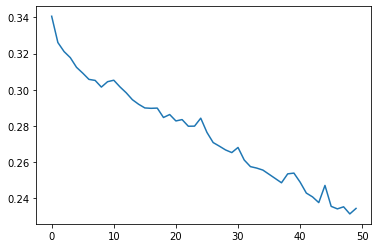

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 490ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


In [45]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,76,0.127166,0.271514,0.127166,0.398680
1,50,0.000000,0.000000,0.127166,0.127166
2,96,0.000000,0.104414,0.127166,0.231580
3,84,0.000000,0.000000,0.127166,0.127166
4,91,0.000000,0.000000,0.127166,0.127166
5,91,0.000000,0.000000,0.127166,0.127166
6,89,0.000000,0.000000,0.127166,0.127166
7,99,0.000000,0.000000,0.127166,0.127166
8,91,0.000000,0.000000,0.127166,0.127166
9,86,0.000000,0.000000,0.127166,0.127166


In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

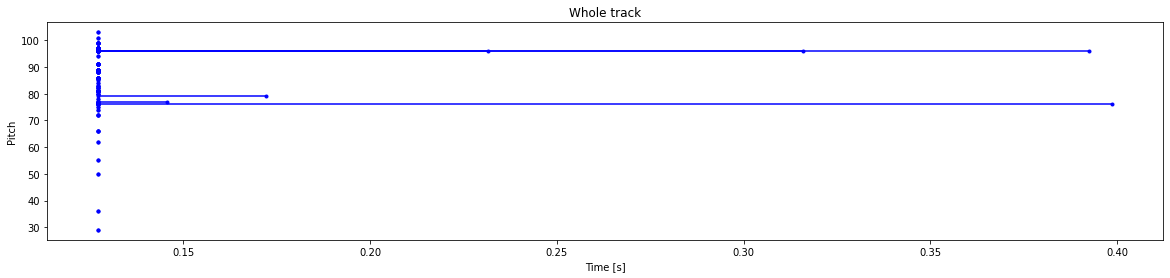

In [47]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

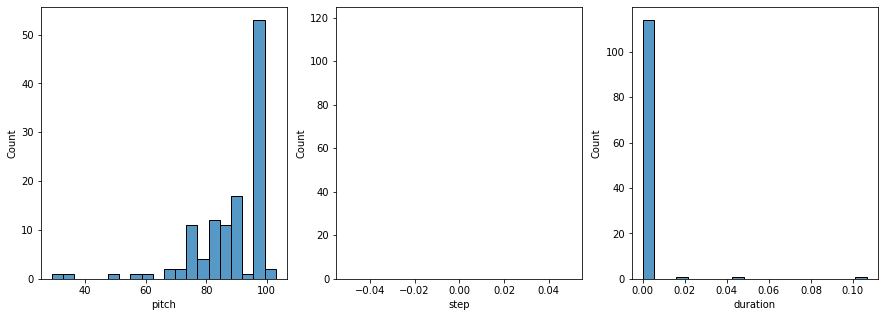

In [48]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which has uses MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

An alternative to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate a entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).